In [1]:
import numpy as np
import random
import gym
from gym import error, spaces, utils
from gym.utils import seeding
import matplotlib.pyplot as plt
""" Four rooms. The goal is either in the 3rd room, or in a hallway adjacent to it
"""
import seaborn as sbn
UP = 0
RIGHT = 1
DOWN = 2
LEFT = 3

NUM_ROOMS = 4


Note: The step function in the environment code provided is not defined for actions in pre-hallway states that do not lead the agent to a hallway state. Please fix this before proceeding.

In [2]:
class FourRooms(gym.Env):
    metadata = {'render.modes': ['human']}
    def __init__(self,ss,goal_state):
        self.ss = ss
        #Rooms              0       1      2      3
        self.room_sizes = [[5,5], [6,5], [4,5], [5,5]]
        self.pre_hallways = [ 
            { tuple([2,4]) : [RIGHT, 0], tuple([4,1]) : [DOWN, 3]}, #1 origin Up-left (down x)
            { tuple([2,0]) : [LEFT, 0], tuple([5,2]) : [DOWN, 1]},  #2     same
            { tuple([0,2]) : [UP, 1], tuple([2,0]) : [LEFT, 2]},    #3     same
            { tuple([3,4]) : [RIGHT, 2], tuple([0,1]) : [UP, 3]},   #4     same
        ]
        #Rooms                    0       1      2      3
        self.hallway_coords = [ [2,5], [6,2], [2,-1], [-1,1] ] 
        #No chance of being cordinates in any of the rooms
        self.hallways = [ 
            #self.hallways[i][j] = [next_room, next_coord] when taking action j from hallway i#
            [ [0, self.hallway_coords[0]], [1, [2,0]], [0, self.hallway_coords[0]], [0, [2,4]] ],
            [ [1, [5,2]], [1, self.hallway_coords[1]], [2, [0,2]], [1, self.hallway_coords[1]] ],
            [ [2, self.hallway_coords[2]], [2, [2,0]], [2, self.hallway_coords[2]], [3, [3,4]] ],
            [ [0, [4,1]], [3, self.hallway_coords[3]], [3, [0,1]], [3, self.hallway_coords[3]] ]
        ]
        self.offsets = [0] * (NUM_ROOMS + 1)
        for i in range(NUM_ROOMS):
            self.offsets[i + 1] = self.offsets[i] + self.room_sizes[i][0] * self.room_sizes[i][1] + 1
#         print(self.offsets)
        
        self.n_states = self.offsets[4] + 1
        self.absorbing_state = self.n_states
        
        self.goal = goal_state  #G1
        self.terminal_state = self.encode(self.goal)
    
        self.noise = 0.33
        self.step_reward = 0.0
        self.terminal_reward = 1.0
        self.bump_reward = 0
        # start state random location in start room
        
        start_room = 0
        sz = self.room_sizes[start_room]
        self.start_state = self.offsets[start_room] + np.random.randint(sz[0]*sz[1] - 1)
        self.start_state = self._reset
        #doubt can it be initialized in a hallway (NO)
        self._reset()
        
        self.action_space = spaces.Discrete(4)
        self.observation_space = spaces.Discrete(self.n_states) # with absorbing state
    def isT(self,state):
        return state==self.terminal_state
    def ind2coord(self, index, sizes):
#         sizes = [self.n]*2
        [rows, cols] = sizes
        assert(index >= 0)
        row = index // cols
        col = index % cols
        return [row, col]

    def coord2ind(self, coord, sizes):
        [rows, cols] = sizes
        [row, col] = coord
        assert(row < rows)
        assert(col < cols)
        return row * cols + col
    def in_hallway_index(self, index=None):
        if index is None:
            index = self.state
        return index in [offset - 1 for offset in self.offsets]

    def in_hallway_coord(self, coord):
        return coord in self.hallway_coords

    def encode(self, location, in_hallway=None):
        [room, coord] = location
        if in_hallway is None:
            in_hallway = self.in_hallway_coord(coord)
        if in_hallway:
            return self.offsets[room + 1] - 1
        # maybe have hallways as input
        ind_in_room = self.coord2ind(coord, sizes=self.room_sizes[room])
        return ind_in_room + self.offsets[room]

    def decode(self, index, in_hallway=None):
        if in_hallway is None:
            in_hallway = self.in_hallway_index(index=index)
        room = [r for r, offset in enumerate(self.offsets[1:5]) if index < offset][0]
        if in_hallway:
            coord_in_room = self.hallway_coords[room]
        else:
            coord_in_room = self.ind2coord(index - self.offsets[room], sizes=self.room_sizes[room])
        return room, coord_in_room # hallway
    
    def _step(self, action,block):
        assert self.action_space.contains(action)
        preaction = action
        in_hallway = self.in_hallway_index()
        [room, coord]= self.decode(self.state, in_hallway=in_hallway)
#         print(room,coord)
        room2 = room; coord2 = coord
        if np.random.rand() < self.noise:
#             print("noice")
            a = action
            while a==action:
                a = self.action_space.sample()
            action = a
            
        if block:
            ####No USE
            action = preaction
#         print(action)
        if in_hallway: # hallway action
#             print("hallway")
            [room2, coord2] = self.hallways[room][action]
        elif tuple(coord) in self.pre_hallways[room].keys():
#             print("hey")
            hallway_info = self.pre_hallways[room][tuple(coord)]
            if action == hallway_info[0]:
                room2 = hallway_info[1]
                coord2 = self.hallway_coords[room2]
            else:
                [row, col] = coord
                [rows, cols] = self.room_sizes[room]
                if action == UP:
                    row = max(row - 1, 0)
                elif action == DOWN:
                    row = min(row + 1, rows - 1)
                elif action == RIGHT:
                    col = min(col + 1, cols - 1)
                elif action == LEFT:
                    col = max(col - 1, 0)
                room2 = room
                coord2 = [row, col]
        else: # normal action
            [row, col] = coord
            [rows, cols] = self.room_sizes[room]
            if action == UP:
                row = max(row - 1, 0)
            elif action == DOWN:
                row = min(row + 1, rows - 1)
            elif action == RIGHT:
                col = min(col + 1, cols - 1)
            elif action == LEFT:
                col = max(col - 1, 0)
            coord2 = [row, col]
#         print("new room new cord" ,room2,coord2)
        new_state = self.encode([room2, coord2])
        self.state = new_state
        reward = self._get_reward(new_state=new_state)
        if self.state == self.terminal_state:
            self.done = True
            return self.state, self._get_reward(), self.done, None

        return new_state, reward, self.done, None

    def _get_reward(self, new_state=None):
        if self.done:
            return self.terminal_reward
        reward = self.step_reward
        if self.bump_reward != 0 and self.state == new_state:
            reward = self.bump_reward
        return reward

    def at_border(self):
        [row, col] = self.ind2coord(self.state)
        return (row == 0 or row == self.n - 1 or col == 0 or col == self.n - 1)

    def _reset(self):
        self.done = True
        while self.done:
            start_room = 0
            sz = self.room_sizes[start_room]
            self.start_state = self.offsets[start_room] + np.random.randint(sz[0]*sz[1] - 1)
            self.state = self.start_state
            self.done = (self.state==self.terminal_state)
#         self.state = self.encode([3,[2,2]])
        if self.ss != [0,[0,0]]:
            self.state = self.encode(self.ss)
        return self.state
#         return self.encode([3,[2,2]])

    def _render(self, mode='human', close=False):
        pass

In [3]:
def get_action(a,eps):
    if np.random.binomial(1, eps) == 1:
        return np.random.randint(0,6) # +2 for options
    mx = np.max(a)
    idx = np.where(a == mx)[0]
    return np.random.choice(idx)
def get_best_action(a):
    mx = np.max(a)
    idx = np.where(a == mx)[0]
    return np.random.choice(idx)

In [4]:

hwpos = {
        #division of options based on the hallway pos in the specified room say 4 itself[i][0] 5 other[i][1]
        0 : [3,0],
        1 : [0,1],
        2 : [1,2],
        3 : [2,3],
    }
xy_actions = {    #increase x     decrease x    increase y    decrease y
     0 : [2,0,1,3],
     1 : [2,0,1,3],
        2 :[2,0,1,3],
        3 :[2,0,1,3],
}
# hw_ind
def option_trajec(state,opt,env):
    [room,coord]=env.decode(state)
    tg_hw = hwpos[room][opt]
    pre_hw = env.pre_hallways[room].keys()
    tprehw_coord = [0,0]
    for p in pre_hw:
        if(tg_hw==env.pre_hallways[room][p][1]):
            tprehw_coord =list(p)
    
    thw_coord = env.hallway_coords[tg_hw]
#     print("Option towards ",room,tprehw_coord);
    nthw_coord = env.hallway_coords[hwpos[room][1-opt]]
    curr_coord = coord
    Trajec = []
    our_room = room
#     print(room)
#     print(state)
    n_st = state
    while(curr_coord != thw_coord):
        action_sel = -1
        
        rc = np.array(tprehw_coord)-np.array(curr_coord)
        ###########Action Selecting#########
        if(abs(rc[0])>abs(rc[1])):
            if(rc[0]>0):
                action_sel =  2
            else:
                action_sel = 0
        elif(abs(rc[0])<abs(rc[1])):
            if(rc[1]>0):
                action_sel = 1
            else:
                action_sel = 3
        else:
            i = random.randint(0,1)
            if(i==0):
                if(rc[0]>0):
                    action_sel =  2
                else:
                    action_sel = 0
            else:
                if(rc[1]>0):
                    action_sel = 1
                else:
                    action_sel = 3 
        if(curr_coord==nthw_coord):
            tup=[]
            tup.append(env.encode([room,curr_coord]))
            tup.append(0)
            tup.append(0)
            Trajec.append(tup)
            return Trajec
#             for i in range(4):
#                 #this is now 
#                 if(env.hallways[room][i][0]==our_room and env.hallways[room][i][1]!=nthw_coord):
#                     action_sel = i
#                     break
        else:
            if(rc[0]==0 and rc[1]==0):
                action_sel = env.pre_hallways[room][tuple(tprehw_coord)][0]
#         print(curr_coord)
#         print(action_sel)
        tup = []
        tup.append(env.encode([room,curr_coord]))
        tup.append(action_sel)
        n_st,r,term,_=env._step(action_sel,False)
        tup.append(r)
        Trajec.append(tup)
#         print(env.decode(n_st))
        [room,curr_coord] = env.decode(n_st)
        if term:
            break
    tup=[]
    tup.append(n_st)
    tup.append(0)
    tup.append(0)
    Trajec.append(tup)
    return Trajec


In [5]:
def option_action(state,opt,env):
    [room,coord]=env.decode(state)
    tg_hw = hwpos[room][opt]
    pre_hw = env.pre_hallways[room].keys()
    tprehw_coord = [0,0]
    for p in pre_hw:
        if(tg_hw==env.pre_hallways[room][p][1]):
            tprehw_coord =list(p)
    
    thw_coord = env.hallway_coords[tg_hw]
#     print("Option towards ",room,tprehw_coord);
    nthw_coord = env.hallway_coords[hwpos[room][1-opt]]
    curr_coord = coord

    our_room = room
#     print(room)
#     print(state)
    n_st = state
    action_sel = -1
    rc = np.array(tprehw_coord)-np.array(curr_coord)
    ###########Action Selecting#########
    if(abs(rc[0])>abs(rc[1])):
        if(rc[0]>0):
            action_sel =  2
        else:
            action_sel = 0
    elif(abs(rc[0])<abs(rc[1])):
        if(rc[1]>0):
            action_sel = 1
        else:
            action_sel = 3
    else:
        i = random.randint(0,1)
        if(i==0):
            if(rc[0]>0):
                action_sel =  2
            else:
                action_sel = 0
        else:
            if(rc[1]>0):
                action_sel = 1
            else:
                action_sel = 3 
    if(curr_coord==nthw_coord):
        return -1
    else:
        if(rc[0]==0 and rc[1]==0):
            action_sel = env.pre_hallways[room][tuple(tprehw_coord)][0]
    return action_sel
    

In [7]:
from collections import defaultdict
def intra_q_learning(env,num_episodes,gamma = 0.9 , alpha = 0.25, epsilon = 0.1):
    Q = defaultdict(lambda:np.zeros(6))
#     env.reset()
#     env.render()
    Episodelen = []
    AvgReward = []
    for episode in range(num_episodes):
#         env.render()
#         print("Episode ",episode)
        resetedpos = env._reset()
#         print("Start state ",resetedpos)
        state = resetedpos
        rew = 0
        length = 0
        while(1):
#             print("State is ",env.decode(state))
            length+=1
            Action_sel = get_action(Q[state],epsilon)
#             print("Best action is",bestaction)
#             print("Action selected ",Action_sel)
#             print("State is",state)
#             if(env.in_hallway_coord(env.decode(state)[1])):
#                 print("hallway ", Q[state]," Selected action ", Action_sel) 
            if(Action_sel<=3):
                ######Primitive Actions########
                next_state, reward,isT, _ = env._step(Action_sel,False)
#                 print("State is",next_state)
                rew+=reward
                length+=1
#                 print("#primitive ",Action_sel)
                best_n_action = get_best_action(Q[next_state])
                #UPDATING
                d = reward + (gamma * Q[next_state][best_n_action]) - Q[state][Action_sel]
                Q[state][Action_sel] = Q[state][Action_sel]+alpha * (d)
                if isT:
                    break
                state = next_state
            else:
                ###options#####
                ###USE OPTION TRAJECTORY######
                Trajec = option_trajec(state,Action_sel-4,env)
                Return_opt = 0
                gamma_pow = 1
                #update options in intraoption
                #DOubt should u update primitive actions or not 
                S = state
                for i in range(len(Trajec)-1):
                    nst = Trajec[i+1][0]
                    best_n_action = get_best_action(Q[nst])
                
                    rew+=Trajec[i][2]
                    if(env.decode(nst)[0]==env.decode(state)[0]):
                        As = Action_sel
                    else:
                        nroom = env.decode(nst)[0]
                        thw = hwpos[env.decode(state)[0]][Action_sel-4] 
                        for i in range(2):
                            if thw == hwpos[nroom][i]:
                                As = i+4
                                break            
                    if i==len(Trajec)-2:
                        ###If Terminal State
                        delt  = rew + (gamma * Q[nst][best_n_action])-Q[S][Action_sel]
                        Q[S][Action_sel] = Q[S][Action_sel] + (alpha * delt)
                    else:
                        ###If Not Terminal State
#                         if As!= Action_sel and i!= (len(Trajec)-1):
#                             print("told ya ", env.decode(nst),As,env.decode(state),Action_sel)
                        delt  = rew + (gamma * Q[nst][Action_sel])-Q[S][Action_sel]
                        Q[S][Action_sel] = Q[S][Action_sel] + (alpha * delt)
                        a = Action_sel - 4
                        if option_action(S,1-a,env)==option_action(S,a,env):
                            ###If actions taken by both options is same then Update the other option
                            delt  = rew + (gamma * Q[nst][9-Action_sel])-Q[S][9-Action_sel]
                            Q[S][9-Action_sel] = Q[S][9-Action_sel] + (alpha * delt)
                            
                    S = nst
                    
                n_st = Trajec[len(Trajec)-1][0]
                length+=len(Trajec)
                if(env.isT(n_st)):
                    break
                state = n_st
        AvgReward.append(rew)
        Episodelen.append(length)
    return AvgReward,Episodelen,Q

In [64]:
ss = [0,[0,0]]  # [0,[0,0]],[3,[2,2]]
goal_state =  [1,[6,2]]  #[2,[1,2]],[1,[6,2]]
e = FourRooms(ss,goal_state)
num_episode = 10000
Q_qlearn = defaultdict(lambda:np.zeros(6))
r_qlearn = np.zeros(num_episode)
l_qlearn = np.zeros(num_episode)

num_runs = 30
smooth = 5
for i in range(num_runs):
    print(i)
    
    r,l,q = intra_q_learning(e,num_episode)
    print("Max is ",np.max(l))
    for j in range(num_episode):
        r_qlearn[j]=(r_qlearn[j]*(i)+r[j])/(i+1)
        l_qlearn[j]=(l_qlearn[j]*(i)+l[j])/(i+1)
    for k in range(e.n_states):
        for a in range(6):
            Q_qlearn[k][a]=(Q_qlearn[k][a]*(i)+q[k][a])/(i+1)
        


0
Max is  526
1
Max is  262
2
Max is  731
3
Max is  436
4
Max is  361
5
Max is  310
6
Max is  353
7
Max is  565
8
Max is  474
9
Max is  503
10
Max is  344
11
Max is  449
12
Max is  438
13
Max is  462
14
Max is  653
15
Max is  342
16
Max is  309
17
Max is  383
18
Max is  411
19
Max is  565
20
Max is  348
21
Max is  789
22
Max is  452
23
Max is  313
24
Max is  509
25
Max is  207
26
Max is  527
27
Max is  669
28
Max is  278
29
Max is  180


In [65]:
# print(r_qlearn)

In [66]:
# print(l_qlearn)

In [67]:
r_qllearn = np.zeros(num_episode)
for i in range(num_episode):
        r_qllearn[i]=r_qlearn[i]/l_qlearn[i]

# Plots

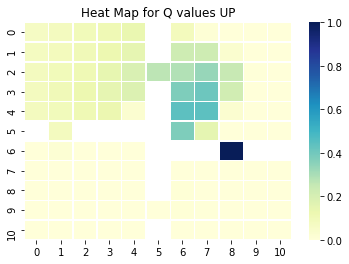

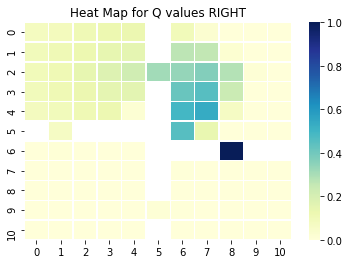

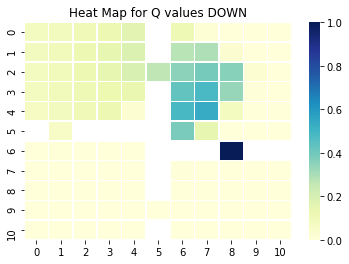

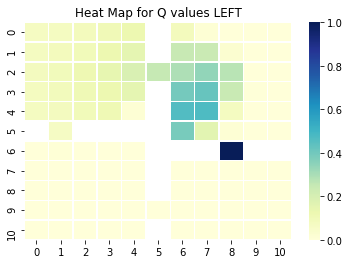

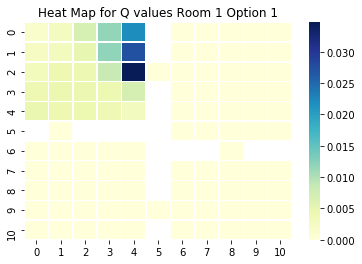

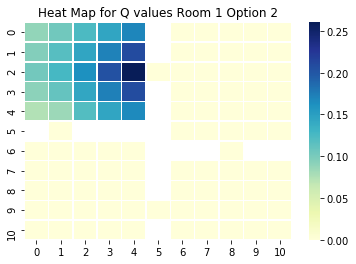

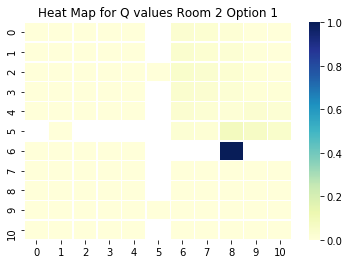

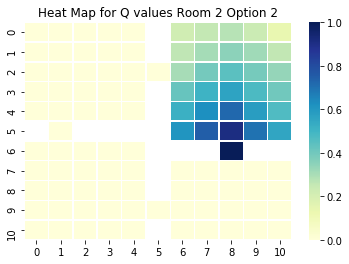

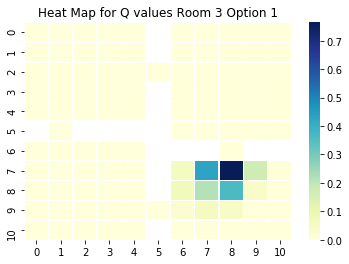

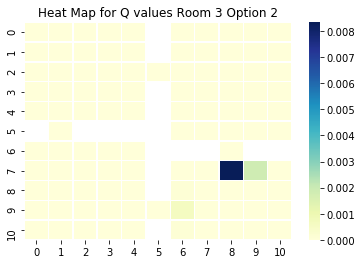

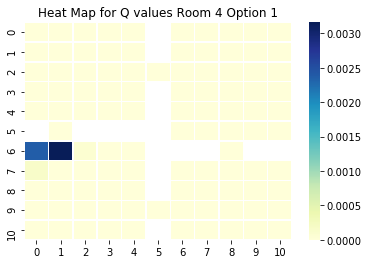

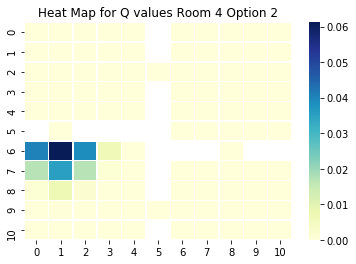

In [69]:

# print(Q_qlearn)
offset = {0:[0,0],1:[0,6],3:[6,0],2:[7,6]}
mask = np.array([[False]*11 for i in range(11)])
for i in range(11):
    mask[i][5] = True
for i in range(6):
    mask[5][i] = True
for i in range(6,11):
    mask[6][i] = True
mask[2][5] = False
mask[5][1] = False
mask[6][8] = False
mask[9][5] = False
e = FourRooms(ss,goal_state) 

Q_qlearn[e.terminal_state]=np.array([1,1,1,1,1,1])






e = FourRooms(ss,goal_state) 

q = np.zeros([11,11])
d = Q_qlearn.keys()
for k in d:
    if k<104:
        r,c = e.decode(k)    
        i=0
        j=0
        if r==0:
            i = c[0]
            j = c[1]
        if r==1:
            i = c[0]
            j = c[1]+6
        if r==2:
            i = c[0]+7
            j = c[1]+6
        if r==3:
            i = c[0]+6
            j = c[1]
        q[i][j] = Q_qlearn[k][0]
        
# %matplotlib inline  
# %matplotlib notebook
# %pylab
ax = sbn.heatmap(q,mask=mask, linewidth=0.5, cmap="YlGnBu")
plt.title("Heat Map for Q values UP")
plt.show()
e = FourRooms(ss,goal_state) 

q = np.zeros([11,11])
d = Q_qlearn.keys()
for k in d:
    if k<104:
        r,c = e.decode(k)    
        i=0
        j=0
        if r==0:
            i = c[0]
            j = c[1]
        if r==1:
            i = c[0]
            j = c[1]+6
        if r==2:
            i = c[0]+7
            j = c[1]+6
        if r==3:
            i = c[0]+6
            j = c[1]
        q[i][j] = Q_qlearn[k][1]
        
# %matplotlib inline  
# %matplotlib notebook
# %pylab
ax = sbn.heatmap(q,mask=mask, linewidth=0.5, cmap="YlGnBu")
plt.title("Heat Map for Q values RIGHT")
plt.show()
e = FourRooms(ss,goal_state) 

q = np.zeros([11,11])
d = Q_qlearn.keys()
for k in d:
    if k<104:
        r,c = e.decode(k)    
        i=0
        j=0
        if r==0:
            i = c[0]
            j = c[1]
        if r==1:
            i = c[0]
            j = c[1]+6
        if r==2:
            i = c[0]+7
            j = c[1]+6
        if r==3:
            i = c[0]+6
            j = c[1]
        q[i][j] = Q_qlearn[k][2]
        
# %matplotlib inline  
# %matplotlib notebook
# %pylab
ax = sbn.heatmap(q,mask=mask, linewidth=0.5, cmap="YlGnBu")
plt.title("Heat Map for Q values DOWN")
plt.show()
e = FourRooms(ss,goal_state) 

q = np.zeros([11,11])
d = Q_qlearn.keys()
for k in d:
    if k<104:
        r,c = e.decode(k)    
        i=0
        j=0
        if r==0:
            i = c[0]
            j = c[1]
        if r==1:
            i = c[0]
            j = c[1]+6
        if r==2:
            i = c[0]+7
            j = c[1]+6
        if r==3:
            i = c[0]+6
            j = c[1]
        q[i][j] = Q_qlearn[k][3]
        
# %matplotlib inline  
# %matplotlib notebook
# %pylab
ax = sbn.heatmap(q,mask=mask, linewidth=0.5, cmap="YlGnBu")
plt.title("Heat Map for Q values LEFT")
plt.show()
e = FourRooms(ss,goal_state) 

q = np.zeros([11,11])
d = Q_qlearn.keys()
for k in d:
    if k<104:
        r,c = e.decode(k)    
        i=0
        j=0
        if r==0:
            
            i = c[0]
            j = c[1]
            q[i][j] = Q_qlearn[k][4]
        if r==1:
            i = c[0]
            j = c[1]+6
        if r==2:
            i = c[0]+7
            j = c[1]+6
        if r==3:
            i = c[0]+6
            j = c[1]
ax = sbn.heatmap(q,mask=mask, linewidth=0.5, cmap="YlGnBu")
plt.title("Heat Map for Q values Room 1 Option 1")
plt.show()
e = FourRooms(ss,goal_state) 

q = np.zeros([11,11])
d = Q_qlearn.keys()
for k in d:
    if k<104:
        r,c = e.decode(k)    
        i=0
        j=0
        if r==0:
            
            i = c[0]
            j = c[1]
            q[i][j] = Q_qlearn[k][5]
        if r==1:
            i = c[0]
            j = c[1]+6
        if r==2:
            i = c[0]+7
            j = c[1]+6
        if r==3:
            i = c[0]+6
            j = c[1]
        
# %matplotlib inline  
# %matplotlib notebook
# %pylab
ax = sbn.heatmap(q,mask=mask, linewidth=0.5, cmap="YlGnBu")
plt.title("Heat Map for Q values Room 1 Option 2")
plt.show()



q = np.zeros([11,11])
d = Q_qlearn.keys()
for k in d:
    if k<104:
        r,c = e.decode(k)    
        i=0
        j=0
        if r==0:
            
            i = c[0]
            j = c[1]
        if r==1:
            
            i = c[0]
            j = c[1]+6
            q[i][j] = Q_qlearn[k][4]
        if r==2:
            i = c[0]+7
            j = c[1]+6
        if r==3:
            i = c[0]+6
            j = c[1]
ax = sbn.heatmap(q,mask=mask, linewidth=0.5, cmap="YlGnBu")
plt.title("Heat Map for Q values Room 2 Option 1")
plt.show()
e = FourRooms(ss,goal_state) 

q = np.zeros([11,11])
d = Q_qlearn.keys()
for k in d:
    if k<104:
        r,c = e.decode(k)    
        i=0
        j=0
        if r==0:
            
            i = c[0]
            j = c[1]
        if r==1:
            
            i = c[0]
            j = c[1]+6
            q[i][j] = Q_qlearn[k][5]
        if r==2:
            i = c[0]+7
            j = c[1]+6
        if r==3:
            i = c[0]+6
            j = c[1]
        
# %matplotlib inline  
# %matplotlib notebook
# %pylab
ax = sbn.heatmap(q,mask=mask, linewidth=0.5, cmap="YlGnBu")
plt.title("Heat Map for Q values Room 2 Option 2")
plt.show()






q = np.zeros([11,11])
d = Q_qlearn.keys()
for k in d:
    if k<104:
        r,c = e.decode(k)    
        i=0
        j=0
        if r==0:
            
            i = c[0]
            j = c[1]
        if r==1:
            
            i = c[0]
            j = c[1]+6
        if r==2:
            
            i = c[0]+7
            j = c[1]+6
            q[i][j] = Q_qlearn[k][4]
        if r==3:
            i = c[0]+6
            j = c[1]
ax = sbn.heatmap(q,mask=mask, linewidth=0.5, cmap="YlGnBu")
plt.title("Heat Map for Q values Room 3 Option 1")
plt.show()
e = FourRooms(ss,goal_state) 

q = np.zeros([11,11])
d = Q_qlearn.keys()
for k in d:
    if k<104:
        r,c = e.decode(k)    
        i=0
        j=0
        if r==0:
            
            i = c[0]
            j = c[1]
        if r==1:
            
            i = c[0]
            j = c[1]+6
        if r==2:
            
            i = c[0]+7
            j = c[1]+6
            q[i][j] = Q_qlearn[k][5]
        if r==3:
            i = c[0]+6
            j = c[1]
        
# %matplotlib inline  
# %matplotlib notebook
# %pylab
ax = sbn.heatmap(q,mask=mask, linewidth=0.5, cmap="YlGnBu")
plt.title("Heat Map for Q values Room 3 Option 2")
plt.show()





q = np.zeros([11,11])
d = Q_qlearn.keys()
for k in d:
    if k<104:
        r,c = e.decode(k)    
        i=0
        j=0
        if r==0:
            
            i = c[0]
            j = c[1]
        if r==1:
            
            i = c[0]
            j = c[1]+6
        if r==2:
            i = c[0]+7
            j = c[1]+6
        if r==3:
            
            i = c[0]+6
            j = c[1]
            q[i][j] = Q_qlearn[k][4]
ax = sbn.heatmap(q,mask=mask, linewidth=0.5, cmap="YlGnBu")
plt.title("Heat Map for Q values Room 4 Option 1")
plt.show()
e = FourRooms(ss,goal_state) 

q = np.zeros([11,11])
d = Q_qlearn.keys()
for k in d:
    if k<104:
        r,c = e.decode(k)    
        i=0
        j=0
        if r==0:
            
            i = c[0]
            j = c[1]
        if r==1:
            
            i = c[0]
            j = c[1]+6
        if r==2:
            i = c[0]+7
            j = c[1]+6
        if r==3:
            
            i = c[0]+6
            j = c[1]
            q[i][j] = Q_qlearn[k][5]
        
# %matplotlib inline  
# %matplotlib notebook
# %pylab
ax = sbn.heatmap(q,mask=mask, linewidth=0.5, cmap="YlGnBu")
plt.title("Heat Map for Q values Room 4 Option 2")
plt.show()


In [70]:
l_sqlearn = [

173.7,127.1333333333333,141.8,114.9,81.83333333333333,77.26666666666667,70.06666666666668,74.36666666666666,61.333333333333336,61.466666666666654,65.7,49.3,42.833333333333336,51.49999999999999,50.7,40.63333333333333,48.733333333333334,42.833333333333336,48.13333333333333,55.53333333333333,43.13333333333333,42.7,44.8,47.5,48.2,53.93333333333333,42.0,47.53333333333333,39.1,52.2,51.6,44.93333333333332,42.466666666666676,44.666666666666664,37.86666666666665,47.733333333333334,42.366666666666674,41.13333333333332,51.0,46.766666666666666,43.5,38.766666666666666,45.03333333333333,45.56666666666667,46.7,36.46666666666667,43.766666666666666,40.266666666666666,37.5,38.43333333333333,36.39999999999999,41.8,40.96666666666667,35.83333333333332,42.49999999999999,37.0,38.733333333333334,40.29999999999999,44.2,39.46666666666667,41.833333333333336,36.5,35.8,30.6,35.23333333333335,36.3,38.4,39.133333333333326,36.4,40.53333333333333,37.666666666666664,37.333333333333336,41.033333333333324,43.63333333333333,40.03333333333333,40.59999999999999,39.233333333333334,38.86666666666667,36.333333333333336,38.46666666666667,39.56666666666667,43.13333333333333,40.43333333333333,45.93333333333333,37.3,36.599999999999994,43.2,37.93333333333333,38.2,35.86666666666667,41.63333333333333,38.5,45.3,41.86666666666667,37.1,40.233333333333334,36.9,41.0,36.63333333333333,38.63333333333333,37.46666666666667,40.333333333333336,34.333333333333336,38.40000000000001,39.03333333333333,40.03333333333333,37.1,38.36666666666667,40.46666666666667,40.233333333333334,39.96666666666667,41.43333333333333,37.43333333333333,34.06666666666667,39.46666666666667,38.20000000000002,40.83333333333333,46.73333333333334,40.7,43.53333333333333,35.13333333333335,33.800000000000004,38.3,37.733333333333334,42.43333333333333,34.96666666666667,38.400000000000006,38.400000000000006,40.066666666666656,39.6,37.4,41.1,41.26666666666666,38.83333333333333,37.36666666666667,41.96666666666667,41.1,39.1,40.233333333333334,37.80000000000002,39.36666666666667,36.86666666666665,36.09999999999999,39.06666666666667,35.06666666666667,35.733333333333334,41.03333333333333,35.3,34.49999999999999,34.66666666666667,36.5,38.1,41.3,43.8,41.10000000000001,35.13333333333333,34.23333333333333,35.8,39.1,37.100000000000016,39.43333333333333,35.199999999999996,34.36666666666667,36.733333333333334,35.833333333333336,39.53333333333333,38.56666666666668,36.7,36.46666666666667,34.33333333333334,43.266666666666666,32.96666666666666,37.000000000000014,35.7,37.666666666666664,40.6,36.9,32.66666666666666,32.366666666666674,42.1,36.63333333333333,38.566666666666684,38.96666666666667,36.566666666666656,46.03333333333333,38.46666666666667,36.56666666666667,41.133333333333326,37.9,39.5,37.2,36.0,31.43333333333333,39.5,40.53333333333333,40.733333333333334,41.13333333333333,35.3,30.466666666666665,40.86666666666666,38.333333333333336,37.099999999999994,36.46666666666667,39.099999999999994,35.83333333333334,37.46666666666667,41.89999999999999,39.233333333333334,36.900000000000006,41.8,37.96666666666667,30.366666666666667,36.43333333333332,37.46666666666667,41.36666666666667,36.13333333333333,32.56666666666668,41.233333333333334,36.53333333333333,39.333333333333336,36.53333333333333,33.63333333333334,39.93333333333333,36.8,35.8,40.833333333333336,36.766666666666666,37.266666666666666,36.23333333333334,35.833333333333336,37.7,32.36666666666666,42.866666666666674,41.53333333333333,37.233333333333334,37.03333333333333,40.833333333333336,39.733333333333334,33.36666666666667,35.46666666666667,41.666666666666664,39.13333333333333,35.233333333333334,37.43333333333333,42.96666666666667,35.800000000000004,35.46666666666667,37.56666666666667,37.39999999999999,34.099999999999994,34.766666666666666,32.900000000000006,38.1,43.36666666666667,40.03333333333334,35.83333333333333,39.70000000000002,30.5,35.9,38.86666666666667,40.8,33.03333333333334,37.9,35.83333333333333,37.09999999999999,35.3,37.33333333333332,36.033333333333324,32.7,37.93333333333333,36.39999999999999,36.466666666666654,41.09999999999999,33.26666666666667,30.466666666666665,34.83333333333334,35.03333333333334,35.166666666666664,31.7,31.533333333333335,35.76666666666667,38.533333333333324,37.2,36.36666666666667,35.89999999999999,35.33333333333334,35.599999999999994,37.46666666666667,40.9,39.7,36.8,42.93333333333333,40.633333333333326,36.833333333333336,34.79999999999998,41.066666666666656,36.06666666666668,33.966666666666676,41.5,38.9,37.133333333333326,34.833333333333336,35.6,36.26666666666668,36.366666666666674,33.49999999999999,33.56666666666666,37.76666666666665,37.96666666666667,37.766666666666666,35.13333333333333,39.833333333333336,38.43333333333333,38.566666666666684,33.833333333333336,33.0,37.966666666666654,33.900000000000006,34.43333333333333,38.233333333333334,34.79999999999999,29.333333333333332,35.766666666666666,41.36666666666667,39.46666666666667,37.46666666666667,34.23333333333335,38.400000000000006,38.766666666666666,32.666666666666664,39.33333333333334,33.03333333333334,38.8,36.666666666666664,35.33333333333333,36.63333333333333,34.93333333333332,33.13333333333334,32.39999999999999,32.83333333333333,44.2,35.166666666666664,38.33333333333334,33.166666666666664,41.06666666666667,29.8,35.26666666666668,37.03333333333333,29.333333333333332,39.13333333333333,33.86666666666667,37.266666666666666,32.3,35.2,40.76666666666666,37.733333333333334,35.73333333333334,35.5,33.00000000000001,33.833333333333336,37.80000000000002,37.79999999999999,37.999999999999986,35.7,35.56666666666667,38.86666666666667,36.9,33.10000000000001,31.699999999999996,37.5,34.16666666666665,40.699999999999996,38.766666666666666,37.733333333333334,34.76666666666668,34.66666666666668,36.033333333333324,36.93333333333333,36.3,35.3,35.7,38.2,38.266666666666666,43.83333333333333,40.96666666666667,37.46666666666668,34.900000000000006,34.36666666666667,33.699999999999996,32.43333333333333,42.166666666666664,35.96666666666667,41.90000000000001,38.53333333333333,34.43333333333333,36.96666666666667,36.533333333333346,39.03333333333333,31.0,34.099999999999994,41.56666666666667,36.166666666666664,35.266666666666666,39.766666666666666,37.099999999999994,41.99999999999999,42.29999999999999,42.7,38.1,38.63333333333333,38.63333333333332,43.5,33.53333333333333,41.76666666666667,34.06666666666667,34.533333333333324,36.03333333333333,36.06666666666667,36.86666666666667,32.433333333333344,34.033333333333324,34.8,38.96666666666666,42.3,35.43333333333333,39.266666666666666,37.53333333333333,39.10000000000001,34.433333333333344,34.53333333333333,32.73333333333334,38.666666666666664,38.03333333333333,32.033333333333346,34.26666666666667,35.9,32.533333333333324,34.06666666666667,33.333333333333336,34.9,36.36666666666667,34.53333333333333,30.766666666666666,31.433333333333334,39.3,36.399999999999984,36.433333333333316,34.666666666666664,38.266666666666666,35.9,36.733333333333334,33.733333333333334,33.03333333333334,32.43333333333332,38.5,33.63333333333333,32.43333333333333,34.86666666666667,35.733333333333334,36.333333333333336,33.06666666666666,38.06666666666667,34.333333333333336,36.33333333333333,33.166666666666664,36.066666666666656,37.06666666666668,31.6,37.73333333333334,35.0,30.466666666666665,35.06666666666665,34.5,31.633333333333333,35.59999999999999,33.23333333333334,33.900000000000006,35.56666666666667,38.433333333333344,36.99999999999999,35.43333333333333,32.266666666666666,34.63333333333332,31.466666666666665,31.13333333333334,38.166666666666664,42.06666666666667,33.93333333333333,37.03333333333333,34.73333333333335,34.8,34.46666666666667,34.56666666666667,33.50000000000001,37.033333333333324,34.5,37.300000000000004,37.66666666666665,37.1,35.89999999999999,37.46666666666667,30.133333333333333,38.43333333333333,34.1,35.06666666666667,38.733333333333334,37.13333333333334,31.4,36.166666666666664,38.86666666666667,35.233333333333334,36.766666666666666,31.466666666666665,29.766666666666666,37.733333333333334,42.300000000000004,37.266666666666666,35.7,38.36666666666668,35.3,33.766666666666666,36.933333333333344,35.96666666666668,30.8,37.766666666666666,35.333333333333336,34.2,36.4,35.666666666666664,34.66666666666667,31.06666666666667,43.8,37.73333333333333,42.9,36.666666666666664,36.16666666666668,36.433333333333316,34.86666666666667,36.333333333333336,34.96666666666667,31.9,35.13333333333334,31.433333333333334,37.53333333333333,34.8,32.03333333333333,35.666666666666664,37.6,39.53333333333333,39.6,36.03333333333333,35.13333333333333,37.06666666666668,37.33333333333334,38.96666666666667,31.633333333333326,38.63333333333333,37.16666666666666,35.5,36.666666666666664,39.06666666666667,36.5,39.0,38.3,38.43333333333333,37.36666666666667,36.56666666666668,41.63333333333333,35.83333333333335,37.300000000000004,42.5,38.666666666666664,34.266666666666666,33.99999999999999,35.96666666666668,32.06666666666666,41.833333333333336,35.999999999999986,32.466666666666676,31.8,35.699999999999996,38.333333333333336,40.4,35.03333333333333,41.6,36.0,38.93333333333333,33.7,37.96666666666667,33.16666666666667,37.9,38.866666666666674,36.89999999999999,35.93333333333333,39.333333333333336,35.43333333333335,32.0,38.5,38.63333333333333,34.83333333333333,34.20000000000001,39.63333333333333,39.2,35.86666666666667,38.96666666666666,34.76666666666667,35.733333333333334,39.4,36.0,36.13333333333333,33.7,36.43333333333335,33.03333333333333,34.733333333333334,30.133333333333333,37.53333333333333,37.46666666666667,37.666666666666664,33.03333333333334,36.83333333333335,33.26666666666667,33.33333333333333,33.93333333333332,34.36666666666667,33.43333333333332,38.86666666666667,35.600000000000016,35.333333333333336,35.7,37.16666666666667,38.10000000000001,34.13333333333333,34.9,37.0,38.4,33.800000000000004,34.233333333333334,31.5,35.8,33.53333333333332,33.70000000000001,32.53333333333333,35.066666666666656,38.93333333333333,32.66666666666667,29.3,32.06666666666667,36.56666666666667,34.00000000000001,34.4,31.6,35.36666666666667,33.76666666666666,34.03333333333333,35.56666666666667,34.93333333333332,36.33333333333335,28.8,38.63333333333333,33.93333333333333,32.9,30.533333333333335,31.0,32.93333333333332,32.833333333333336,38.166666666666664,37.96666666666668,35.833333333333336,37.06666666666668,33.96666666666666,34.66666666666666,34.8,36.4,35.1,36.06666666666667,31.466666666666665,39.43333333333333,35.166666666666664,34.63333333333333,31.766666666666666,35.6,34.43333333333332,31.566666666666666,38.43333333333335,33.5,31.5,39.9,33.6,38.7,39.1,36.933333333333344,40.5,38.6,36.333333333333336,40.5,38.53333333333333,34.3,39.13333333333333,31.899999999999995,37.53333333333332,34.1,38.46666666666667,40.266666666666666,35.03333333333333,38.9,37.03333333333332,32.83333333333333,40.03333333333332,34.13333333333333,39.2,36.3,32.733333333333334,35.4,33.63333333333333,33.56666666666668,35.666666666666664,36.9,34.20000000000002,32.6,39.36666666666667,40.56666666666667,35.06666666666667,31.199999999999992,35.60000000000001,36.16666666666666,30.833333333333332,32.70000000000001,34.43333333333333,34.63333333333333,35.666666666666664,32.79999999999999,40.46666666666667,39.63333333333332,35.73333333333332,42.5,42.06666666666667,34.49999999999999,35.03333333333333,31.466666666666665,32.53333333333333,32.400000000000006,33.53333333333334,31.466666666666665,30.1,32.53333333333334,37.29999999999998,44.53333333333333,37.266666666666666,35.266666666666666,34.83333333333335,37.733333333333334,33.50000000000001,37.4,36.533333333333324,38.63333333333333,36.833333333333336,35.866666666666646,32.83333333333334,35.96666666666666,32.00000000000001,37.2,35.833333333333336,36.033333333333346,43.099999999999994,36.03333333333333,36.06666666666668,31.533333333333324,35.066666666666656,31.733333333333338,36.333333333333336,37.633333333333326,38.03333333333333,41.9,35.199999999999996,35.36666666666667,38.2,36.866666666666674,39.03333333333333,33.23333333333335,35.2,34.7,37.266666666666666,33.06666666666668,32.199999999999996,31.39999999999999,36.033333333333324,35.03333333333334,39.03333333333334,35.599999999999994,36.8,38.7,35.2,32.96666666666667,34.133333333333326,33.6,33.26666666666667,33.8,30.566666666666666,37.5,35.73333333333335,37.43333333333333,36.199999999999996,35.233333333333334,36.099999999999994,32.46666666666667,33.36666666666666,35.93333333333333,32.66666666666667,37.13333333333333,32.63333333333333,35.199999999999996,32.766666666666666,34.96666666666667,34.5,32.43333333333333,39.333333333333336,33.800000000000004,36.90000000000001,36.033333333333324,35.4,37.4,37.866666666666674,33.73333333333334,35.133333333333326,33.699999999999996,34.66666666666666,35.166666666666664,34.13333333333334,36.099999999999994,33.23333333333334,36.96666666666667,41.50000000000001,31.93333333333333,34.50000000000001,41.4,40.06666666666667,35.1,34.56666666666667,33.06666666666667,37.4,36.96666666666667,37.56666666666667,37.0,30.4,32.7,35.7,31.33333333333332,34.43333333333333,36.43333333333333,34.46666666666667,36.13333333333333,38.16666666666667,39.7,32.13333333333334,34.033333333333324,35.433333333333344,34.46666666666667,39.03333333333332,33.93333333333333,40.233333333333334,32.7,38.966666666666654,36.99999999999999,35.8,37.13333333333333,43.4,34.36666666666667,32.73333333333333,36.733333333333334,31.533333333333328,36.03333333333333,33.96666666666666,33.93333333333333,35.93333333333333,38.50000000000001,31.5,35.033333333333324,36.6,39.06666666666667,34.833333333333336,31.233333333333334,32.800000000000004,37.13333333333333,30.066666666666663,36.966666666666676,32.233333333333334,36.53333333333333,38.96666666666666,32.00000000000001,38.2,34.400000000000006,31.6,37.36666666666667,34.6,35.26666666666668,38.833333333333336,32.96666666666667,35.33333333333334,36.36666666666667,38.7,44.333333333333336,43.29999999999999,41.233333333333334,33.96666666666667,35.36666666666667,33.56666666666666,32.56666666666667,37.13333333333334,36.233333333333334,35.56666666666667,32.8,33.733333333333334,34.6,35.733333333333334,39.8,35.1,36.20000000000001,36.9,33.9,34.466666666666676,34.566666666666656,33.23333333333334,34.13333333333333,32.76666666666667,39.266666666666666,36.13333333333333,38.833333333333336,35.46666666666667,35.36666666666667,35.03333333333333,29.433333333333334,42.1,40.699999999999996,34.03333333333333,30.033333333333335,40.9,37.366666666666674,36.33333333333333,35.53333333333333,38.7,37.43333333333333,33.50000000000001,35.53333333333333,42.733333333333334,41.36666666666667,36.16666666666667,38.96666666666667,31.433333333333334,32.73333333333334,43.333333333333336,31.6,36.13333333333334,35.833333333333336,37.733333333333334,38.633333333333326,38.16666666666668,32.00000000000001,34.7,35.86666666666668,27.8,34.53333333333333,31.3,32.86666666666667,39.63333333333332,38.10000000000001,37.86666666666666,35.80000000000002,36.13333333333333,35.96666666666667,33.23333333333334,35.13333333333333,32.93333333333332,34.7,37.46666666666666,37.333333333333336,32.56666666666667,31.5,34.5,39.2,38.7,42.433333333333316,34.5,35.90000000000001,39.5,37.03333333333334,33.16666666666666,34.79999999999998,36.8,33.50000000000001,35.49999999999999,34.333333333333336,34.63333333333333,32.533333333333346,33.033333333333346,34.93333333333333,36.599999999999994,38.53333333333333,33.96666666666667,38.56666666666667,32.96666666666667,31.566666666666666,36.733333333333334,38.16666666666667,29.9,37.199999999999996,36.13333333333333,32.8,36.63333333333335,41.93333333333333,36.63333333333333,39.266666666666666,36.033333333333324,40.7,35.933333333333316,33.53333333333333,32.16666666666666,36.933333333333344,35.06666666666665,32.46666666666667,35.9,35.06666666666668,38.833333333333336,34.7,36.8,41.266666666666666,36.233333333333334,37.36666666666667,37.8,36.333333333333336,37.13333333333333,31.26666666666667,41.03333333333333,31.966666666666665,34.133333333333326,34.73333333333334,45.86666666666666,42.833333333333336,28.266666666666666,32.900000000000006,35.93333333333333,31.033333333333335,41.900000000000006,36.766666666666666,36.23333333333334,34.2,33.26666666666667,34.6,32.0,35.7,34.9,34.93333333333333,42.400000000000006,39.86666666666667,40.5,36.7,39.666666666666664,41.46666666666667,34.46666666666667,39.10000000000001,38.133333333333326,35.89999999999999,45.53333333333333,36.900000000000006,31.666666666666668,34.1,34.333333333333336,34.7,32.5,39.5,36.7,36.00000000000001,35.33333333333334,36.9,33.56666666666666,36.33333333333334,40.733333333333334,35.59999999999999,35.2,33.26666666666666,38.96666666666667,37.46666666666666,34.53333333333332,38.13333333333332,33.766666666666666,39.53333333333333,38.16666666666667,36.79999999999999,40.2,35.5,34.26666666666667,37.6,42.03333333333333,33.56666666666667,35.83333333333334,36.36666666666667,39.86666666666666,31.566666666666666,33.199999999999996,37.2,35.16666666666666,34.6,36.033333333333324,35.8,32.53333333333333,31.999999999999996,34.13333333333333,31.966666666666665,39.6,35.86666666666667,33.26666666666667,36.49999999999999,34.566666666666684,43.96666666666667,41.2,44.63333333333333,33.86666666666665,37.20000000000002,35.06666666666668,31.433333333333334,37.0,38.63333333333333,34.166666666666664,32.166666666666664,36.36666666666667,33.86666666666667,39.53333333333333,34.833333333333336,38.36666666666667,34.233333333333334,38.333333333333336,38.86666666666667,33.83333333333333,34.2,34.13333333333333,37.99999999999999,35.76666666666668,34.96666666666667,37.40000000000001,35.400000000000006,36.43333333333333,34.266666666666666,35.16666666666667,37.43333333333333,30.9,32.36666666666667,37.666666666666664,32.066666666666656,36.89999999999999,31.433333333333323,36.13333333333335,34.433333333333316,36.6,33.86666666666666,33.26666666666667,37.833333333333336,40.199999999999996,34.7,33.266666666666666,38.4,32.699999999999996,38.333333333333336,33.99999999999999,34.63333333333333,36.266666666666666,34.93333333333333,39.36666666666666,33.9,38.6,32.76666666666666,35.46666666666666,37.36666666666666,36.49999999999999,37.333333333333336,37.49999999999999,37.66666666666666,42.9,39.666666666666664,35.100000000000016,35.59999999999999,36.06666666666667,39.0,40.1,36.83333333333332,34.499999999999986,36.766666666666666,35.46666666666667,37.0,40.2,36.833333333333336,36.4,37.23333333333333,37.56666666666667,39.333333333333336,35.166666666666664,33.6,35.46666666666667,33.26666666666666,34.66666666666666,34.8,33.966666666666654,34.03333333333333,31.7,34.5,35.100000000000016,37.066666666666684,34.93333333333333,36.36666666666667,32.36666666666667,38.86666666666667,32.06666666666667,31.033333333333335,35.43333333333333,36.83333333333333,37.666666666666664,36.03333333333333,35.166666666666664,39.53333333333333,32.46666666666667,34.666666666666664,32.599999999999994,38.16666666666665,32.16666666666666,30.166666666666668,38.033333333333324,36.266666666666666,35.43333333333333,38.06666666666667,34.53333333333334,42.43333333333333,36.266666666666666,35.5,30.933333333333334,39.46666666666666,35.16666666666665,34.0,39.03333333333333,33.53333333333334,35.96666666666667,38.666666666666664,39.36666666666667,36.9,31.966666666666672,36.333333333333336,38.06666666666667,30.066666666666666,33.999999999999986,33.833333333333336,35.53333333333334,34.03333333333334,35.86666666666667,33.233333333333334,30.8,38.633333333333326,36.23333333333333,36.26666666666666,38.39999999999999,36.166666666666664,39.93333333333333,33.56666666666667,33.000000000000014,36.03333333333333,29.666666666666668,34.63333333333333,33.133333333333326,44.833333333333336,36.0,31.166666666666668,39.5,40.666666666666664,33.13333333333335,38.5,33.9,35.133333333333326,36.06666666666667,35.333333333333336,30.933333333333334,33.76666666666667,32.599999999999994,37.1,31.833333333333353,31.433333333333334,32.3,33.166666666666664,33.93333333333334,31.69999999999999,30.0,34.7,33.366666666666674,35.166666666666664,30.3,37.2,34.9,32.599999999999994,34.43333333333332,38.2,34.26666666666665,35.199999999999996,31.60000000000001,36.83333333333333,37.76666666666666,37.5,32.33333333333334,32.50000000000001,34.5,35.46666666666666,31.80000000000001,32.999999999999986,32.400000000000006,32.06666666666667,32.53333333333333,30.4,32.8,37.0,36.000000000000014,31.7,38.599999999999994,35.666666666666664,39.433333333333344,32.36666666666666,36.53333333333333,35.2,33.99999999999999,34.13333333333333,33.266666666666666,38.333333333333336,35.29999999999999,34.033333333333324,39.1,34.26666666666665,35.56666666666667,41.5,36.4,39.099999999999994,34.233333333333334,36.10000000000001,34.0,33.73333333333333,30.966666666666665,36.06666666666668,35.4,35.166666666666664,37.26666666666665,40.33333333333333,37.10000000000001,36.733333333333334,36.39999999999999,39.4,34.166666666666664,37.9,33.63333333333332,35.333333333333336,33.20000000000001,32.166666666666664,38.499999999999986,35.9,32.46666666666667,32.43333333333333,35.366666666666674,34.79999999999999,33.2,34.76666666666666,37.666666666666664,34.4,32.1,31.6,34.166666666666664,33.7,34.00000000000001,36.233333333333334,33.633333333333354,34.76666666666665,38.2,33.73333333333331,31.8,41.53333333333334,36.5,34.5,36.266666666666666,36.46666666666667,32.96666666666667,30.966666666666676,35.0,32.36666666666668,32.53333333333333,34.03333333333333,33.33333333333334,34.46666666666667,35.999999999999986,32.233333333333334,31.166666666666668,34.66666666666667,33.63333333333334,34.1,33.50000000000001,32.099999999999994,34.39999999999999,35.000000000000014,35.900000000000006,32.90000000000001,36.43333333333333,35.86666666666667,36.433333333333344,40.03333333333333,39.63333333333332,34.666666666666664,36.1,28.733333333333334,31.633333333333322,34.033333333333324,34.933333333333344,36.03333333333334,35.4,31.8,32.733333333333334,29.7,39.06666666666668,36.0,37.19999999999998,33.7,36.63333333333333,34.36666666666667,34.333333333333336,34.59999999999999,38.166666666666664,35.96666666666667,32.36666666666667,32.533333333333346,38.83333333333333,45.03333333333333,33.63333333333333,34.866666666666674,31.800000000000008,38.9,39.0,39.0,33.199999999999996,34.2,36.366666666666674,35.96666666666667,33.966666666666676,36.866666666666674,38.60000000000001,36.7,40.1,31.699999999999992,36.2,34.96666666666667,37.36666666666667,34.30000000000002,35.73333333333334,34.300000000000004,39.833333333333336,40.46666666666666,39.86666666666667,34.6,35.33333333333335,31.86666666666667,37.53333333333333,39.63333333333334,33.86666666666667,36.46666666666667,38.1,34.1,36.09999999999999,33.933333333333344,38.36666666666668,37.8,33.166666666666664,38.8,41.76666666666667,36.73333333333332,31.8,34.66666666666665,36.83333333333333,37.066666666666656,34.766666666666666,35.46666666666667,34.533333333333324,34.3,38.066666666666656,33.26666666666667,36.9,40.8,37.53333333333333,40.766666666666666,38.96666666666666,35.23333333333333,32.4,33.36666666666667,36.43333333333333,36.766666666666666,34.36666666666667,34.63333333333333,34.699999999999996,36.73333333333334,34.56666666666667,31.666666666666668,38.96666666666667,35.93333333333332,34.26666666666666,38.0,39.16666666666666,31.333333333333332,38.433333333333316,38.699999999999996,36.833333333333336,36.06666666666667,35.53333333333333,37.2,41.06666666666667,36.866666666666674,33.23333333333334,37.166666666666664,35.466666666666676,32.599999999999994,34.36666666666668,40.96666666666667,35.36666666666667,37.60000000000001,36.733333333333334,36.6,33.400000000000006,36.2,35.49999999999999,38.033333333333324,37.93333333333333,37.33333333333334,34.06666666666668,35.13333333333333,36.266666666666666,34.733333333333334,36.56666666666667,36.7,36.2,35.300000000000004,31.433333333333326,40.166666666666664,35.333333333333336,40.46666666666667,38.1,37.36666666666667,34.96666666666668,34.2,31.5,32.23333333333333,36.59999999999999,37.26666666666667,36.766666666666666,34.06666666666667,35.333333333333336,35.5,41.2,32.96666666666667,36.06666666666667,34.966666666666654,32.266666666666666,33.43333333333333,41.766666666666666,32.766666666666666,31.466666666666665,34.733333333333334,33.166666666666664,39.93333333333333,38.43333333333333,35.33333333333333,35.19999999999998,31.033333333333335,34.56666666666667,38.6,42.8,36.0,42.233333333333334,37.96666666666667,38.03333333333333,37.96666666666667,33.9,34.9,39.06666666666667,36.53333333333333,31.333333333333346,38.63333333333333,37.0,33.36666666666667,37.10000000000001,37.63333333333333,34.7,31.799999999999994,37.266666666666666,32.4,35.63333333333332,33.99999999999999,34.63333333333333,34.79999999999999,35.733333333333334,36.56666666666667,37.833333333333336,32.2,30.0,37.400000000000006,34.36666666666665,34.7,39.86666666666667,37.79999999999999,32.2,34.03333333333333,32.633333333333326,35.4,36.53333333333332,35.933333333333344,36.9,33.80000000000001,33.766666666666666,35.39999999999999,38.03333333333333,36.43333333333332,33.133333333333326,34.06666666666667,30.866666666666667,35.366666666666674,33.50000000000001,31.4,32.86666666666667,36.066666666666656,34.06666666666666,34.666666666666664,34.666666666666664,33.76666666666667,38.63333333333332,34.433333333333344,33.56666666666666,30.866666666666667,32.63333333333333,36.53333333333334,34.36666666666668,37.0,35.96666666666666,31.766666666666666,33.3,36.900000000000006,39.66666666666666,36.76666666666666,34.86666666666667,37.23333333333333,36.266666666666666,30.166666666666668,40.4,31.9,32.53333333333334,32.13333333333333,32.233333333333334,37.13333333333333,38.06666666666667,31.766666666666666,36.96666666666666,31.166666666666668,36.766666666666666,37.0,35.0,35.66666666666666,35.96666666666666,34.233333333333334,32.66666666666667,32.96666666666667,31.6,30.366666666666667,33.733333333333334,34.9,36.63333333333335,33.06666666666668,31.166666666666668,34.666666666666664,35.03333333333333,35.766666666666666,33.03333333333334,31.5,35.166666666666664,34.333333333333336,33.16666666666666,35.03333333333333,35.96666666666666,32.83333333333334,40.36666666666667,37.233333333333334,34.7,33.76666666666667,35.43333333333333,31.699999999999992,36.53333333333333,34.00000000000001,38.06666666666667,37.19999999999998,36.36666666666666,36.3,31.933333333333326,35.0,37.26666666666666,34.9,34.3,38.20000000000001,38.06666666666667,34.10000000000001,35.4,33.93333333333333,32.1,35.86666666666667,34.96666666666666,33.866666666666674,33.46666666666666,39.73333333333334,35.96666666666666,36.46666666666667,34.16666666666668,41.3,34.53333333333333,36.86666666666667,36.36666666666667,38.366666666666674,33.833333333333336,41.766666666666666,39.03333333333334,33.29999999999999,41.03333333333333,35.03333333333333,36.5,36.53333333333333,35.733333333333334,33.66666666666667,33.766666666666666,31.566666666666666,36.2,35.2,34.26666666666667,34.866666666666674,31.0,36.86666666666667,38.400000000000006,35.63333333333333,36.33333333333334,31.166666666666668,35.666666666666664,35.70000000000001,33.599999999999994,31.966666666666665,34.13333333333333,31.33333333333333,36.333333333333336,33.96666666666666,33.13333333333333,30.4,36.566666666666656,34.100000000000016,37.26666666666665,35.93333333333333,39.499999999999986,38.166666666666664,36.86666666666666,35.233333333333334,40.166666666666664,43.96666666666667,37.03333333333334,33.06666666666666,34.13333333333333,37.26666666666665,31.333333333333332,35.4,37.3,31.833333333333332,35.66666666666667,39.5,36.13333333333333,37.56666666666667,33.29999999999999,35.06666666666667,32.466666666666676,37.166666666666664,31.86666666666667,36.53333333333333,31.500000000000007,32.733333333333334,35.86666666666666,32.23333333333334,28.9,37.36666666666667,35.2,32.96666666666667,36.06666666666667,34.1,36.766666666666666,40.56666666666667,34.36666666666667,35.7,33.33333333333334,35.43333333333332,41.733333333333334,35.53333333333333,35.833333333333336,35.766666666666666,36.8,34.533333333333324,37.8,36.43333333333333,36.13333333333332,32.0,38.0,37.233333333333334,37.16666666666668,34.86666666666667,33.13333333333333,36.36666666666667,37.333333333333336,35.36666666666667,33.666666666666664,36.0,35.4,34.53333333333334,38.233333333333334,31.766666666666687,33.766666666666666,33.50000000000001,35.2,31.93333333333333,38.36666666666667,35.56666666666667,32.833333333333336,34.63333333333333,34.699999999999996,34.56666666666667,37.2,37.13333333333333,30.133333333333333,38.333333333333336,35.99999999999999,35.99999999999999,33.96666666666666,41.63333333333333,33.566666666666656,33.33333333333332,31.96666666666666,34.833333333333336,36.233333333333334,33.466666666666676,34.06666666666667,35.56666666666667,37.33333333333335,36.36666666666667,40.43333333333333,33.833333333333336,33.13333333333333,38.16666666666665,31.166666666666668,36.70000000000002,37.3,37.33333333333333,35.166666666666664,35.46666666666667,34.6,31.033333333333335,36.866666666666674,33.966666666666676,37.9,34.833333333333336,38.7,32.30000000000001,36.86666666666667,41.06666666666667,42.733333333333334,38.13333333333333,38.1,33.03333333333334,35.7,43.966666666666676,31.0,33.03333333333334,34.53333333333333,38.96666666666667,42.5,40.599999999999994,39.300000000000004,34.833333333333336,41.7,34.20000000000002,34.433333333333344,35.13333333333333,37.333333333333336,36.06666666666667,35.7,35.60000000000001,36.20000000000001,30.86666666666667,38.8,34.6,36.43333333333333,35.53333333333333,36.2,32.56666666666667,37.53333333333334,35.46666666666667,34.333333333333336,39.1,33.466666666666676,29.533333333333335,34.8,33.96666666666666,35.20000000000001,33.79999999999999,36.86666666666667,35.99999999999999,36.33333333333334,40.166666666666664,39.96666666666667,31.733333333333334,33.4,35.566666666666684,36.36666666666666,39.5,36.66666666666666,37.966666666666676,35.3,35.26666666666665,32.99999999999999,37.8,37.33333333333332,38.766666666666666,35.43333333333333,42.3,34.36666666666667,35.266666666666666,37.53333333333333,34.96666666666667,36.96666666666667,36.86666666666667,31.700000000000006,31.466666666666665,35.933333333333316,33.46666666666667,35.633333333333326,35.166666666666664,35.9,32.63333333333333,35.63333333333333,37.13333333333333,36.233333333333334,35.03333333333332,35.8,40.79999999999999,37.233333333333334,32.233333333333334,34.46666666666667,38.96666666666667,41.366666666666674,35.06666666666665,39.46666666666667,32.33333333333333,37.26666666666667,36.533333333333324,31.366666666666667,36.83333333333335,32.03333333333333,33.56666666666667,39.53333333333333,36.56666666666667,38.7,36.1,36.766666666666666,39.666666666666664,33.76666666666668,33.10000000000001,38.63333333333333,36.43333333333332,36.03333333333333,34.766666666666666,40.1,35.400000000000006,32.66666666666667,31.199999999999996,33.666666666666664,32.066666666666656,35.933333333333344,37.33333333333334,34.63333333333333,34.93333333333333,36.833333333333336,34.16666666666666,33.499999999999986,31.333333333333332,33.6,35.13333333333333,35.633333333333326,34.2,34.86666666666667,36.03333333333333,35.4,40.0,37.166666666666664,39.53333333333333,34.166666666666664,36.96666666666667,34.000000000000014,37.266666666666666,34.733333333333334,38.43333333333333,35.66666666666665,33.46666666666667,39.266666666666666,34.63333333333333,36.333333333333336,31.1,37.833333333333336,31.800000000000008,31.433333333333334,35.46666666666667,38.46666666666667,32.7,37.33333333333334,31.266666666666666,35.9,31.833333333333332,33.00000000000001,40.56666666666667,35.86666666666667,39.8,34.00000000000001,34.86666666666667,32.699999999999996,33.29999999999999,35.0,40.1,32.899999999999984,36.499999999999986,36.933333333333344,38.29999999999999,29.733333333333334,34.099999999999994,31.0,36.40000000000001,37.6,37.63333333333333,34.7,35.06666666666667,38.2,35.733333333333334,36.599999999999994,32.833333333333336,33.56666666666667,36.0,38.03333333333334,35.96666666666666,37.1,32.30000000000001,37.0,35.33333333333333,33.866666666666674,35.166666666666664,33.30000000000001,38.1,32.70000000000002,35.13333333333333,30.833333333333332,37.63333333333333,40.3,37.499999999999986,34.900000000000006,35.56666666666667,34.9,35.7,30.8,34.933333333333316,35.26666666666666,32.96666666666667,38.53333333333333,28.833333333333332,33.533333333333324,34.3,41.23333333333333,35.56666666666667,38.2,37.26666666666666,33.699999999999996,35.033333333333324,31.533333333333335,38.166666666666664,32.300000000000004,39.63333333333332,33.33333333333333,33.26666666666667,33.49999999999999,42.89999999999999,36.70000000000001,37.93333333333333,35.0,35.233333333333334,39.43333333333333,36.56666666666667,32.79999999999999,35.7,37.76666666666665,33.36666666666665,32.86666666666667,33.7,38.833333333333336,33.199999999999996,34.6,28.866666666666667,34.766666666666666,35.56666666666667,35.86666666666667,34.5,32.83333333333332,42.333333333333336,34.0,32.76666666666666,34.16666666666667,34.23333333333335,40.63333333333333,33.266666666666666,33.50000000000001,34.66666666666667,32.33333333333333,36.7,35.93333333333333,40.46666666666667,38.833333333333336,33.86666666666666,40.2,35.36666666666667,36.400000000000006,32.3,36.49999999999999,32.03333333333333,35.06666666666667,33.99999999999999,32.8,33.06666666666666,34.766666666666666,35.36666666666667,37.93333333333333,37.86666666666667,36.3,39.000000000000014,35.23333333333335,34.56666666666665,38.666666666666664,39.166666666666664,38.5,34.766666666666666,34.499999999999986,35.86666666666667,37.4,36.96666666666667,34.5,36.86666666666668,39.33333333333333,34.73333333333335,36.56666666666667,33.266666666666666,32.13333333333333,32.36666666666667,35.43333333333335,38.633333333333326,39.86666666666667,37.833333333333336,34.63333333333333,36.43333333333333,40.33333333333333,34.566666666666656,32.3,33.73333333333334,34.833333333333336,34.733333333333334,35.09999999999999,34.93333333333333,30.9,33.29999999999999,34.3,39.999999999999986,31.500000000000007,40.5,31.1,38.1,32.866666666666674,35.70000000000001,36.6,38.4,34.4,33.433333333333344,37.7,35.8,35.966666666666676,41.233333333333334,33.2,39.4,38.733333333333334,38.6,33.733333333333334,35.86666666666667,37.46666666666667,34.76666666666668,35.03333333333333,36.8,36.0,34.56666666666667,39.099999999999994,35.26666666666666,32.43333333333332,35.06666666666667,36.46666666666667,38.76666666666666,40.13333333333333,36.766666666666666,35.2,36.86666666666667,38.166666666666664,36.833333333333336,35.333333333333336,31.600000000000005,33.866666666666674,33.03333333333334,31.833333333333346,36.73333333333333,38.43333333333333,40.0,37.333333333333336,35.9,39.7,34.56666666666667,34.233333333333334,34.03333333333333,34.4,34.73333333333334,34.9,33.73333333333334,35.9,38.233333333333334,33.266666666666666,32.266666666666666,33.5,34.266666666666666,32.966666666666676,37.63333333333334,36.499999999999986,39.233333333333334,38.76666666666666,38.86666666666667,36.1,38.36666666666667,39.13333333333333,42.233333333333334,35.266666666666666,33.16666666666668,36.96666666666667,34.73333333333333,34.266666666666666,38.56666666666667,35.866666666666674,33.166666666666664,39.73333333333333,37.83333333333334,37.49999999999999,29.9,33.766666666666666,34.23333333333334,41.3,36.46666666666667,35.26666666666666,39.099999999999994,35.4,36.0,39.233333333333334,36.43333333333333,39.26666666666667,35.89999999999999,37.43333333333333,38.400000000000006,41.43333333333333,40.6,39.43333333333333,33.33333333333333,35.199999999999996,37.166666666666664,28.9,36.00000000000001,36.73333333333334,40.13333333333333,31.033333333333335,34.733333333333334,35.13333333333333,42.766666666666666,33.266666666666666,39.43333333333333,36.066666666666656,35.599999999999994,37.566666666666656,36.76666666666665,35.96666666666667,40.8,36.00000000000001,37.46666666666666,35.46666666666666,39.93333333333332,35.733333333333334,36.93333333333333,37.2,35.100000000000016,38.36666666666665,33.96666666666667,40.50000000000001,37.433333333333344,39.03333333333333,39.400000000000006,40.46666666666667,35.7,32.96666666666666,31.1,38.13333333333333,36.0,35.43333333333332,36.96666666666667,37.8,33.900000000000006,35.83333333333334,37.46666666666667,35.76666666666668,35.93333333333333,35.53333333333332,32.5,36.36666666666667,39.733333333333334,37.16666666666665,32.4,38.266666666666666,35.79999999999999,34.733333333333334,34.86666666666667,39.53333333333333,34.5,34.066666666666656,30.233333333333334,38.59999999999998,37.333333333333336,36.79999999999999,35.20000000000001,37.833333333333336,34.86666666666667,37.36666666666667,33.266666666666666,37.6,30.6,36.50000000000003,35.43333333333332,36.766666666666666,35.2,39.20000000000001,33.36666666666666,36.70000000000002,32.26666666666667,33.49999999999999,36.0,33.56666666666667,34.7,33.70000000000002,33.999999999999986,32.9,38.733333333333334,34.6,33.36666666666667,33.8,31.966666666666676,34.79999999999998,34.366666666666674,33.9,34.53333333333333,36.56666666666667,37.53333333333333,32.36666666666666,37.8,35.46666666666667,32.26666666666666,33.49999999999999,30.266666666666666,34.36666666666667,35.3,35.5,34.833333333333336,31.6,32.86666666666667,35.4,33.16666666666666,34.13333333333333,37.9,37.4,35.06666666666667,31.66666666666666,34.56666666666667,34.73333333333333,34.53333333333334,35.53333333333333,33.7,31.46666666666666,36.233333333333334,40.63333333333334,34.03333333333333,36.06666666666667,40.06666666666667,36.466666666666676,32.966666666666676,38.33333333333332,33.86666666666666,38.9,35.76666666666668,37.63333333333333,40.06666666666667,37.9,34.23333333333334,37.03333333333333,34.06666666666667,36.8,34.43333333333333,36.333333333333336,41.63333333333333,36.833333333333336,33.8,35.833333333333336,34.999999999999986,40.63333333333333,38.06666666666667,33.033333333333324,37.03333333333332,38.333333333333336,32.76666666666666,41.56666666666667,33.6,36.06666666666667,39.666666666666664,36.666666666666664,34.900000000000006,37.7,31.566666666666666,36.16666666666666,33.0,38.166666666666664,38.066666666666684,35.03333333333333,37.36666666666667,35.46666666666667,34.766666666666666,37.03333333333332,34.4,30.533333333333335,40.10000000000001,37.733333333333334,37.50000000000001,34.766666666666666,37.966666666666676,39.03333333333334,33.80000000000001,33.63333333333334,38.03333333333333,33.5,36.2,37.16666666666666,37.43333333333333,35.7,34.76666666666666,38.23333333333334,35.73333333333332,38.2,38.36666666666667,34.80000000000002,39.9,39.3,38.56666666666667,35.2,33.333333333333336,37.46666666666667,40.5,39.1,38.33333333333333,41.03333333333334,38.86666666666667,44.13333333333333,38.36666666666667,38.09999999999999,37.43333333333333,37.166666666666664,35.1,39.53333333333334,33.43333333333333,36.36666666666666,36.43333333333332,36.3,32.63333333333332,36.46666666666667,37.56666666666667,39.466666666666676,41.5,37.433333333333344,37.76666666666666,36.2,37.666666666666664,36.96666666666667,34.59999999999999,34.53333333333333,37.46666666666667,37.833333333333336,34.3,35.70000000000001,39.3,32.06666666666666,35.46666666666667,40.433333333333344,36.333333333333336,42.0,35.33333333333332,34.63333333333332,34.699999999999996,35.23333333333332,35.39999999999999,34.43333333333333,39.46666666666667,37.0,36.666666666666664,40.96666666666667,37.86666666666666,36.933333333333344,33.43333333333334,34.46666666666667,34.29999999999998,38.666666666666664,37.93333333333333,36.03333333333334,32.96666666666667,34.466666666666676,35.4,36.0,31.6,38.266666666666666,35.266666666666666,35.7,34.8,37.46666666666667,34.5,34.73333333333333,31.266666666666666,38.233333333333334,35.333333333333336,34.06666666666667,33.3,38.9,36.233333333333334,34.13333333333333,36.999999999999986,35.29999999999999,33.0,34.13333333333333,37.23333333333333,36.03333333333334,36.5,35.5,38.966666666666676,32.53333333333333,33.43333333333333,31.133333333333333,33.73333333333333,35.46666666666667,33.99999999999999,33.93333333333333,34.9,33.49999999999999,35.666666666666664,34.93333333333333,33.86666666666667,39.33333333333333,31.133333333333336,38.96666666666667,35.399999999999984,34.86666666666667,32.43333333333334,38.7,36.46666666666666,36.06666666666667,37.53333333333333,33.06666666666667,35.333333333333336,32.300000000000004,34.76666666666668,39.13333333333333,39.0,36.766666666666666,35.9,35.26666666666666,37.33333333333333,35.56666666666668,36.63333333333334,36.06666666666667,37.6,39.86666666666667,36.766666666666666,35.7,38.0,38.1,38.333333333333336,35.1,32.79999999999999,40.833333333333336,37.86666666666667,33.43333333333333,42.46666666666667,36.26666666666666,31.56666666666667,40.800000000000004,34.0,40.53333333333333,35.86666666666667,37.766666666666666,40.23333333333334,41.266666666666666,43.2,37.86666666666667,41.36666666666667,35.833333333333336,33.366666666666674,35.2,36.699999999999996,36.93333333333335,32.833333333333336,33.6,36.03333333333333,40.96666666666667,40.4,38.36666666666667,38.1,41.1,34.96666666666667,34.93333333333333,35.26666666666667,34.79999999999998,41.46666666666667,34.5,33.43333333333333,39.13333333333333,37.56666666666667,35.966666666666676,31.433333333333334,37.9,38.066666666666684,37.86666666666667,33.1,36.86666666666665,41.33333333333335,41.00000000000001,37.56666666666667,38.266666666666666,36.26666666666668,37.6,39.33333333333333,34.066666666666656,38.7,34.3,36.8,40.13333333333333,35.166666666666664,35.333333333333336,36.53333333333333,36.0,38.333333333333336,41.46666666666667,37.23333333333335,36.03333333333333,38.86666666666667,34.96666666666667,39.333333333333336,38.43333333333333,33.86666666666666,37.4,35.46666666666667,32.59999999999999,39.5,36.63333333333333,36.266666666666666,34.666666666666664,40.266666666666666,32.93333333333333,33.766666666666666,31.9,33.49999999999998,35.499999999999986,34.5,37.0,29.733333333333334,35.1,34.900000000000006,36.3,38.666666666666664,33.66666666666667,36.10000000000001,33.93333333333333,38.1,34.333333333333336,40.03333333333333,37.533333333333346,38.43333333333333,37.2,34.566666666666656,37.56666666666668,38.266666666666666,34.7,35.53333333333333,37.833333333333336,36.6,40.43333333333333,44.833333333333336,37.26666666666666,40.73333333333333,37.6,41.53333333333333,35.133333333333326,33.699999999999996,33.06666666666667,31.6,37.733333333333334,38.6,37.7,31.2,35.50000000000001,35.06666666666665,35.766666666666666,37.53333333333333,37.70000000000001,36.233333333333334,41.699999999999996,36.733333333333334,38.06666666666667,39.666666666666664,37.3,37.7,33.86666666666667,40.36666666666667,35.53333333333332,38.3,35.06666666666667,35.76666666666667,38.76666666666666,32.66666666666666,35.03333333333334,36.13333333333333,34.6,38.56666666666667,38.166666666666664,37.86666666666667,33.56666666666667,36.96666666666667,36.766666666666666,34.46666666666666,41.099999999999994,34.766666666666666,35.06666666666667,41.03333333333333,34.833333333333336,38.0,34.83333333333334,37.96666666666667,39.63333333333334,39.333333333333336,39.96666666666667,36.833333333333336,34.933333333333344,36.26666666666667,37.733333333333334,36.666666666666664,33.99999999999999,36.6,38.766666666666666,37.166666666666664,30.7,37.266666666666666,35.0,32.96666666666667,39.0,38.06666666666667,32.76666666666667,38.2,37.23333333333334,36.03333333333333,41.1,34.433333333333344,34.833333333333336,37.733333333333334,37.53333333333333,33.8,38.46666666666667,34.20000000000001,40.46666666666666,40.06666666666667,41.233333333333334,33.73333333333333,35.333333333333336,35.3,34.06666666666668,35.933333333333316,38.666666666666664,38.666666666666664,36.93333333333333,33.733333333333334,36.199999999999996,35.16666666666667,36.23333333333334,36.76666666666667,38.966666666666676,36.13333333333333,38.166666666666664,36.2,37.233333333333334,38.4,40.3,38.3,37.9,37.03333333333334,40.833333333333336,34.13333333333333,40.233333333333334,38.266666666666666,35.333333333333336,35.933333333333344,33.33333333333333,37.5,39.96666666666667,31.333333333333332,36.03333333333333,42.6,32.900000000000006,35.266666666666666,40.1,39.333333333333336,38.433333333333344,39.36666666666667,35.599999999999994,41.6,34.3,34.666666666666664,37.6,35.266666666666666,30.733333333333334,37.533333333333324,38.4,35.000000000000014,33.66666666666668,38.033333333333324,38.06666666666667,37.0,31.6,42.53333333333333,41.70000000000001,32.83333333333333,38.0,40.5,39.666666666666664,38.06666666666668,33.49999999999999,36.833333333333336,35.86666666666666,36.96666666666666,37.833333333333336,36.46666666666668,35.06666666666667,32.4,38.06666666666667,37.26666666666665,34.4,35.1,33.36666666666668,34.06666666666667,42.76666666666666,40.46666666666667,39.9,38.366666666666674,38.96666666666666,38.833333333333336,40.79999999999999,43.43333333333333,38.2,35.1,30.1,34.30000000000002,41.06666666666667,38.300000000000004,36.16666666666668,31.866666666666667,39.09999999999999,37.86666666666667,35.83333333333333,36.56666666666667,32.13333333333334,36.566666666666656,38.766666666666666,37.40000000000003,35.833333333333336,36.86666666666667,38.20000000000002,35.43333333333333,37.33333333333334,39.1,36.733333333333334,35.73333333333334,37.96666666666667,34.43333333333333,34.13333333333333,34.166666666666664,38.7,34.03333333333333,36.9,33.50000000000001,35.36666666666667,39.166666666666664,31.899999999999988,38.73333333333334,37.56666666666667,41.46666666666667,36.166666666666664,33.76666666666666,37.5,35.96666666666667,36.166666666666664,36.333333333333336,36.5,40.233333333333334,34.666666666666664,37.8,33.999999999999986,35.53333333333333,42.3,39.46666666666667,37.666666666666664,33.86666666666666,34.566666666666656,34.16666666666667,37.333333333333336,40.96666666666667,43.233333333333334,40.2,40.86666666666667,37.63333333333335,36.6,39.6,37.36666666666667,37.8,42.8,36.53333333333333,39.8,34.833333333333336,36.400000000000006,37.1,38.233333333333334,32.633333333333326,39.53333333333334,40.1,35.399999999999984,36.86666666666668,39.60000000000001,41.39999999999999,35.8,39.0,35.733333333333334,39.3,38.29999999999999,35.53333333333333,40.833333333333336,36.833333333333336,37.7,39.266666666666666,36.56666666666667,35.53333333333333,43.2,36.70000000000001,38.46666666666667,37.266666666666666,40.766666666666666,35.1,34.56666666666667,37.266666666666666,41.333333333333336,38.066666666666656,37.0,35.43333333333332,39.86666666666667,42.63333333333333,35.766666666666666,40.266666666666666,33.0,39.266666666666666,39.03333333333333,39.93333333333333,39.26666666666667,38.0,34.13333333333334,32.966666666666654,34.666666666666664,37.733333333333334,37.03333333333333,38.43333333333333,41.8,37.766666666666666,38.333333333333336,37.666666666666664,38.5,39.266666666666666,39.06666666666667,36.099999999999994,33.96666666666666,36.4,36.666666666666664,36.13333333333334,38.7,37.33333333333333,33.63333333333333,34.366666666666674,35.3,36.833333333333336,39.13333333333333,38.10000000000001,39.43333333333333,37.733333333333334,42.166666666666664,38.6,34.29999999999999,38.56666666666667,41.23333333333333,36.29999999999999,36.99999999999999,38.866666666666674,37.86666666666667,36.96666666666668,38.03333333333333,36.599999999999994,36.93333333333333,35.466666666666676,39.900000000000006,39.666666666666664,39.666666666666664,36.13333333333333,40.4,38.36666666666667,39.233333333333334,43.666666666666664,41.266666666666666,42.13333333333334,32.56666666666666,35.266666666666666,39.8,36.666666666666664,42.266666666666666,42.0,35.166666666666664,39.56666666666667,36.433333333333344,34.5,42.06666666666667,35.533333333333324,34.33333333333333,33.63333333333333,37.766666666666666,40.733333333333334,40.96666666666667,36.433333333333344,34.066666666666656,39.86666666666667,36.86666666666666,37.4,37.03333333333334,35.86666666666667,38.36666666666667,41.766666666666666,39.96666666666667,38.13333333333333,35.93333333333333,37.666666666666664,38.166666666666664,34.766666666666666,41.4,35.2,37.2,36.4,36.9,39.233333333333334,38.599999999999994,35.83333333333334,40.5,36.39999999999999,43.7,32.06666666666666,35.96666666666669,37.56666666666667,37.699999999999996,37.0,36.76666666666667,38.53333333333333,39.266666666666666,37.03333333333333,38.3,39.333333333333336,37.96666666666667,36.3,33.10000000000001,40.0,37.36666666666666,40.93333333333333,36.766666666666666,29.866666666666667,35.93333333333333,36.83333333333334,43.46666666666667,42.166666666666664,39.166666666666664,40.166666666666664,39.066666666666684,36.833333333333336,39.43333333333333,35.833333333333336,39.8,39.86666666666667,34.39999999999999,42.4,38.3,44.166666666666664,32.2,35.53333333333334,42.666666666666664,38.63333333333335,36.2,36.73333333333332,37.33333333333334,34.8,34.0,38.63333333333334,34.99999999999999,42.100000000000016,34.999999999999986,35.933333333333344,38.333333333333336,41.53333333333333,37.93333333333333,39.26666666666667,36.2,39.1,37.96666666666667,39.43333333333333,39.233333333333334,37.33333333333335,39.7,34.03333333333333,38.0,36.233333333333334,38.53333333333333,41.43333333333333,39.13333333333332,42.800000000000004,41.9,42.5,42.266666666666666,39.33333333333333,41.96666666666667,44.0,36.5,37.333333333333336,38.13333333333334,34.93333333333333,42.1,38.56666666666667,46.46666666666666,39.0,38.733333333333334,43.333333333333336,37.3,39.166666666666664,33.83333333333333,37.43333333333335,33.233333333333334,36.766666666666666,36.46666666666667,38.10000000000001,42.6,44.03333333333333,38.366666666666674,41.00000000000001,37.06666666666667,38.36666666666667,42.46666666666666,38.73333333333333,40.3,38.4,42.233333333333334,38.233333333333334,39.63333333333333,38.43333333333335,39.63333333333333,34.63333333333332,37.6,35.7,34.56666666666667,33.49999999999999,34.6,39.7,40.56666666666667,38.533333333333346,34.59999999999999,35.86666666666667,35.3,32.699999999999996,35.36666666666667,38.93333333333333,37.833333333333336,39.333333333333336,35.9,36.0,38.6,38.36666666666667,40.666666666666664,40.13333333333332,38.46666666666667,36.06666666666667,34.7,40.03333333333333,38.73333333333332,40.93333333333333,41.733333333333334,36.93333333333333,37.2,36.800000000000004,40.93333333333333,36.433333333333316,34.9,32.833333333333336,39.03333333333333,32.50000000000001,44.233333333333334,37.06666666666667,39.83333333333334,37.1,37.10000000000001,40.666666666666664,40.36666666666667,41.333333333333336,39.333333333333336,34.03333333333333,39.0,38.06666666666667,38.3,39.4,40.733333333333334,37.89999999999999,37.86666666666667,35.5,40.733333333333334,41.13333333333333,41.9,35.53333333333333,42.63333333333334,48.9,41.7,39.900000000000006,38.766666666666666,44.1,36.433333333333344,41.63333333333333,34.39999999999999,37.999999999999986,34.233333333333334,35.8,37.333333333333336,40.43333333333333,37.166666666666664,38.833333333333336,36.966666666666676,36.06666666666668,34.833333333333336,42.3,33.60000000000001,35.86666666666667,35.39999999999999,42.166666666666664,34.66666666666666,41.93333333333333,39.53333333333333,37.733333333333334,35.433333333333344,35.2,34.666666666666664,40.53333333333333,37.733333333333334,36.3,41.53333333333333,40.833333333333336,40.06666666666667,38.833333333333336,37.233333333333334,42.6,39.399999999999984,34.333333333333336,41.13333333333333,35.333333333333336,38.5,35.099999999999994,34.03333333333333,35.43333333333333,35.166666666666664,39.0,37.50000000000001,38.3,37.7,37.76666666666666,38.866666666666674,34.96666666666666,37.9,39.9,40.03333333333333,41.3,43.03333333333333,32.166666666666664,40.266666666666666,36.06666666666667,38.900000000000006,36.83333333333335,33.599999999999994,41.233333333333334,37.06666666666667,35.4,42.36666666666667,41.0,34.53333333333333,36.766666666666666,38.2,35.26666666666665,37.93333333333333,39.3,43.63333333333333,34.9,41.86666666666667,31.6,36.3,39.233333333333334,37.06666666666667,36.833333333333336,34.36666666666667,40.199999999999996,39.666666666666664,32.8,33.93333333333332,36.86666666666668,36.766666666666666,36.56666666666668,36.533333333333324,39.6,36.36666666666666,42.233333333333334,40.333333333333336,36.53333333333333,45.93333333333333,39.766666666666666,41.46666666666667,37.53333333333333,45.06666666666667,36.63333333333333,41.8,37.099999999999994,42.633333333333326,38.36666666666666,41.36666666666667,36.03333333333333,38.63333333333333,32.76666666666667,38.933333333333344,39.266666666666666,35.666666666666664,48.63333333333333,37.26666666666666,36.96666666666667,40.5,38.79999999999998,38.833333333333336,39.0,37.8,35.166666666666664,36.53333333333334,40.7,36.6,37.166666666666664,37.6,39.333333333333336,38.83333333333334,35.233333333333334,38.166666666666664,33.00000000000001,40.56666666666667,34.93333333333333,34.00000000000001,34.333333333333336,36.79999999999999,41.733333333333334,41.63333333333333,38.166666666666664,39.06666666666668,35.13333333333333,34.29999999999998,35.63333333333333,35.83333333333334,34.96666666666667,37.83333333333335,36.4,35.36666666666667,37.06666666666667,38.06666666666667,43.13333333333334,41.56666666666667,37.96666666666668,34.10000000000001,38.599999999999994,39.6,34.86666666666668,36.5,39.46666666666667,36.46666666666667,41.0,35.266666666666666,39.666666666666664,32.56666666666668,35.733333333333334,41.39999999999999,34.93333333333333,36.4,36.633333333333326,37.40000000000001,37.666666666666664,36.43333333333333,36.76666666666668,35.96666666666667,39.6,37.566666666666684,41.33333333333334,38.03333333333333,39.19999999999998,38.733333333333334,35.46666666666667,43.63333333333333,40.699999999999996,35.566666666666656,36.1,47.9,38.3,41.733333333333334,37.06666666666667,38.46666666666667,40.03333333333333,35.5,38.733333333333334,34.766666666666666,45.0,37.866666666666674,43.63333333333333,37.466666666666654,36.40000000000001,38.8,35.9,39.03333333333333,33.83333333333334,40.86666666666667,37.266666666666666,38.033333333333324,35.733333333333334,36.46666666666667,36.1,36.7,37.666666666666664,38.46666666666667,35.166666666666664,35.733333333333334,37.166666666666664,35.96666666666667,34.73333333333334,37.66666666666668,43.1,40.766666666666666,34.333333333333336,42.7,39.266666666666666,38.266666666666666,38.53333333333333,33.66666666666667,36.33333333333332,38.9,39.033333333333346,38.966666666666676,37.6,34.33333333333332,38.46666666666667,45.7,40.6,40.36666666666666,41.833333333333336,37.2,36.0,45.36666666666667,39.0,42.36666666666667,34.23333333333333,40.566666666666656,38.13333333333334,35.96666666666667,42.3,36.60000000000001,37.666666666666664,39.9,38.73333333333334,37.866666666666674,35.1,43.06666666666667,36.9,33.39999999999999,41.166666666666664,41.166666666666664,41.0,33.56666666666666,38.166666666666664,38.9,43.500000000000014,33.36666666666667,36.6,41.333333333333336,41.3,44.46666666666667,39.63333333333333,35.166666666666664,36.49999999999999,36.3,39.63333333333333,37.50000000000001,40.766666666666666,37.46666666666667,36.266666666666666,38.3,39.49999999999999,35.56666666666667,37.93333333333332,42.766666666666666,35.199999999999996,37.833333333333336,41.833333333333336,39.73333333333334,39.266666666666666,41.06666666666667,36.066666666666656,39.50000000000001,38.766666666666666,36.03333333333333,34.93333333333333,40.5,37.099999999999994,40.3,37.599999999999994,37.86666666666667,42.83333333333333,35.06666666666667,34.5,38.3,41.03333333333334,35.86666666666667,40.6,37.96666666666667,31.933333333333334,46.833333333333336,37.5,35.86666666666666,35.266666666666666,36.56666666666665,34.73333333333334,40.2,35.03333333333333,36.83333333333335,36.56666666666667,35.36666666666667,40.13333333333335,39.8,35.79999999999999,37.5,41.8,39.533333333333346,38.666666666666664,34.4,36.8,36.533333333333324,35.46666666666667,38.1,37.36666666666667,38.66666666666667,35.9,39.5,37.6,40.43333333333333,40.33333333333334,36.766666666666666,40.16666666666666,37.3,36.7,42.6,35.366666666666674,40.333333333333336,35.833333333333336,40.6,40.733333333333334,36.666666666666664,43.13333333333333,37.766666666666666,34.86666666666667,38.7,42.766666666666666,39.56666666666667,34.56666666666665,42.56666666666667,41.833333333333336,34.16666666666666,40.23333333333332,39.833333333333336,36.93333333333333,33.43333333333333,45.36666666666667,39.633333333333326,34.099999999999994,35.53333333333333,35.733333333333334,41.3,37.666666666666664,34.96666666666667,40.46666666666667,33.73333333333334,35.3,37.333333333333336,38.46666666666667,37.8,37.46666666666666,38.43333333333333,39.03333333333333,36.10000000000001,33.1,41.266666666666666,38.53333333333333,42.16666666666666,41.00000000000001,36.633333333333326,40.166666666666664,38.233333333333334,36.1,46.166666666666664,36.03333333333334,36.06666666666667,40.26666666666667,43.0,40.39999999999999,40.833333333333336,39.13333333333333,44.766666666666666,40.46666666666667,42.26666666666668,35.2,40.86666666666667,37.933333333333344,41.63333333333333,36.6,37.733333333333334,36.900000000000006,39.199999999999996,36.83333333333333,38.266666666666666,39.00000000000001,35.833333333333336,40.86666666666667,43.96666666666667,36.13333333333333,45.233333333333334,38.6,34.60000000000001,46.4,39.1,37.166666666666664,39.93333333333333,42.0,41.666666666666664,41.5,38.733333333333334,39.56666666666667,38.3,33.833333333333336,36.96666666666667,40.8,39.96666666666668,38.86666666666667,41.166666666666664,34.66666666666667,37.766666666666666,39.166666666666664,40.96666666666667,36.8,34.43333333333333,40.53333333333334,36.166666666666664,36.4,43.46666666666666,43.93333333333333,41.2,38.6,37.63333333333333,40.06666666666667,39.7,36.33333333333334,35.73333333333332,38.20000000000001,40.2,45.166666666666664,40.29999999999999,42.53333333333333,41.63333333333333,39.13333333333333,41.49999999999999,43.266666666666666,40.13333333333333,33.96666666666667,34.93333333333335,45.566666666666656,41.76666666666667,38.0,40.3,35.333333333333336,38.86666666666667,40.06666666666667,37.43333333333335,37.66666666666666,39.09999999999999,40.766666666666666,41.4,39.033333333333346,43.7,39.666666666666664,39.66666666666667,37.3,39.9,37.89999999999999,40.63333333333333,37.4,34.63333333333333,41.099999999999994,41.43333333333333,38.900000000000006,42.46666666666667,43.233333333333334,38.2,43.1,33.233333333333334,32.400000000000006,37.3,38.9,33.96666666666666,35.96666666666667,35.86666666666667,35.46666666666668,43.733333333333334,45.033333333333346,42.5,38.0

,39.06666666666667,45.16666666666667,37.000000000000014,42.86666666666667,37.03333333333333,42.56666666666667,37.4,37.53333333333333,35.06666666666667,40.266666666666666,36.49999999999999,40.76666666666666,41.93333333333333,34.9,39.76666666666667,39.266666666666666,40.166666666666664,40.96666666666667,38.5,39.06666666666667,37.733333333333334,33.56666666666667,36.7,38.23333333333334,38.7,35.96666666666667,36.8,35.56666666666667,38.59999999999999,39.63333333333333,38.900000000000006,39.8,38.86666666666667,33.10000000000001,42.46666666666667,40.166666666666664,35.966666666666676,38.73333333333335,33.96666666666666,39.36666666666667,42.13333333333333,39.36666666666667,35.866666666666674,39.6,41.0,42.666666666666664,44.1,45.033333333333324,41.53333333333333,41.13333333333333,39.36666666666667,39.96666666666667,40.1,40.6,38.99999999999999,32.56666666666666,37.63333333333335,46.333333333333336,46.3,44.1,35.1,36.8,35.96666666666667,35.033333333333346,41.13333333333333,38.2,41.13333333333333,41.63333333333333,48.0,43.4,43.6,37.46666666666667,35.79999999999999,38.2,38.5,40.4,41.06666666666667,38.266666666666666,39.500000000000014,37.53333333333333,34.43333333333333,38.766666666666666,40.53333333333333,41.73333333333335,42.0,45.5,42.46666666666667,34.56666666666668,43.06666666666667,40.33333333333334,40.2,40.333333333333336,36.93333333333333,39.666666666666664,39.46666666666667,41.29999999999998,37.96666666666666,42.833333333333336,41.833333333333336,36.433333333333344,41.86666666666667,38.9,39.89999999999999,40.099999999999994,38.966666666666676,38.53333333333333,39.9,33.6,37.9,32.26666666666666,43.33333333333333,35.333333333333336,41.766666666666666,36.50000000000001,40.4,38.46666666666667,41.96666666666667,34.49999999999999,41.86666666666667,39.56666666666667,39.333333333333336,39.86666666666667,37.8,37.03333333333333,37.666666666666664,42.53333333333333,39.06666666666667,36.53333333333333,37.666666666666664,48.1,36.63333333333333,36.69999999999998,43.96666666666666,33.6,40.366666666666674,34.66666666666667,37.06666666666664,35.96666666666666,38.233333333333334,42.43333333333333,40.06666666666667,35.63333333333333,37.53333333333333,34.233333333333334,39.03333333333333,36.93333333333333,40.73333333333334,39.70000000000001,42.733333333333334,45.2,37.39999999999999,43.133333333333326,37.13333333333333,41.7,41.46666666666667,42.63333333333333,35.63333333333333,43.766666666666666,43.20000000000001,45.06666666666667,41.43333333333332,44.53333333333333,41.96666666666667,36.900000000000006,40.46666666666667,38.9,42.29999999999999,42.53333333333333,42.16666666666668,47.1,38.433333333333344,33.400000000000006,36.166666666666664,41.2,42.666666666666664,37.56666666666667,37.43333333333333,37.96666666666666,42.966666666666676,36.36666666666666,36.13333333333334,42.06666666666667,40.5,36.89999999999999,39.86666666666667,39.2,39.1,46.166666666666664,39.86666666666667,40.93333333333333,34.9,36.63333333333333,38.6,37.1,35.733333333333334,37.399999999999984,37.93333333333333,45.0,40.29999999999998,42.86666666666665,40.833333333333336,37.800000000000004,36.16666666666667,36.43333333333333,37.23333333333334,42.46666666666667,39.833333333333336,39.4,42.266666666666666,41.06666666666667,45.4,37.83333333333333,41.1,39.46666666666668,38.6,40.53333333333333,40.13333333333334,43.166666666666664,34.8,42.63333333333333,42.0,39.8,44.099999999999994,36.86666666666667,35.93333333333333,36.9,40.03333333333334,36.39999999999999,42.13333333333334,37.86666666666666,36.1,37.93333333333333,41.1,39.766666666666666,40.6,43.166666666666664,38.96666666666667,36.1,38.6,39.06666666666667,42.53333333333333,35.60000000000001,40.93333333333333,43.13333333333333,40.16666666666666,45.53333333333333,39.4,38.93333333333333,42.86666666666667,42.6,42.333333333333336,43.1,37.06666666666667,39.166666666666664,37.06666666666668,37.3,33.53333333333334,34.533333333333324,41.266666666666666,39.06666666666667,40.43333333333333,38.2,39.266666666666666,41.46666666666667,44.13333333333333,37.79999999999999,40.333333333333336,34.8,36.633333333333326,42.03333333333333,39.6,39.3,38.666666666666664,38.133333333333326,41.56666666666667,39.13333333333333,41.8,42.5,39.099999999999994,40.266666666666666,40.53333333333333,36.73333333333334,46.26666666666666,40.03333333333334,43.9,40.53333333333333,41.13333333333333,41.666666666666664,41.96666666666667,43.266666666666666,42.7,37.266666666666666,39.0,39.86666666666667,38.93333333333332,36.1,40.333333333333336,33.266666666666666,40.93333333333333,41.099999999999994,46.43333333333333,39.333333333333336,36.166666666666664,37.6,40.90000000000001,37.3,38.699999999999996,38.2,48.03333333333333,45.06666666666667,38.23333333333335,45.6,35.13333333333334,40.0,41.93333333333333,40.03333333333333,41.03333333333333,35.6,33.199999999999996,45.43333333333333,37.066666666666656,42.233333333333334,35.73333333333334,33.266666666666666,38.233333333333334,46.2,37.36666666666667,45.833333333333336,37.533333333333324,42.93333333333333,49.86666666666667,39.93333333333333,38.666666666666664,34.43333333333333,37.833333333333336,35.63333333333333,34.43333333333333,43.8,42.199999999999996,42.766666666666666,41.6,39.56666666666667,43.73333333333335,35.56666666666667,40.13333333333333,36.800000000000004,36.86666666666665,38.36666666666667,36.1,40.86666666666667,38.5,38.86666666666667,47.4,37.63333333333333,45.6,39.86666666666666,37.9,38.56666666666667,35.86666666666666,43.8,39.9,35.20000000000002,37.1,40.93333333333333,39.2,38.46666666666667,45.566666666666656,34.46666666666667,35.86666666666666,40.96666666666667,36.333333333333336,40.96666666666667,39.63333333333334,39.0,39.9,38.133333333333326,48.8,43.46666666666667,37.5,45.8,37.63333333333333,40.1,39.56666666666667,39.53333333333333,37.06666666666665,36.93333333333333,38.0,36.86666666666667,39.266666666666666,41.1,40.766666666666666,39.733333333333334,38.53333333333333,36.599999999999994,40.56666666666668,36.26666666666667,35.4,36.96666666666666,40.76666666666667,42.333333333333336,39.13333333333334,40.3,37.6,40.03333333333333,35.36666666666666,43.7,35.86666666666665,32.4,38.766666666666666,36.333333333333336,40.5,41.26666666666666,38.7,44.96666666666667,36.333333333333336,46.833333333333336,33.06666666666667,43.766666666666666,36.13333333333333,38.13333333333333,39.833333333333336,49.4,33.800000000000004,42.733333333333334,41.833333333333336,42.36666666666667,35.333333333333336,38.733333333333334,40.63333333333334,38.099999999999994,39.16666666666668,44.8,38.166666666666664,36.96666666666667,42.766666666666666,43.43333333333333,40.26666666666667,42.4,38.300000000000004,33.23333333333334,41.46666666666667,40.46666666666667,39.666666666666664,40.7,39.1,41.33333333333333,39.4,33.4,46.53333333333333,40.5,41.93333333333333,37.466666666666676,44.333333333333336,41.233333333333334,38.53333333333333,34.43333333333335,38.86666666666667,38.766666666666666,39.13333333333332,38.9,40.93333333333332,42.6,37.83333333333335,37.53333333333333,42.699999999999996,38.63333333333333,41.93333333333333,39.33333333333333,37.86666666666667,44.96666666666667,39.03333333333333,36.833333333333336,37.20000000000001,40.333333333333336,34.96666666666667,33.599999999999994,40.8,39.666666666666664,45.1,34.86666666666665,38.86666666666667,41.10000000000001,41.53333333333333,40.93333333333333,36.233333333333334,41.43333333333332,41.5,39.06666666666667,40.53333333333333,38.8,41.93333333333333,35.733333333333334,40.833333333333336,37.39999999999999,36.499999999999986,40.66666666666667,36.366666666666674,44.63333333333333,38.96666666666667,37.76666666666666,40.96666666666667,39.93333333333333,38.900000000000006,34.23333333333333,45.1,37.9,37.9,34.96666666666667,41.333333333333336,44.03333333333333,36.766666666666666,36.46666666666667,32.13333333333333,39.733333333333334,40.26666666666666,42.36666666666667,39.43333333333333,42.6,34.69999999999998,36.9,37.666666666666664,41.2,38.46666666666667,45.1,46.766666666666666,38.7,43.03333333333333,36.7,40.06666666666667,43.86666666666666,43.066666666666656,39.56666666666667,45.2,37.833333333333336,39.333333333333336,40.000000000000014,34.766666666666666,36.833333333333336,43.03333333333333,42.7,42.1,34.83333333333334,36.73333333333334,37.066666666666656,37.0,35.93333333333333,35.9,38.33333333333334,39.333333333333336,43.833333333333336,41.2,44.733333333333334,40.13333333333333,36.333333333333336,38.03333333333333,36.93333333333333,43.5,37.13333333333333,40.6,38.93333333333333,39.233333333333334,34.600000000000016,43.1,44.766666666666666,41.96666666666667,44.53333333333333,40.9,38.566666666666656,47.96666666666667,45.233333333333334,37.233333333333334,41.866666666666674,39.666666666666664,42.800000000000004,37.833333333333336,41.33333333333333,35.4,37.03333333333333,38.89999999999999,35.76666666666665,50.06666666666667,40.06666666666667,40.099999999999994,34.8,39.86666666666667,39.9,40.36666666666665,38.60000000000001,34.96666666666667,38.16666666666665,38.43333333333335,34.6,36.333333333333336,39.49999999999999,40.300000000000004,40.96666666666666,43.70000000000002,41.166666666666664,40.16666666666666,43.13333333333333,41.06666666666667,41.03333333333333,46.166666666666664,34.5,40.0,47.666666666666664,38.13333333333333,51.4,43.36666666666667,42.166666666666664,42.266666666666666,46.266666666666666,43.73333333333333,38.900000000000006,37.733333333333334,38.43333333333333,44.833333333333336,41.766666666666666,42.9,38.36666666666667,37.16666666666667,38.26666666666667,40.96666666666667,45.83333333333333,40.86666666666667,38.9,35.6,38.56666666666667,38.233333333333334,38.56666666666668,41.266666666666666,35.53333333333332,35.76666666666666,35.5,40.96666666666667,40.36666666666667,44.43333333333333,41.333333333333336,35.46666666666667,40.66666666666666,35.3,45.13333333333333,42.5,34.89999999999999,36.03333333333333,35.46666666666666,40.96666666666667,39.733333333333334,37.733333333333334,42.833333333333336,38.9,43.766666666666666,40.3,44.03333333333333,43.8,37.766666666666666,40.333333333333336,44.233333333333334,40.43333333333333,43.36666666666667,40.599999999999994,41.2,34.96666666666667,40.13333333333333,42.96666666666667,38.93333333333332,40.9,48.43333333333333,38.96666666666667,38.93333333333333,46.866666666666674,42.266666666666666,36.6,36.5,39.1,46.13333333333333,41.8,45.2,37.233333333333334,41.8,43.766666666666666,47.53333333333333,39.5,40.3,46.7,47.233333333333334,43.3,40.0,42.6,42.3,40.46666666666667,43.2,48.766666666666666,43.2,41.03333333333333,47.8,43.1,41.33333333333333,40.93333333333333,41.53333333333333,36.13333333333333,40.03333333333333,39.300000000000004,39.3,46.1,39.09999999999999,43.33333333333333,43.66666666666667,39.33333333333333,39.233333333333334,40.333333333333336,37.76666666666665,34.3,35.86666666666667,45.96666666666667,33.83333333333333,37.36666666666667,42.3,36.2,44.3,37.63333333333333,40.1,36.46666666666667,38.400000000000006,37.53333333333333,39.03333333333333,42.9,38.86666666666667,43.53333333333333,40.1,38.7,42.03333333333333,37.0,42.36666666666667,40.666666666666664,34.63333333333334,45.33333333333333,49.96666666666667,41.63333333333333,40.03333333333333,38.7,45.03333333333333,41.5,38.76666666666666,41.1,47.0,43.93333333333333,39.83333333333332,38.266666666666666,46.36666666666667,36.43333333333333,40.36666666666666,43.9,37.96666666666667,43.833333333333336,41.56666666666667,42.00000000000001,44.93333333333333,41.2,46.06666666666667,44.7,36.2,45.63333333333333,41.0,41.100000000000016,42.0,40.06666666666667,34.60000000000001,44.43333333333333,35.96666666666667,34.733333333333334,41.9,41.06666666666667,49.63333333333333,41.666666666666664,47.93333333333333,40.36666666666665,38.133333333333326,40.83333333333334,41.13333333333334,42.43333333333332,44.6,36.36666666666667,39.83333333333335,48.766666666666666,40.06666666666667,42.733333333333334,41.3,46.166666666666664,47.733333333333334,45.333333333333336,42.43333333333333,41.166666666666664,39.266666666666666,41.266666666666666,43.13333333333333,40.833333333333336,44.1,39.2,44.53333333333334,43.9,39.4,40.56666666666667,36.46666666666667,40.066666666666656,42.43333333333333,40.900000000000006,45.03333333333333,38.86666666666667,41.0,42.233333333333334,37.833333333333336,40.93333333333333,36.39999999999999,44.2,43.03333333333333,42.06666666666667,44.733333333333334,38.43333333333332,39.333333333333336,37.46666666666667,37.233333333333334,42.6,35.8,37.20000000000001,38.266666666666666,39.233333333333334,38.46666666666667,42.36666666666667,44.333333333333336,37.16666666666668,41.03333333333333,45.56666666666667,40.0,41.8,47.36666666666667,45.766666666666666,38.36666666666666,39.333333333333336,36.36666666666667,34.76666666666666,38.1,36.13333333333333,40.9,42.80000000000002,36.26666666666666,41.366666666666674,39.06666666666667,43.43333333333333,40.66666666666666,40.6,41.43333333333333,37.199999999999996,43.3,36.73333333333334,40.9,35.86666666666667,36.63333333333333,40.6,42.9,36.03333333333334,42.03333333333333,40.2,39.96666666666667,44.6,40.7,39.4,40.56666666666667,43.06666666666667,40.166666666666664,44.46666666666667,39.93333333333333,44.666666666666664,41.133333333333326,42.800000000000004,41.6,35.233333333333334,42.86666666666667,45.766666666666666,36.16666666666666,47.03333333333333,38.86666666666667,45.1,36.5,45.0,43.36666666666667,42.13333333333334,42.666666666666664,39.833333333333336,41.8,36.866666666666674,41.03333333333332,40.133333333333326,39.13333333333333,37.1,44.4,43.3,48.666666666666664,35.86666666666667,40.29999999999998,40.86666666666667,39.733333333333334,39.13333333333333,44.2,39.93333333333333,47.8,36.4,42.56666666666667,41.86666666666667,45.6,39.9,42.666666666666664,44.13333333333333,42.8,48.86666666666667,46.03333333333333,45.46666666666667,42.7,41.833333333333336,37.46666666666667,43.833333333333336,40.533333333333346,37.5,40.166666666666664,42.1,42.53333333333333,40.96666666666667,39.06666666666667,39.566666666666656,46.70000000000001,49.0,38.100000000000016,44.03333333333333,39.7,39.03333333333334,37.5,43.36666666666667,40.16666666666666,37.599999999999994,40.96666666666667,40.3,37.8,42.866666666666674,44.46666666666667,34.06666666666667,41.73333333333333,37.666666666666664,33.466666666666654,42.7,37.16666666666667,40.13333333333333,46.3,40.733333333333334,42.96666666666667,34.7,40.23333333333333,41.96666666666667,43.36666666666667,36.666666666666664,40.36666666666667,40.96666666666667,37.36666666666666,40.93333333333333,39.63333333333333,37.366666666666674,37.86666666666667,39.53333333333334,45.3,38.066666666666656,41.8,34.7,35.19999999999998,45.666666666666664,39.63333333333333,43.233333333333334,37.666666666666664,41.3,45.6,43.766666666666666,41.53333333333334,39.86666666666667,38.0,39.9,38.9,38.6,38.16666666666668,35.2,40.333333333333336,40.93333333333333,45.43333333333333,33.933333333333316,45.4,46.233333333333334,34.1,36.166666666666664,45.6,41.36666666666667,44.2,39.766666666666666,44.86666666666667,42.79999999999999,37.733333333333334,38.9,37.933333333333316,46.36666666666667,36.466666666666676,45.766666666666666,40.7,39.93333333333332,43.766666666666666,36.86666666666667,42.56666666666667,37.7,38.56666666666667,39.266666666666666,47.266666666666666,40.46666666666667,39.266666666666666,44.4,36.766666666666666,43.8,36.60000000000001,46.266666666666666,41.46666666666666,39.89999999999999,47.666666666666664,37.89999999999999,40.266666666666666,39.56666666666667,42.233333333333334,44.63333333333333,38.03333333333333,40.0,41.233333333333334,44.766666666666666,40.0,43.16666666666666,43.6,40.93333333333333,40.53333333333333,44.833333333333336,44.06666666666667,38.8,42.266666666666666,41.4,46.166666666666664,38.833333333333336,45.43333333333333,38.266666666666666,46.63333333333333,42.96666666666667,38.8,39.56666666666667,40.73333333333334,42.46666666666667,41.79999999999999,44.63333333333333,44.2,43.2,42.733333333333334,40.36666666666667,41.9,40.5,40.166666666666664,37.733333333333334,41.7,46.8,43.766666666666666,38.966666666666676,40.79999999999999,43.4,40.999999999999986,39.13333333333333,40.7,42.5,39.4,42.400000000000006,47.53333333333333,45.6,44.0,43.23333333333334,40.666666666666664,43.2,43.13333333333333,43.7,45.7,39.03333333333333,41.96666666666666,42.4,48.766666666666666,39.533333333333324,39.266666666666666,37.89999999999999,47.8,47.63333333333333,37.33333333333333,47.233333333333334,44.13333333333333,44.2,41.766666666666666,42.43333333333333,48.233333333333334,40.96666666666667,40.46666666666667,42.00000000000001,46.3,39.966666666666676,41.36666666666667,39.23333333333332,41.533333333333324,41.233333333333334,43.9,40.233333333333334,45.3,40.7,49.2,38.4,43.36666666666667,45.8,40.233333333333334,44.06666666666667,42.83333333333332,39.53333333333334,45.833333333333336,44.53333333333333,43.03333333333333,46.166666666666664,46.53333333333333,42.63333333333334,47.03333333333333,37.03333333333334,43.733333333333334,43.2,48.06666666666667,40.13333333333333,40.13333333333333,42.56666666666667,38.63333333333333,36.53333333333333,42.566666666666656,39.93333333333333,42.366666666666674,40.733333333333334,40.03333333333333,43.13333333333333,41.06666666666668,43.93333333333333,46.233333333333334,41.06666666666667,42.43333333333333,36.5,39.86666666666667,38.8,42.96666666666667,41.433333333333344,40.66666666666667,42.93333333333333,41.36666666666667,45.49999999999999,44.36666666666667,41.46666666666667,39.133333333333326,40.46666666666667,47.03333333333333,47.56666666666667,47.76666666666667,40.96666666666666,39.70000000000002,35.766666666666666,40.2,41.933333333333344,38.4,42.4,37.39999999999999,36.499999999999986,40.8,36.56666666666667,41.266666666666666,38.8,40.4,39.93333333333332,39.53333333333333,36.8,42.63333333333333,42.833333333333336,52.4,46.4,34.8,34.93333333333332,46.03333333333333,37.23333333333333,37.10000000000001,46.3,41.1,41.13333333333333,45.1,41.766666666666666,40.5,39.36666666666667,41.3,41.8,44.2,42.333333333333336,41.233333333333334,46.3,36.69999999999998,43.666666666666664,41.833333333333336,41.233333333333334,39.1,40.733333333333334,42.233333333333334,40.63333333333333,39.36666666666667,41.03333333333333,41.86666666666667,46.333333333333336,40.5,42.23333333333335,46.833333333333336,38.5,41.233333333333334,38.63333333333333,42.96666666666667,39.13333333333332,40.26666666666667,42.49999999999999,42.23333333333333,37.46666666666667,45.7,42.43333333333332,42.5,49.56666666666667,41.333333333333336,40.53333333333334,43.333333333333336,41.033333333333324,49.36666666666667,39.66666666666667,42.0,41.833333333333336,42.9,38.53333333333333,40.9,42.96666666666667,41.7,48.833333333333336,42.83333333333334,47.3,39.7,37.43333333333333,43.266666666666666,47.066666666666656,41.26666666666667,37.16666666666667,41.5,38.266666666666666,43.166666666666664,40.36666666666667,37.733333333333334,42.96666666666667,41.63333333333333,42.8,40.1,44.63333333333333,41.96666666666667,35.766666666666666,42.6,36.233333333333334,40.733333333333334,40.43333333333333,43.233333333333334,43.8,42.66666666666666,41.433333333333344,50.9,51.6,39.099999999999994,40.266666666666666,44.96666666666667,47.96666666666667,42.06666666666667,49.93333333333333,40.366666666666674,41.000000000000014,43.46666666666666,41.199999999999996,41.96666666666667,43.0,43.56666666666667,46.06666666666667,43.96666666666667,46.733333333333334,42.36666666666667,41.93333333333332,37.733333333333334,38.93333333333333,47.46666666666666,38.36666666666667,40.36666666666667,40.766666666666666,41.50000000000001,37.100000000000016,43.833333333333336,41.93333333333333,45.53333333333333,41.13333333333334,48.73333333333333,45.36666666666667,39.13333333333333,40.400000000000006,43.33333333333333,41.9,39.13333333333334,45.0,38.699999999999996,38.333333333333336,37.03333333333333,44.43333333333333,47.0,44.6,40.96666666666667,47.43333333333333,50.666666666666664,44.766666666666666,42.266666666666666,42.766666666666666,40.8,39.166666666666664,43.63333333333333,46.06666666666667,38.66666666666666,41.666666666666664,41.233333333333334,43.9,42.766666666666666,42.1,49.1,41.666666666666664,40.433333333333344,45.3,40.666666666666664,39.733333333333334,42.5,39.266666666666666,47.6,40.2,40.96666666666667,42.4,44.13333333333333,44.233333333333334,44.43333333333333,41.93333333333333,36.0,43.36666666666667,38.166666666666664,46.733333333333334,42.86666666666667,39.66666666666666,43.63333333333333,43.666666666666664,42.666666666666664,42.833333333333336,47.266666666666666,39.53333333333333,37.1,35.99999999999999,35.86666666666667,42.0,35.366666666666674,35.7,41.066666666666656,37.43333333333332,39.26666666666666,40.86666666666667,41.733333333333334,37.8,44.4,47.46666666666667,44.36666666666667,38.633333333333326,40.100000000000016,41.266666666666666,41.26666666666667,40.46666666666667,44.53333333333333,43.666666666666664,36.5,37.9,40.43333333333333,44.1,35.66666666666666,42.3,43.166666666666664,43.56666666666667,42.86666666666667,39.7,46.3,40.2,42.666666666666664,41.4,39.7,44.53333333333333,43.43333333333333,42.46666666666667,42.7,43.6,38.333333333333336,38.9,36.83333333333333,41.233333333333334,41.6,38.60000000000001,43.53333333333333,45.5,47.0,39.5,43.06666666666668,49.8,44.0,38.06666666666667,41.83333333333333,45.36666666666667,41.666666666666664,39.06666666666667,37.06666666666665,36.36666666666667,39.73333333333333,47.5,43.0,44.06666666666667,43.333333333333336,41.066666666666684,42.7,44.300000000000004,39.0,45.56666666666667,44.166666666666664,47.6,37.3,41.766666666666666,46.46666666666667,38.20000000000001,47.93333333333333,46.333333333333336,39.86666666666667,45.46666666666667,44.63333333333333,42.8,46.13333333333333,41.46666666666667,44.76666666666667,41.96666666666666,51.46666666666667,40.2,40.666666666666664,46.36666666666667,39.233333333333334,38.233333333333334,42.63333333333333,43.63333333333334,39.43333333333333,44.9,43.2,41.46666666666667,42.1,41.63333333333333,40.666666666666664,42.33333333333333,42.46666666666667,35.83333333333334,38.5,39.7,37.03333333333333,39.3,42.4,45.166666666666664,43.86666666666667,42.2,43.56666666666667,42.166666666666664,50.63333333333333,41.96666666666667,45.166666666666664,39.03333333333333,45.13333333333333,43.266666666666666,42.666666666666664,47.1,42.666666666666664,45.56666666666667,47.233333333333334,41.766666666666666,35.033333333333324,46.1,43.63333333333333,41.53333333333333,43.3,43.36666666666667,43.233333333333334,40.333333333333336,44.766666666666666,43.266666666666666,43.16666666666666,42.63333333333333,39.53333333333333,42.56666666666667,40.7,42.666666666666664,45.7,37.86666666666666,39.033333333333324,39.96666666666667,40.199999999999996,44.333333333333336,42.233333333333334,47.233333333333334,44.666666666666664,38.9,43.36666666666667,40.96666666666667,48.86666666666667,39.50000000000001,36.833333333333336,41.53333333333333,46.53333333333333,35.733333333333334,36.10000000000001,41.33333333333334,36.06666666666667,42.333333333333336,47.53333333333333,41.0,44.96666666666667,44.2,44.333333333333336,38.1,35.466666666666676,38.26666666666667,43.36666666666667,37.833333333333336,39.2,39.733333333333334,39.56666666666667,43.333333333333336,41.26666666666666,39.266666666666666,39.13333333333333,36.199999999999996,42.8,34.03333333333333,45.36666666666667,44.833333333333336,34.86666666666667,49.03333333333333,42.766666666666666,43.46666666666666,46.53333333333333,42.2,43.4,45.0,51.36666666666667,37.56666666666667,44.2,45.0,40.16666666666666,44.03333333333334,39.66666666666667,46.63333333333333,42.43333333333333,43.233333333333334,45.63333333333333,39.333333333333336,39.4,42.733333333333334,42.99999999999999,47.9,44.63333333333333,42.066666666666656,44.56666666666667,39.93333333333335,44.1,42.666666666666664,42.0,45.36666666666667,47.43333333333333,38.93333333333333,41.2,44.666666666666664,40.86666666666667,40.333333333333336,44.63333333333334,44.333333333333336,51.3,40.53333333333333,40.43333333333333,40.4,40.26666666666667,40.46666666666667,46.36666666666667,42.13333333333333,49.5,42.8,41.199999999999996,41.96666666666667,44.53333333333333,45.36666666666667,39.9,36.53333333333333,41.833333333333336,42.5,44.56666666666667,43.43333333333332,43.6,40.93333333333333,39.70000000000001,40.33333333333333,39.5,42.06666666666667,45.833333333333336,45.46666666666667,41.33333333333333,41.89999999999999,39.166666666666664,44.733333333333334,44.4,39.4,42.333333333333336,42.600000000000016,38.49999999999999,42.8,41.4,37.03333333333333,43.1,47.4,45.666666666666664,41.99999999999999,37.46666666666666,38.533333333333324,41.23333333333334,43.099999999999994,39.7,39.1,43.96666666666666,41.9,46.03333333333333,36.1,41.93333333333333,41.833333333333336,43.733333333333334,40.1,43.36666666666667,42.166666666666664,47.4,42.4,44.699999999999996,41.03333333333333,43.46666666666667,45.2,39.46666666666667,37.833333333333336,40.16666666666666,42.5,44.63333333333333,40.46666666666667,45.0,39.96666666666667,49.6,38.70000000000001,40.46666666666667,39.933333333333344,47.166666666666664,45.13333333333333,45.1,39.36666666666667,45.03333333333333,43.86666666666667,44.7,42.86666666666667,42.96666666666667,45.36666666666667,44.4,45.43333333333333,38.166666666666664,43.8,38.566666666666656,40.533333333333346,39.96666666666667,48.233333333333334,39.43333333333333,44.833333333333336,35.733333333333334,46.7,44.1,46.333333333333336,39.2,35.86666666666666,36.233333333333334,42.233333333333334,40.83333333333332,41.333333333333336,38.466666666666654,35.86666666666668,39.9,42.233333333333334,40.4,42.23333333333334,37.266666666666666,48.43333333333333,37.066666666666656,45.1,39.2,46.9,45.03333333333333,41.0,47.36666666666667,44.06666666666667,41.266666666666666,46.03333333333333,41.13333333333333,41.8,41.233333333333334,39.233333333333334,44.1,45.5,37.56666666666667,36.1,42.63333333333333,35.833333333333336,39.5,36.59999999999999,41.86666666666667,47.53333333333333,39.000000000000014,41.233333333333334,41.96666666666667,44.666666666666664,40.099999999999994,39.56666666666667,43.5,42.6,41.266666666666666,39.13333333333333,44.93333333333333,44.86666666666667,47.666666666666664,40.8,44.93333333333333,45.93333333333333,40.1,42.199999999999996,40.333333333333336,41.96666666666667,38.8,48.9,38.766666666666666,37.3,41.7,35.0,43.03333333333333,43.9,39.7,40.2,37.43333333333335,43.43333333333333,42.63333333333333,40.5,41.3,44.06666666666667,36.56666666666668,44.23333333333334,37.93333333333333,40.13333333333333,43.53333333333333,40.1,45.4,41.766666666666666,42.93333333333333,39.43333333333332,43.7,43.666666666666664,43.86666666666667,44.36666666666667,35.13333333333333,52.13333333333333,46.03333333333333,44.43333333333333,39.266666666666666,39.90000000000001,44.13333333333333,41.733333333333334,47.0,43.333333333333336,38.26666666666666,41.166666666666664,40.63333333333333,48.0,38.53333333333333,42.333333333333336,37.73333333333335,41.13333333333333,40.06666666666667,42.733333333333334,42.666666666666664,44.5,43.23333333333333,42.03333333333333,47.733333333333334,35.6,46.833333333333336,43.266666666666666,38.79999999999999,40.733333333333334,41.666666666666664,45.5,40.233333333333334,37.300000000000004,36.46666666666667,42.3,49.03333333333333,47.46666666666667,44.36666666666667,47.1,41.7,46.2,45.5,44.93333333333332,41.3,44.833333333333336,49.0,48.733333333333334,39.633333333333326,41.03333333333333,45.03333333333333,47.0,45.5,43.3,42.0,39.7,43.36666666666667,53.7,48.56666666666667,43.266666666666666,44.93333333333333,44.900000000000006,45.46666666666667,46.6,45.86666666666667,41.16666666666668,41.93333333333333,47.5,47.06666666666667,45.8,47.53333333333333,40.06666666666667,40.46666666666667,40.93333333333333,47.63333333333333,43.7,45.833333333333336,47.733333333333334,36.8,36.13333333333335,43.03333333333333,44.4,41.8,43.53333333333333,39.099999999999994,43.766666666666666,44.9,45.36666666666667,37.2,39.33333333333332,41.0,43.5,37.93333333333333,39.5,44.2,37.233333333333334,47.5,39.0,37.86666666666667,46.46666666666667,48.06666666666667,43.6,37.533333333333324,40.06666666666667,43.63333333333333,39.29999999999999,41.16666666666666,44.1,34.43333333333335,47.96666666666667,36.53333333333333,41.266666666666666,45.96666666666667,47.733333333333334,39.633333333333326,41.666666666666664,44.666666666666664,43.86666666666667,43.86666666666667,41.96666666666667,41.76666666666667,47.1,38.26666666666667,45.9,45.9,47.53333333333333,43.46666666666667,38.3,43.8,40.7,42.3,47.3,44.1,46.63333333333333,43.20000000000001,40.233333333333334,46.43333333333333,42.03333333333333,40.766666666666666,34.66666666666667,37.73333333333334,43.46666666666667,44.43333333333333,43.266666666666666,45.13333333333333,38.4,47.733333333333334,45.06666666666668,41.13333333333333,43.7,41.233333333333334,38.766666666666666,41.833333333333336,39.2,47.56666666666667,47.13333333333333,43.46666666666667,44.13333333333333,44.03333333333333,44.5,53.46666666666667,43.766666666666666,43.6,40.2,45.166666666666664,46.266666666666666,40.066666666666656,37.26666666666665,44.6,40.2,45.93333333333333,43.4,40.166666666666664,43.833333333333336,40.1,48.26666666666666,45.6,39.03333333333333,38.2,42.13333333333333,37.9,39.63333333333333,38.23333333333334,40.96666666666667,42.86666666666667,46.2,46.96666666666667,38.2,41.06666666666667,43.36666666666667,42.6,43.233333333333334,37.400000000000006,37.93333333333335,35.066666666666656,43.03333333333333,39.36666666666667,43.66666666666667,38.7,47.766666666666666,41.46666666666667,41.13333333333334,42.133333333333326,41.53333333333333,40.466666666666676,44.733333333333334,39.666666666666664,40.56666666666667,35.66666666666667,39.76666666666666,40.166666666666664,39.9,43.03333333333333,44.93333333333333,40.766666666666666,44.6,38.3,44.733333333333334,45.2,39.9,40.766666666666666,44.666666666666664,40.7,

40.56666666666667,46.13333333333333,41.7,48.300000000000004,45.03333333333333,44.666666666666664,46.3,44.63333333333333,38.166666666666664,45.6,44.1,40.666666666666664,41.7,44.53333333333333,43.766666666666666,41.266666666666666,40.533333333333324,43.1,41.56666666666667,38.36666666666667,46.43333333333333,45.53333333333333,42.56666666666667,51.36666666666667,48.46666666666667,45.96666666666667,47.266666666666666,40.466666666666676,41.03333333333333,44.06666666666667,41.3,44.766666666666666,44.43333333333333,42.79999999999999,39.066666666666656,44.099999999999994,44.93333333333333,46.1,42.6,42.53333333333333,38.766666666666666,47.166666666666664,47.3,44.4,41.766666666666666,41.0,38.733333333333334,44.43333333333333,42.2,42.53333333333333,43.733333333333334,42.9,45.3,42.8,43.40000000000001,38.50000000000001,44.533333333333346,41.23333333333334,40.49999999999999,43.2,41.86666666666667,43.43333333333333,45.666666666666664,42.0,44.93333333333332,40.199999999999996,40.666666666666664,40.53333333333332,41.766666666666666,37.599999999999994,45.333333333333336,41.13333333333333,47.433333333333344,42.06666666666668,43.733333333333334,45.333333333333336,41.766666666666666,44.13333333333333,37.43333333333333,52.5,45.43333333333333,43.333333333333336,50.86666666666667,43.46666666666667,48.46666666666667,40.43333333333333,38.13333333333333,43.4,42.3,44.3,45.46666666666667,41.93333333333333,41.400000000000006,37.233333333333334,40.1,46.06666666666667,36.56666666666668,40.766666666666666,44.233333333333334,42.03333333333333,45.86666666666667,37.766666666666666,41.533333333333324,46.46666666666667,38.333333333333336,37.166666666666664,42.63333333333333,42.8,42.8,38.333333333333336,43.1,44.60000000000001,48.5,41.96666666666667,39.3,39.0,40.033333333333324,41.833333333333336,38.866666666666674,42.99999999999999,43.9,43.33333333333333,41.766666666666666,36.23333333333334,53.5,47.13333333333333,38.333333333333336,44.5,41.833333333333336,42.86666666666667,42.06666666666667,40.66666666666666,41.633333333333326,40.566666666666656,43.66666666666666,46.6,36.99999999999999,46.7,41.266666666666666,44.833333333333336,42.36666666666667,45.36666666666667,41.733333333333334,40.43333333333333,41.03333333333333,37.833333333333336,42.733333333333334,45.666666666666664,44.53333333333333,36.03333333333333,40.833333333333336,44.56666666666667,46.1,36.96666666666667,44.7,42.33333333333333,40.03333333333333,41.3,45.7,50.3,42.03333333333334,37.733333333333334,37.33333333333334,44.03333333333333,42.066666666666656,41.6,38.86666666666667,42.266666666666666,44.766666666666666,41.86666666666667,45.766666666666666,48.03333333333333,40.7,39.4,45.766666666666666,36.400000000000006,43.36666666666667,43.166666666666664,49.666666666666664,47.9,44.43333333333333,41.7,41.0,40.0,50.3,42.76666666666666,40.233333333333334,39.06666666666667,45.66666666666666,46.3,46.7,42.93333333333333,40.29999999999999,47.033333333333324,42.2,39.2,45.733333333333334,54.06666666666667,39.9,45.96666666666667,32.1,44.93333333333332,40.33333333333333,38.666666666666664,41.666666666666664,44.43333333333333,44.1,39.76666666666665,40.033333333333346,42.43333333333333,38.53333333333333,44.56666666666667,50.96666666666667,48.7,44.666666666666664,44.833333333333336,42.4,38.7,38.333333333333336,44.56666666666667,40.60000000000001,41.96666666666667,42.13333333333333,47.666666666666664,40.566666666666656,44.233333333333334,46.63333333333333,41.76666666666666,44.39999999999999,39.333333333333336,41.56666666666665,46.766666666666666,38.10000000000001,42.766666666666666,39.766666666666666,45.5,40.0,44.733333333333334,41.766666666666666,44.23333333333333,46.266666666666666,42.56666666666667,42.43333333333333,39.666666666666664,42.96666666666667,42.7,39.36666666666667,43.266666666666666,41.13333333333333,40.8,41.43333333333333,49.0,42.666666666666664,45.766666666666666,40.46666666666667,39.433333333333344,46.1,42.93333333333332,49.9,51.63333333333333,50.46666666666667,41.46666666666667,40.46666666666667,44.333333333333336,42.03333333333333,41.166666666666664,44.96666666666667,38.833333333333336,43.599999999999994,44.833333333333336,54.93333333333333,42.666666666666664,38.7,40.733333333333334,45.3,44.333333333333336,42.6,36.63333333333333,44.43333333333333,41.5,45.233333333333334,36.36666666666667,42.13333333333333,45.166666666666664,42.3,40.4,39.166666666666664,42.96666666666667,41.733333333333334,47.06666666666667,43.76666666666667,41.4,49.233333333333334,43.26666666666666,43.333333333333336,48.36666666666667,42.666666666666664,40.93333333333333,36.86666666666667,44.733333333333334,53.36666666666667,41.36666666666667,45.03333333333333,44.63333333333333,42.83333333333335,50.333333333333336,43.3,39.96666666666667,37.13333333333333,45.56666666666667,39.9,37.53333333333333,44.7,44.53333333333333,41.3,46.36666666666667,47.53333333333333,44.0,37.6,50.766666666666666,45.93333333333333,41.7,43.2,37.2,40.03333333333333,43.36666666666667,38.033333333333324,41.666666666666664,49.7,50.333333333333336,36.033333333333324,37.4,44.0,41.06666666666667,37.033333333333324,40.13333333333333,42.93333333333333,41.3,40.233333333333334,39.166666666666664,41.53333333333333,41.7,44.03333333333333,40.56666666666668,40.63333333333333,36.8,41.0,39.4,37.866666666666674,41.63333333333333,43.5,44.733333333333334,44.43333333333333,47.36666666666667,51.0,49.5,46.86666666666667,42.20000000000001,42.4,39.96666666666667,40.76666666666667,41.1,41.833333333333336,39.63333333333333,46.333333333333336,40.1,49.06666666666667,42.56666666666667,41.666666666666664,46.06666666666667,41.86666666666667,44.46666666666667,45.9,40.46666666666667,43.233333333333334,47.333333333333336,42.833333333333336,47.46666666666667,43.5,41.8,46.833333333333336,52.46666666666667,50.06666666666667,48.733333333333334,37.13333333333333,42.166666666666664,36.9,41.96666666666667,45.333333333333336,39.93333333333333,47.36666666666667,40.233333333333334,36.9,42.03333333333333,42.266666666666666,44.56666666666667,47.96666666666667,40.86666666666667,45.2,43.53333333333333,49.733333333333334,43.199999999999996,42.199999999999996,47.46666666666667,37.6,45.733333333333334,38.13333333333333,47.43333333333333,43.0,41.166666666666664,42.93333333333333,43.833333333333336,44.266666666666666,41.36666666666666,41.3,39.4,44.4,43.400000000000006,42.36666666666667,44.766666666666666,44.13333333333333,39.03333333333334,42.03333333333333,44.93333333333333,45.96666666666667,42.03333333333333,44.16666666666666,33.73333333333333,44.03333333333333,45.0,45.03333333333333,47.766666666666666,38.63333333333335,45.266666666666666,41.06666666666667,47.53333333333333,44.333333333333336,39.96666666666667,38.733333333333334,41.400000000000006,42.56666666666667,42.233333333333334,40.56666666666665,43.833333333333336,42.0,46.53333333333333,37.8,39.666666666666664,40.13333333333333,39.8,38.46666666666667,41.2,38.26666666666667,42.5,42.666666666666664,39.06666666666667,43.7,41.80000000000002,42.233333333333334,39.46666666666667,48.2,41.266666666666666,43.4,40.233333333333334,40.06666666666667,41.53333333333333,48.166666666666664,42.03333333333333,39.43333333333333,44.3,39.43333333333333,42.36666666666667,48.2,42.666666666666664,41.533333333333324,47.53333333333333,44.333333333333336,37.5,43.166666666666664,38.1,48.1,45.833333333333336,41.333333333333336,49.13333333333333,40.53333333333333,41.86666666666667,46.06666666666667,43.06666666666667,44.4,42.7,39.00000000000001,42.4,42.36666666666666,38.833333333333336,44.1,41.5,49.0,51.86666666666667,43.86666666666667,39.833333333333336,51.2,42.93333333333333,41.56666666666667,47.9,45.63333333333333,42.966666666666654,39.6,39.53333333333333,40.5,40.23333333333333,48.266666666666666,41.4,41.36666666666667,41.96666666666667,42.39999999999999,36.8,45.8,39.9,40.36666666666667,44.76666666666667,37.233333333333334,37.63333333333333,37.566666666666656,42.233333333333334,39.333333333333336,42.56666666666667,49.4,39.333333333333336,38.733333333333334,46.4,44.93333333333333,43.93333333333333,41.733333333333334,38.56666666666667,44.53333333333333,42.833333333333336,42.5,41.89999999999999,43.8,46.833333333333336,43.5,44.166666666666664,41.56666666666667,48.53333333333333,44.4,49.13333333333333,38.166666666666664,43.266666666666666,43.5,42.93333333333333,41.63333333333333,44.36666666666667,43.56666666666667,46.43333333333333,48.233333333333334,39.6,42.03333333333333,41.13333333333334,40.46666666666667,40.7,40.266666666666666,42.833333333333336,39.23333333333333,43.46666666666667,45.5,48.8,44.233333333333334,50.2,45.8,40.36666666666667,42.86666666666667,49.96666666666667,43.43333333333333,43.5,39.733333333333334,36.5,43.43333333333333,48.06666666666667,48.53333333333333,46.43333333333333,44.56666666666667,46.56666666666667,38.63333333333335,44.13333333333333,43.4,37.53333333333333,48.06666666666667,46.9,45.46666666666667,45.03333333333334,47.4,51.43333333333333,38.666666666666664,48.06666666666667,47.13333333333333,45.166666666666664,47.86666666666667,43.93333333333333,38.56666666666667,43.2,42.26666666666667,37.7,37.966666666666676,45.0,47.666666666666664,51.43333333333333,38.766666666666666,49.43333333333333,45.63333333333333,52.0,48.9,41.79999999999999,37.766666666666666,44.9,47.233333333333334,53.3,45.26666666666667,44.46666666666667,37.233333333333334,45.86666666666667,44.2,45.13333333333333,47.13333333333333,45.03333333333334,46.4,48.833333333333336,46.96666666666667,39.76666666666668,48.2,43.46666666666667,48.0,46.166666666666664,43.0,41.06666666666667,49.06666666666667,44.36666666666667,40.99999999999999,41.4,46.2,42.36666666666667,45.033333333333324,42.03333333333333,45.2,51.06666666666667,47.2,42.233333333333334,46.8,42.333333333333336,46.4,53.46666666666667,47.46666666666667,46.666666666666664,43.6,46.6,41.100000000000016,51.06666666666667,49.3,42.833333333333336,40.53333333333333,48.0,39.666666666666664,42.56666666666667,43.36666666666667,40.2,44.86666666666667,44.7,46.06666666666667,43.36666666666667,37.733333333333334,52.666666666666664,43.1,42.43333333333333,40.63333333333333,40.6,38.1,49.733333333333334,45.2,42.1,44.6,42.66666666666666,43.9,45.266666666666666,45.8,51.56666666666667,47.56666666666667,49.43333333333333,46.86666666666667,52.666666666666664,43.63333333333333,45.86666666666667,41.266666666666666,48.833333333333336,42.766666666666666,46.766666666666666,45.06666666666667,44.099999999999994,43.86666666666667,45.96666666666667,37.666666666666664,46.2,43.56666666666667,44.53333333333333,43.46666666666667,45.06666666666667,38.833333333333336,42.333333333333336,45.53333333333333,43.8,47.2,42.666666666666664,44.36666666666666,40.466666666666654,41.26666666666665,44.233333333333334,49.2,49.1,45.8,41.866666666666674,47.333333333333336,44.03333333333333,41.566666666666656,46.833333333333336,45.93333333333333,42.8,47.36666666666667,47.13333333333333,46.3,47.266666666666666,40.966666666666676,47.4,42.6,40.4,44.5,50.7,47.3,50.63333333333333,47.36666666666667,45.266666666666666,47.13333333333334,39.79999999999999,45.96666666666667,43.03333333333333,52.5,44.53333333333333,44.06666666666667,50.233333333333334,42.43333333333333,41.599999999999994,45.4,36.53333333333333,43.733333333333334,45.53333333333333,44.8,44.8,42.0,39.79999999999999,48.46666666666667,41.49999999999999,41.733333333333334,46.133333333333326,45.06666666666667,43.833333333333336,48.166666666666664,51.4,46.63333333333333,37.03333333333333,42.5,46.166666666666664,43.266666666666666,47.1,41.333333333333336,46.9,44.0,48.06666666666667,48.46666666666667,39.2,41.766666666666666,40.36666666666667,47.833333333333336,54.166666666666664,41.36666666666667,45.7,42.6,40.30000000000002,38.86666666666667,44.46666666666667,42.36666666666667,42.733333333333334,44.36666666666667,40.43333333333332,38.900000000000006,44.1,43.833333333333336,44.6,39.06666666666667,48.46666666666667,39.3,41.06666666666665,48.1,43.233333333333334,39.8,45.93333333333333,47.266666666666666,39.86666666666667,40.233333333333334,48.56666666666667,42.76666666666666,43.4,47.9,41.06666666666667,49.13333333333333,39.7,49.56666666666667,42.0,46.333333333333336,39.0,41.53333333333333,43.33333333333333,40.766666666666666,45.5,43.53333333333333,48.46666666666667,41.566666666666656,39.7,42.13333333333333,38.76666666666668,42.40000000000001,45.06666666666667,48.43333333333333,39.0,42.2,50.63333333333333,43.73333333333335,45.86666666666667,42.3,42.7,46.666666666666664,43.93333333333333,41.833333333333336,40.266666666666666,44.53333333333333,46.8,44.366666666666674,51.53333333333333,44.733333333333334,49.63333333333333,36.36666666666667,51.36666666666667,43.13333333333333,46.3,47.8,53.53333333333333,43.96666666666667,46.96666666666667,52.56666666666667,45.46666666666667,38.06666666666668,46.333333333333336,38.833333333333336,44.733333333333334,37.03333333333334,45.833333333333336,40.4,40.63333333333333,43.96666666666667,39.9,39.266666666666666,48.13333333333333,40.833333333333336,42.733333333333334,40.9,45.766666666666666,37.0,39.733333333333334,39.43333333333333,38.0,40.666666666666664,43.766666666666666,39.03333333333333,39.333333333333336,45.93333333333333,47.266666666666666,45.36666666666667,50.7,42.733333333333334,45.833333333333336,52.766666666666666,44.93333333333333,40.86666666666666,42.266666666666666,43.83333333333333,44.766666666666666,48.4,36.19999999999998,39.666666666666664,37.53333333333333,46.13333333333333,45.5,40.9,37.96666666666667,39.7,41.666666666666664,41.50000000000001,42.00000000000001,43.4,46.0,43.9,39.0,43.53333333333333,48.233333333333334,43.6,45.56666666666667,38.36666666666666,42.766666666666666,39.7,36.06666666666665,41.400000000000006,43.166666666666664,49.666666666666664,45.1,41.43333333333333,47.266666666666666,41.2,38.133333333333326,40.5,45.333333333333336,42.8,48.3,48.8,41.7,42.00000000000001,41.96666666666667,42.066666666666656,40.23333333333332,46.86666666666667,40.16666666666666,44.43333333333333,38.9,49.4,43.63333333333333,44.13333333333333,40.266666666666666,48.63333333333333,42.833333333333336,44.3,47.93333333333333,48.233333333333334,42.266666666666666,41.53333333333334,42.6,42.166666666666664,37.09999999999999,43.43333333333332,43.333333333333336,40.56666666666668,48.56666666666667,44.96666666666667,48.03333333333333,46.46666666666667,42.233333333333334,45.7,42.166666666666664,42.733333333333334,42.63333333333333,42.666666666666664,40.93333333333333,37.06666666666667,45.766666666666666,40.23333333333333,48.6,41.7,43.63333333333333,40.33333333333333,49.8,46.13333333333333,47.03333333333333,40.433333333333344,45.46666666666668,36.79999999999999,39.5,48.46666666666667,46.733333333333334,45.833333333333336,49.9,40.3,48.2,39.733333333333334,46.50000000000001,45.86666666666667,44.93333333333333,39.46666666666666,47.0,42.8,46.233333333333334,45.1,46.43333333333333,43.1,41.56666666666667,41.46666666666667,41.60000000000001,45.833333333333336,38.7,38.2,40.43333333333332,43.13333333333333,39.1,45.166666666666664,38.8,42.56666666666667,43.833333333333336,39.833333333333336,45.36666666666667,38.23333333333332,40.96666666666667,39.9,39.93333333333333,39.366666666666674,37.5,44.96666666666667,44.9,43.9,46.766666666666666,45.833333333333336,41.6,40.633333333333326,42.300000000000004,40.53333333333334,44.13333333333333,38.40000000000001,45.36666666666667,47.13333333333333,45.13333333333333,44.333333333333336,38.033333333333324,51.13333333333333,39.233333333333334,39.03333333333333,48.66666666666667,42.86666666666667,39.866666666666674,50.46666666666667,44.833333333333336,40.266666666666666,46.0,43.3,38.43333333333332,48.266666666666666,43.0,45.666666666666664,45.53333333333333,41.73333333333335,42.53333333333333,45.400000000000006,47.96666666666667,38.666666666666664,47.86666666666667,44.8,50.13333333333333,44.0,42.93333333333333,42.266666666666666,44.13333333333333,45.5,39.300000000000004,44.06666666666667,42.06666666666667,40.1,43.3,43.266666666666666,45.6,42.93333333333333,42.1,41.53333333333333,39.06666666666667,46.9,41.63333333333333,37.599999999999994,42.8,41.833333333333336,39.7,44.166666666666664,38.69999999999998,43.43333333333333,45.233333333333334,42.36666666666667,42.666666666666664,41.333333333333336,45.733333333333334,44.7,46.36666666666667,40.0,35.766666666666666,47.46666666666667,44.53333333333333,45.0,45.53333333333333,52.46666666666667,39.06666666666667,45.733333333333334,47.766666666666666,41.56666666666667,34.43333333333333,44.53333333333333,53.1,42.8,42.63333333333333,39.86666666666667,47.766666666666666,38.233333333333334,38.733333333333334,37.73333333333333,44.9,37.46666666666667,50.233333333333334,42.133333333333326,36.13333333333333,40.9,36.4,46.666666666666664,47.333333333333336,37.666666666666664,43.233333333333334,43.733333333333334,37.53333333333334,40.36666666666666,40.233333333333334,44.43333333333333,44.466666666666676,38.066666666666656,37.63333333333334,45.5,42.06666666666668,44.43333333333333,48.13333333333333,49.8,42.13333333333333,45.833333333333336,37.96666666666667,47.43333333333333,46.233333333333334,44.96666666666667,40.86666666666666,42.8,46.63333333333333,45.233333333333334,42.4,47.6,45.666666666666664,39.3,39.73333333333334,41.73333333333334,37.93333333333333,43.36666666666667,38.93333333333333,47.833333333333336,37.09999999999999,37.933333333333344,49.46666666666667,44.36666666666667,42.666666666666664,49.266666666666666,46.06666666666667,44.4,45.7,42.5,43.833333333333336,42.166666666666664,50.5,41.36666666666665,42.0,47.06666666666667,45.1,44.93333333333333,48.666666666666664,47.666666666666664,52.4,41.13333333333333,41.26666666666666,44.233333333333334,41.93333333333333,43.400000000000006,43.733333333333334,41.23333333333334,43.4,41.46666666666667,48.1,47.93333333333333,48.233333333333334,46.233333333333334,41.6,43.666666666666664,50.13333333333333,43.3,43.63333333333333,46.9,42.1,45.00000000000001,38.366666666666674,38.70000000000002,35.7,45.2,36.39999999999999,43.3,39.0,46.96666666666667,44.43333333333333,39.0,45.93333333333332,37.83333333333334,43.06666666666667,35.86666666666667,39.53333333333333,43.766666666666666,35.86666666666667,41.96666666666667,48.233333333333334,38.066666666666656,44.266666666666666,43.0,43.2,41.13333333333333,46.2,39.633333333333326,51.36666666666667,50.666666666666664,44.16666666666666,41.2,42.63333333333333,41.333333333333336,42.5,43.63333333333333,46.06666666666667,46.233333333333334,49.6,36.1,44.766666666666666,44.63333333333333,42.93333333333333,47.2,42.1,42.96666666666667,40.63333333333333,43.86666666666667,44.833333333333336,47.266666666666666,46.1,48.233333333333334,43.43333333333333,39.63333333333333,38.7,38.43333333333333,36.23333333333332,43.0,42.833333333333336,41.3,46.8,46.93333333333333,41.13333333333333,39.93333333333333,36.16666666666666,37.96666666666667,39.7,42.93333333333333,46.56666666666667,38.333333333333336,41.833333333333336,43.13333333333333,41.1,45.833333333333336,48.6,53.266666666666666,47.8,50.7,43.0,46.366666666666674,38.96666666666668,42.06666666666667,42.4,42.13333333333333,49.333333333333336,46.1,44.9,42.43333333333333,46.0,43.2,52.166666666666664,44.2,42.96666666666667,45.766666666666666,46.733333333333334,40.36666666666667,44.7,46.56666666666667,42.06666666666667,44.666666666666664,47.666666666666664,46.266666666666666,42.3,43.2,47.13333333333333,47.333333333333336,50.3,41.43333333333333,44.13333333333333,46.53333333333333,53.03333333333333,43.56666666666667,44.56666666666667,44.1,40.166666666666664,41.966666666666676,44.03333333333333,42.86666666666667,44.96666666666667,39.6,41.46666666666667,42.46666666666667,40.833333333333336,44.56666666666667,43.06666666666667,42.833333333333336,45.03333333333333,44.733333333333334,44.53333333333333,51.0,47.53333333333333,43.166666666666664,50.46666666666667,50.3,44.96666666666667,50.03333333333333,42.1,47.96666666666667,45.066666666666656,47.2,39.2,47.03333333333333,38.9,39.8,36.06666666666667,43.53333333333333,42.60000000000001,41.733333333333334,43.333333333333336,41.83333333333334,36.63333333333334,44.83333333333333,48.8,41.63333333333333,47.266666666666666,48.266666666666666,45.0,45.9,41.03333333333333,48.233333333333334,46.46666666666667,47.833333333333336,40.766666666666666,43.03333333333333,49.53333333333333,43.43333333333333,50.733333333333334,41.43333333333333,48.5,43.1,45.5,44.39999999999999,40.7,47.666666666666664,43.63333333333333,42.733333333333334,40.666666666666664,38.09999999999999,41.966666666666676,45.7,41.49999999999999,47.166666666666664,44.8,40.666666666666664,41.63333333333334,40.86666666666667,45.56666666666667,39.43333333333333,37.06666666666667,43.63333333333334,49.4,43.933333333333344,44.03333333333333,45.766666666666666,38.9,41.36666666666667,51.13333333333333,46.5,40.86666666666668,51.333333333333336,39.833333333333336,48.43333333333333,43.1,35.166666666666664,43.86666666666667,43.6,44.36666666666667,42.6,39.96666666666667,44.666666666666664,41.53333333333333,44.166666666666664,47.666666666666664,38.733333333333334,42.900000000000006,41.89999999999999,49.733333333333334,42.06666666666667,47.93333333333333,50.0,45.333333333333336,43.666666666666664,38.3,46.1,42.6,43.9,47.1,43.66666666666666,43.06666666666667,45.16666666666667,41.266666666666666,38.93333333333333,43.43333333333333,46.233333333333334,40.766666666666666,43.13333333333333,40.333333333333336,52.36666666666667,41.1,42.333333333333336,45.5,46.73333333333334,44.833333333333336,44.1,43.46666666666666,47.96666666666667,40.46666666666667,43.533333333333324,47.53333333333333,44.800000000000004,42.53333333333334,51.86666666666667,39.8,43.266666666666666,44.03333333333333,45.0,48.333333333333336,39.46666666666667,44.666666666666664,41.666666666666664,45.533333333333346,48.333333333333336,47.7,40.83333333333334,50.56666666666667,43.733333333333334,42.7,42.166666666666664,38.4,38.56666666666668,40.666666666666664,52.666666666666664,43.96666666666667,41.86666666666667,40.13333333333333,44.56666666666667,49.43333333333333,48.8,49.06666666666667,45.23333333333333,36.80000000000002,43.93333333333333,50.733333333333334,46.43333333333333,48.333333333333336,48.63333333333333,47.06666666666667,36.6,44.5,44.43333333333333,47.13333333333333,50.03333333333333,45.66666666666666,45.2,40.333333333333336,48.733333333333334,47.166666666666664,43.93333333333333,49.7,45.833333333333336,42.733333333333334,47.833333333333336,44.3,48.033333333333324,43.13333333333333,42.666666666666664,47.166666666666664,43.16666666666668,46.26666666666667,42.53333333333333,41.43333333333333,48.3,43.0,49.0,45.1,44.4,51.43333333333333,47.4,43.266666666666666,37.86666666666667,50.13333333333333,48.166666666666664,39.73333333333333,46.93333333333333,46.266666666666666,47.96666666666667,39.6,49.13333333333333,43.46666666666666,38.400000000000006,45.06666666666667,44.3,38.03333333333333,40.4,47.36666666666666,38.83333333333333,36.833333333333336,52.666666666666664,40.466666666666676,41.533333333333346,39.7,41.233333333333334,50.06666666666667,43.96666666666667,44.2,41.53333333333333,40.266666666666666,44.86666666666667,41.06666666666667,47.93333333333333,38.73333333333332,41.166666666666664,45.4,39.06666666666667,41.266666666666666,46.96666666666667,41.93333333333333,43.96666666666667,40.96666666666667,41.3,46.63333333333333,44.13333333333333,46.0,41.266666666666666,47.0,46.8,51.833333333333336,48.63333333333333,46.33333333333333,43.233333333333334,42.06666666666667,40.76666666666667,51.96666666666667,37.56666666666667,42.3,48.06666666666667,54.43333333333333,45.06666666666667,43.60000000000001,40.266666666666666,44.833333333333336,42.6,46.56666666666667,47.46666666666667,38.63333333333333,45.6,46.2,47.13333333333333,38.53333333333333,46.8,47.86666666666667,49.53333333333333,38.79999999999999,42.766666666666666,50.5,45.1,53.13333333333333,42.46666666666667,39.76666666666666,40.833333333333336,39.333333333333336,40.16666666666667,45.766666666666666,45.96666666666667,38.86666666666667,38.03333333333333,46.333333333333336,44.86666666666667,45.7,41.86666666666667,40.1,42.666666666666664,43.9,42.46666666666667,44.96666666666666,45.56666666666667,47.166666666666664,48.46666666666667,46.93333333333333,38.83333333333333,44.766666666666666,46.29999999999999,41.1,41.333333333333336,40.666666666666664,54.63333333333333,53.266666666666666,47.46666666666667,41.666666666666664,46.4,40.06666666666667,47.3,44.333333333333336,40.833333333333336,36.73333333333333,42.4,42.333333333333336,37.93333333333333,51.0,41.66666666666666,42.36666666666666,46.53333333333333,40.333333333333336,48.1,51.93333333333333,43.7,39.7,43.233333333333334,41.63333333333333,39.56666666666665,39.59999999999999,43.53333333333333,47.86666666666667,41.93333333333333,46.63333333333333,42.333333333333336,41.83333333333333,42.733333333333334,42.233333333333334,43.4,41.833333333333336,44.03333333333333,42.56666666666668,52.733333333333334,43.86666666666667,45.13333333333333,49.93333333333333,46.2,42.63333333333333,41.766666666666666,50.63333333333333,46.36666666666667,48.266666666666666,41.466666666666676,36.86666666666667,44.86666666666667,45.8,40.333333333333336,48.733333333333334,44.733333333333334,43.53333333333333,40.96666666666667,47.4,47.1,44.33333333333333,47.03333333333333,42.63333333333333,42.43333333333333,46.1,43.96666666666667,42.0,43.9,44.86666666666667,50.96666666666667,51.49999999999999,41.4,44.43333333333333,36.7,46.5,44.56666666666667,42.53333333333334,44.333333333333336,50.56666666666667,48.733333333333334,55.36666666666667,44.266666666666666,51.833333333333336,45.96666666666667,48.733333333333334,45.766666666666666,44.166666666666664,46.43333333333333,40.06666666666668,44.333333333333336,38.766666666666666,35.866666666666674,40.733333333333334,40.2,43.9,39.8,39.733333333333334,46.733333333333334,43.733333333333334,48.1,40.566666666666656,43.266666666666666,45.86666666666667,47.6,46.06666666666667,50.03333333333333,44.63333333333333,48.733333333333334,45.733333333333334,46.06666666666667,39.63333333333333,50.266666666666666,42.500000000000014,49.93333333333333,42.2,47.833333333333336,42.50000000000001,53.56666666666667,36.5,45.63333333333333,45.06666666666667,40.833333333333336,45.96666666666667,48.4,45.46666666666667,47.0,45.8,43.766666666666666,43.46666666666667,47.5,52.1,45.03333333333333,43.2,43.7,41.733333333333334,50.03333333333333,46.1,40.666666666666664,45.46666666666667,43.93333333333333,47.166666666666664,41.3,46.4,41.23333333333332,40.03333333333333,41.93333333333333,42.86666666666667,41.766666666666666,42.333333333333336,44.46666666666667,39.03333333333334,44.56666666666667,36.99999999999999,44.23333333333333,41.93333333333333,40.7,36.56666666666667,44.03333333333334,38.46666666666667,43.666666666666664,40.60000000000001,45.833333333333336,43.4,45.733333333333334,47.36666666666667,36.5,45.50000000000001,44.5,43.93333333333333,42.9,41.3,46.2,50.233333333333334,48.13333333333333,42.333333333333336,42.86666666666667,36.866666666666674,35.766666666666666,45.166666666666664,44.96666666666667,42.50000000000001,45.4,46.333333333333336,47.43333333333333,41.46666666666667,40.86666666666667,46.333333333333336,40.766666666666666,39.36666666666667,42.6,40.70000000000001,44.26666666666667,43.6,46.93333333333333,42.03333333333333,39.266666666666666,43.833333333333336,46.7,39.5,38.56666666666667,43.86666666666667,47.56666666666667,43.63333333333333,40.2,36.33333333333332,45.06666666666667,40.13333333333334,40.56666666666667,44.53333333333333,46.733333333333334,46.0,45.333333333333336,44.1,46.46666666666667,45.43333333333333,43.06666666666667,48.733333333333334,40.733333333333334,47.33333333333333,41.333333333333336,48.46666666666667,43.9,39.83333333333333,42.733333333333334,41.033333333333324,43.3,50.53333333333333,47.70000000000001,43.7,45.233333333333334,48.166666666666664,44.96666666666667,42.3,48.46666666666667,47.63333333333333,45.733333333333334,48.13333333333333,53.4,40.46666666666667,41.86666666666667,50.43333333333333,49.56666666666667,47.1,42.399999999999984,46.93333333333333,54.0,45.06666666666667,45.333333333333336,43.833333333333336,43.266666666666666,44.666666666666664,42.10000000000001,40.300000000000004,47.6,47.36666666666667,44.06666666666667,44.13333333333333,40.4,45.86666666666667,48.4,48.2,44.3,47.6,45.3,48.1,43.1,38.0,42.8,45.8,42.43333333333333,45.833333333333336,42.666666666666664,37.66666666666666,47.5,48.3,48.40000000000001,48.1,46.2,37.13333333333335,39.3,43.2,41.800000000000004,39.166666666666664,42.7,40.7,41.9,43.36666666666667,46.733333333333334,43.0,46.6,45.63333333333333,44.63333333333333,47.1,42.53333333333333,47.63333333333333,40.0,44.86666666666667,38.633333333333326,41.733333333333334,40.733333333333334,38.86666666666667,42.86666666666667,47.93333333333333,46.333333333333336,41.266666666666666,40.6,40.36666666666667,42.766666666666666,35.833333333333336,45.06666666666667,40.266666666666666,45.63333333333333,44.93333333333333,45.56666666666667,45.43333333333333,38.93333333333333,49.4,39.83333333333333,39.333333333333336,42.333333333333336,49.0,44.06666666666667,39.966666666666676,45.5,51.5,40.833333333333336,42.9,43.233333333333334,41.4,46.96666666666667,45.2,42.63333333333333,41.266666666666666,40.9,45.0,46.7,47.43333333333333,47.03333333333333,48.0,44.46666666666667,37.466666666666676,44.53333333333333,43.733333333333334,43.36666666666667,41.666666666666664,46.333333333333336,42.2,45.5,44.2,43.56666666666667,45.46666666666667,40.9,48.96666666666667,48.93333333333333,43.4,44.733333333333334,44.7,44.233333333333334,43.53333333333333,40.133333333333326,46.266666666666666,41.5,44.6,51.3,48.3,41.46666666666667,42.96666666666667,37.36666666666666,46.43333333333333,44.96666666666667,41.233333333333334,37.63333333333334,43.499999999999986,41.9,43.96666666666667,42.666666666666664,50.333333333333336,37.733333333333334,42.93333333333333,47.333333333333336,37.03333333333333,42.833333333333336,42.400000000000006,40.6,42.16666666666666,44.00000000000001,41.53333333333333,38.03333333333333,45.1,42.833333333333336,51.9,45.13333333333333,43.53333333333333,40.9,43.36666666666667,49.13333333333333,39.766666666666666,43.86666666666667,40.99999999999999,39.2,43.233333333333334,44.06666666666667,37.2,41.33333333333333,47.0,42.06666666666667,50.03333333333333,39.566666666666656,42.83333333333334,40.06666666666667,43.10000000000001,41.53333333333333,39.49999999999999,44.5,40.833333333333336,38.0,43.233333333333334,43.766666666666666,44.7,46.13333333333333,43.5,41.03333333333334,43.2,42.9,49.6,40.666666666666664,44.733333333333334,38.93333333333333,46.333333333333336,45.5,44.1,40.666666666666664,55.2,43.93333333333333,45.2,47.1,43.0,50.46666666666667,38.43333333333333,39.833333333333336,43.06666666666667,39.333333333333336,49.13333333333333,45.46666666666667,42.93333333333333,39.7,45.7,37.96666666666668,46.0,43.166666666666664,43.56666666666667,41.50000000000001,54.13333333333333,47.766666666666666,41.9,47.63333333333333,44.4,45.766666666666666,44.53333333333333,45.43333333333333,47.46666666666667,42.333333333333336,43.86666666666667,41.7,41.16666666666667,49.666666666666664,42.8,45.4,44.499999999999986,44.666666666666664,47.933333333333344,53.0,42.86666666666667,39.4,42.56666666666667,44.3,54.833333333333336,48.166666666666664,39.9,41.13333333333333,39.4,49.53333333333333,42.53333333333333,45.333333333333336,51.93333333333333,47.9,43.733333333333334,45.666666666666664,45.96666666666667,40.0,43.9,42.0,39.233333333333334,39.4,46.36666666666667,40.96666666666667,44.93333333333333,46.233333333333334,40.96666666666666,42.53333333333333,46.06666666666667,41.56666666666667,39.13333333333333,41.766666666666666,38.53333333333333,45.3,37.400000000000006,47.9,44.06666666666665,40.46666666666667,40.199999999999996,43.46666666666667,45.5,46.03333333333333,40.966666666666676,45.4,47.199999999999996,40.03333333333334,40.266666666666666,46.53333333333333,43.03333333333333,53.733333333333334,42.233333333333334,43.266666666666666,43.36666666666667,42.56666666666667,40.8,35.766666666666666,38.966666666666654,43.56666666666667,47.93333333333333,42.53333333333333,50.13333333333333,42.13333333333334,37.900000000000006,42.199999999999996,46.4,43.5,50.46666666666667,42.4,41.266666666666666,43.6,40.56666666666667,38.13333333333334,47.666666666666664,50.3,42.96666666666667,47.86666666666667,38.666666666666664,37.86666666666667,49.96666666666667,36.43333333333333,43.86666666666667,42.733333333333334,39.43333333333333,48.2,39.86666666666667,38.23333333333334,41.96666666666666,51.4,43.233333333333334,40.166666666666664,39.2,38.933333333333316,38.4,44.96666666666667,47.06666666666667,39.666666666666664,42.96666666666667,48.96666666666667,41.20000000000001,40.63333333333333,43.6,41.9,48.166666666666664,38.933333333333316,43.066666666666656,43.53333333333333,49.9,42.53333333333333,39.93333333333333,44.3,41.766666666666666,48.5,39.06666666666667,44.3,46.43333333333333,35.2,45.4,41.86666666666667,40.9,42.53333333333333,40.6,44.43333333333333,42.8,41.266666666666666,47.766666666666666,43.03333333333333,42.3,41.3,42.43333333333332,45.96666666666667,44.333333333333336,48.666666666666664,40.36666666666666,37.86666666666667,43.766666666666666,45.8,49.333333333333336,40.833333333333336,44.96666666666667,43.033333333333324,39.666666666666664,46.86666666666667,40.233333333333334,45.86666666666667,44.3,44.53333333333333,52.666666666666664,41.43333333333333,43.7,43.2,44.8,41.4,42.06666666666667,41.66666666666666,46.3,43.73333333333333,43.03333333333333,

42.53333333333333,46.9,44.3,44.06666666666667,44.63333333333333,55.96666666666667,40.466666666666676,39.966666666666676,40.166666666666664,50.46666666666667,38.63333333333333,43.266666666666666,40.53333333333333,38.6,41.1,39.4,44.733333333333334,45.53333333333333,43.2,39.266666666666666,44.13333333333333,44.6,47.93333333333333,43.233333333333334,49.0,47.86666666666667,45.93333333333333,44.833333333333336,45.4,48.4,41.03333333333333,45.93333333333332,43.53333333333333,41.20000000000001,53.166666666666664,50.1,44.5,47.9,40.166666666666664,37.9,42.13333333333333,47.96666666666667,44.43333333333333,40.766666666666666,40.96666666666667,39.300000000000004,44.06666666666668,43.46666666666666,42.06666666666667,41.06666666666667,47.666666666666664,41.2,44.2,42.63333333333333,46.9,45.46666666666667,43.6,45.33333333333334,42.666666666666664,42.36666666666667,42.1,46.099999999999994,42.73333333333335,49.03333333333333,43.533333333333324,39.266666666666666,42.166666666666664,41.266666666666666,46.833333333333336,42.266666666666666,46.9,42.06666666666667,44.03333333333333,44.03333333333333,45.266666666666666,45.6,41.50000000000001,41.666666666666664,40.6,42.1,40.46666666666667,47.1,41.53333333333333,52.333333333333336,50.266666666666666,43.66666666666665,50.2,43.233333333333334,42.06666666666667,44.93333333333333,44.3,46.833333333333336,48.266666666666666,42.96666666666667,51.666666666666664,45.833333333333336,48.46666666666667,47.733333333333334,45.5,39.7,40.03333333333333,49.5,46.5,40.36666666666667,47.233333333333334,41.333333333333336,45.766666666666666,48.43333333333333,43.0,44.36666666666667,48.9,48.63333333333333,51.86666666666667,46.4,38.83333333333335,45.166666666666664,40.96666666666667,41.13333333333333,47.733333333333334,42.93333333333333,43.733333333333334,46.8,44.666666666666664,47.36666666666665,40.93333333333333,48.833333333333336,47.03333333333333,41.06666666666667,39.63333333333334,44.466666666666676,36.2,38.36666666666667,45.46666666666667,52.6,38.13333333333333,39.36666666666667,43.733333333333334,49.1,46.266666666666666,48.6,44.96666666666667,41.1,43.43333333333333,37.833333333333336,44.266666666666666,47.3,41.13333333333333,44.13333333333333,41.13333333333334,46.666666666666664,33.733333333333334,47.766666666666666,45.2,46.4,39.833333333333336,44.0,43.3,44.36666666666667,44.56666666666667,37.93333333333333,40.0,46.233333333333334,41.76666666666666,49.766666666666666,39.0,46.1,43.9,42.333333333333336,43.7,48.4,47.96666666666667,44.833333333333336,46.333333333333336,42.333333333333336,48.63333333333333,35.266666666666666,38.1,42.666666666666664,44.733333333333334,38.766666666666666,39.166666666666664,48.3,44.5,43.56666666666667,48.7,52.233333333333334,51.96666666666667,40.7,44.266666666666666,39.76666666666666,47.96666666666667,44.333333333333336,41.86666666666667,44.1,43.666666666666664,45.1,38.93333333333335,43.56666666666667,44.333333333333336,47.5,42.833333333333336,42.233333333333334,49.233333333333334,41.833333333333336,48.266666666666666,42.766666666666666,44.833333333333336,42.13333333333333,45.36666666666666,46.5,50.266666666666666,44.4,41.9,43.89999999999999,43.2,37.4,48.766666666666666,42.26666666666667,45.166666666666664,47.46666666666667,54.266666666666666,50.46666666666667,43.10000000000001,45.3,43.2,45.1,44.16666666666666,55.4,40.833333333333336,44.333333333333336,41.56666666666667,46.2,46.6,42.43333333333333,51.46666666666667,43.833333333333336,48.9,47.333333333333336,43.3,50.36666666666667,37.599999999999994,43.4,44.06666666666667,45.06666666666668,43.2,45.833333333333336,45.666666666666664,49.46666666666667,47.333333333333336,44.266666666666666,47.46666666666667,47.066666666666656,39.26666666666666,42.766666666666666,47.5,41.1,44.133333333333326,42.56666666666667,48.3,47.2,45.03333333333333,43.6,41.233333333333334,39.5,51.4,50.7,42.333333333333336,51.7,42.36666666666667,45.56666666666667,46.2,49.36666666666667,45.466666666666676,45.36666666666667,48.1,40.23333333333332,40.56666666666667,44.166666666666664,44.46666666666667,38.03333333333333,45.333333333333336,56.46666666666667,51.8,42.533333333333324,47.233333333333334,45.06666666666667,42.266666666666666,45.4,47.333333333333336,39.53333333333333,46.96666666666667,44.7,50.233333333333334,49.766666666666666,45.46666666666667,35.86666666666667,39.96666666666666,41.733333333333334,49.2,40.833333333333336,47.4,36.733333333333334,44.766666666666666,49.06666666666667,47.733333333333334,50.733333333333334,41.03333333333333,43.36666666666667,41.73333333333333,45.63333333333333,45.0,50.53333333333333,42.96666666666667,51.8,43.333333333333336,49.43333333333333,46.93333333333333,45.56666666666667,40.1,44.46666666666667,48.13333333333333,37.400000000000006,43.43333333333333,46.89999999999999,43.7,40.49999999999999,41.9,54.7,45.0,44.53333333333333,48.733333333333334,41.43333333333333,46.36666666666667,48.43333333333333,42.333333333333336,39.866666666666674,43.2,40.666666666666664,43.9,41.36666666666667,43.03333333333333,47.43333333333333,52.2,52.1,43.1,43.2,40.73333333333333,38.96666666666667,47.833333333333336,39.40000000000001,48.166666666666664,48.266666666666666,45.46666666666667,46.46666666666667,43.9,38.8,46.333333333333336,50.766666666666666,44.5,44.766666666666666,46.43333333333333,44.6,43.233333333333334,47.36666666666667,39.8,47.833333333333336,42.666666666666664,47.53333333333333,40.266666666666666,43.53333333333333,45.5,41.733333333333334,47.4,43.1,46.46666666666667,40.7,46.93333333333333,43.733333333333334,43.23333333333333,42.666666666666664,41.46666666666667,45.46666666666667,47.166666666666664,41.56666666666667,43.8,41.53333333333333,43.8,49.63333333333333,42.06666666666667,41.43333333333333,43.03333333333334,45.63333333333333,46.3,38.199999999999996,41.233333333333334,47.4,45.2,46.4,51.7,46.46666666666667,47.0,39.233333333333334,47.5,40.933333333333344,44.53333333333333,53.46666666666667,47.766666666666666,47.333333333333336,45.89999999999999,42.166666666666664,47.96666666666667,49.93333333333333,49.93333333333333,36.33333333333335,40.86666666666667,46.5,47.76666666666667,45.1,45.233333333333334,46.6,47.266666666666666,43.0,46.53333333333333,44.733333333333334,38.5,49.266666666666666,52.96666666666667,40.666666666666664,43.133333333333326,54.733333333333334,45.56666666666667,41.7,47.733333333333334,42.96666666666667,46.766666666666666,51.1,52.96666666666667,38.13333333333333,46.1,47.8,45.733333333333334,45.3,45.833333333333336,53.333333333333336,43.53333333333333,47.96666666666667,50.43333333333333,47.46666666666667,43.86666666666667,51.93333333333333,42.56666666666667,41.06666666666667,45.9,44.666666666666664,44.03333333333333,47.833333333333336,43.36666666666667,47.93333333333333,44.06666666666667,39.166666666666664,50.3,49.06666666666667,45.166666666666664,42.2,50.4,46.733333333333334,44.76666666666666,46.733333333333334,46.13333333333333,43.93333333333333,43.7,36.83333333333333,37.766666666666666,40.0,42.63333333333333,44.86666666666667,43.16666666666666,40.16666666666667,43.60000000000001,45.6,40.06666666666668,53.93333333333333,42.86666666666667,43.333333333333336,43.43333333333333,53.5,53.766666666666666,42.666666666666664,46.93333333333333,45.766666666666666,45.56666666666667,45.36666666666667,40.8,45.4,46.0,40.03333333333333,46.466666666666676,43.76666666666667,38.166666666666664,43.83333333333334,46.96666666666667,50.2,45.86666666666667,50.9,46.43333333333332,52.53333333333333,43.4,52.5,42.4,45.0,43.2,44.266666666666666,53.5,43.63333333333333,51.233333333333334,49.8,45.833333333333336,41.733333333333334,46.4,45.233333333333334,40.46666666666667,51.0,44.7,46.6,43.43333333333333,49.333333333333336,41.36666666666667,51.06666666666667,45.96666666666667,45.43333333333333,54.166666666666664,46.233333333333334,46.766666666666666,45.86666666666667,44.96666666666667,43.833333333333336,45.13333333333333,50.36666666666667,51.86666666666667,41.5,42.0,49.36666666666667,45.5,45.166666666666664,44.233333333333334,39.86666666666667,48.53333333333333,47.36666666666667,41.83333333333334,45.93333333333333,44.766666666666666,42.93333333333333,43.93333333333333,47.13333333333333,48.2,44.36666666666667,47.3,39.233333333333334,45.266666666666666,41.5,42.1,50.43333333333333,48.6,48.5,49.0,45.3,45.63333333333333,51.233333333333334,45.4,45.89999999999999,52.266666666666666,41.7,43.63333333333333,49.03333333333333,47.7,44.03333333333333,46.06666666666667,41.53333333333333,42.733333333333334,53.733333333333334,44.79999999999999,47.06666666666667,42.1,44.4,39.7,46.83333333333333,44.233333333333334,43.266666666666666,50.56666666666667,49.2,48.46666666666667,39.833333333333336,47.43333333333333,47.0,39.733333333333334,44.4,42.233333333333334,44.2,42.06666666666667,44.733333333333334,47.43333333333333,47.7,40.96666666666667,41.133333333333326,49.1,49.93333333333333,40.06666666666667,44.43333333333333,46.333333333333336,46.93333333333333,46.233333333333334,45.1,45.56666666666667,47.733333333333334,45.13333333333333,46.49999999999999,43.233333333333334,40.63333333333333,47.96666666666666,44.166666666666664,42.43333333333333,48.7,39.56666666666668,44.53333333333333,40.766666666666666,43.2,46.36666666666667,43.233333333333334,48.166666666666664,44.5,45.96666666666667,39.86666666666667,42.4,42.7,46.96666666666667,41.96666666666667,46.36666666666667,49.4,47.1,51.9,44.46666666666667,47.166666666666664,46.43333333333332,43.63333333333333,48.06666666666667,50.96666666666667,48.9,50.70000000000001,44.833333333333336,43.93333333333333,43.46666666666667,47.3,52.5,42.1,37.63333333333334,46.0,49.166666666666664,46.766666666666666,44.8,45.29999999999998,40.7,44.93333333333333,44.266666666666666,48.9,42.1,39.63333333333333,36.9,42.13333333333334,48.43333333333333,41.233333333333334,37.266666666666666,45.5,45.733333333333334,39.533333333333324,47.833333333333336,42.266666666666666,45.833333333333336,46.0,44.4,43.666666666666664,46.63333333333333,44.60000000000001,41.5,47.266666666666666,41.43333333333333,42.2,39.2,49.4,47.0,46.56666666666667,41.16666666666665,48.266666666666666,42.20000000000001,46.9,45.266666666666666,45.03333333333333,43.2,42.06666666666667,40.06666666666667,45.96666666666667,39.233333333333334,41.0,39.26666666666667,42.13333333333333,38.333333333333336,42.9,40.96666666666667,49.63333333333333,42.63333333333333,45.73333333333334,45.666666666666664,41.13333333333333,45.53333333333333,40.8,44.86666666666666,45.86666666666667,45.03333333333333,39.96666666666668,45.833333333333336,44.93333333333333,39.7,43.3,43.166666666666664,40.766666666666666,46.3,39.10000000000001,40.333333333333336,42.56666666666667,45.46666666666667,41.16666666666666,46.93333333333333,43.13333333333333,40.1,48.266666666666666,39.833333333333336,39.2,43.2,48.833333333333336,41.13333333333333,39.36666666666667,45.466666666666676,43.63333333333333,46.53333333333333,52.96666666666667,55.4,44.199999999999996,43.733333333333334,52.233333333333334,40.233333333333334,47.96666666666667,43.599999999999994,46.166666666666664,45.0,55.833333333333336,48.86666666666667,43.5,46.666666666666664,47.13333333333333,54.03333333333333,47.36666666666667,45.53333333333333,50.833333333333336,47.3,48.8,45.8,41.49999999999999,45.033333333333324,44.666666666666664,45.666666666666664,41.166666666666664,45.733333333333334,44.10000000000001,45.3,45.6,46.333333333333336,39.2,46.93333333333333,51.0,44.2,48.53333333333333,47.13333333333333,42.333333333333336,43.766666666666666,48.46666666666667,42.1,40.86666666666667,47.233333333333334,41.4,43.3,51.7,43.29999999999999,46.1,37.4,48.6,39.00000000000001,47.43333333333333,38.5,49.666666666666664,42.36666666666667,47.63333333333333,40.600000000000016,39.733333333333334,52.2,42.13333333333333,41.96666666666667,46.13333333333333,42.666666666666664,47.13333333333333,42.6,39.33333333333333,41.6,45.666666666666664,45.93333333333333,39.766666666666666,43.5,40.833333333333336,37.86666666666667,37.76666666666666,39.4,41.4,45.23333333333333,43.6,46.5,43.36666666666667,43.733333333333334,44.63333333333333,44.4,43.43333333333333,44.86666666666667,40.83333333333334,42.43333333333333,43.2,46.46666666666667,44.43333333333332,50.2,43.7,41.56666666666667,44.7,44.33333333333333,47.266666666666666,46.4,38.9,43.93333333333333,38.5,44.666666666666664,44.16666666666666,43.33333333333334,45.06666666666667,42.46666666666667,41.166666666666664,39.9,48.43333333333333,47.4,48.3,36.33333333333334,44.833333333333336,49.03333333333333,46.9,53.6,41.9,52.166666666666664,45.56666666666667,42.1,48.73333333333333,43.4,37.9,44.9,44.03333333333333,43.2,41.96666666666667,47.9,50.46666666666667,44.233333333333334,50.43333333333333,45.06666666666667,47.733333333333334,44.833333333333336,52.93333333333333,45.36666666666666,42.166666666666664,46.5,42.63333333333334,43.43333333333333,45.9,48.13333333333333,48.43333333333333,43.2,50.5,39.466666666666676,46.666666666666664,41.666666666666664,47.1,46.56666666666667,53.13333333333333,43.8,47.766666666666666,47.666666666666664,54.03333333333333,49.7,46.06666666666667,37.5,44.13333333333333,42.166666666666664,38.7,36.89999999999999,49.833333333333336,38.8,36.3,45.20000000000001,47.666666666666664,48.733333333333334,45.733333333333334,43.23333333333334,46.833333333333336,44.43333333333332,46.266666666666666,49.2,43.933333333333344,52.56666666666667,39.966666666666654,42.7,47.93333333333333,41.166666666666664,43.46666666666666,45.533333333333324,54.36666666666667,46.96666666666667,44.833333333333336,51.43333333333333,59.0,38.06666666666667,39.76666666666667,43.86666666666667,45.63333333333333,43.56666666666667,45.9,41.86666666666667,39.53333333333333,43.833333333333336,41.76666666666666,45.93333333333333,45.266666666666666,44.8,49.1,45.5,45.03333333333333,40.900000000000006,46.9,51.9,49.333333333333336,42.233333333333334,44.333333333333336,46.7,44.1,42.3,47.1,46.86666666666667,39.7,45.03333333333333,43.633333333333326,44.43333333333333,41.10000000000001,48.03333333333333,42.63333333333333,41.33333333333334,51.63333333333333,44.50000000000001,49.0,40.8,46.266666666666666,43.86666666666667,42.06666666666667,45.13333333333333,44.666666666666664,47.1,48.233333333333334,42.733333333333334,46.699999999999996,45.8,45.83333333333334,39.6,39.833333333333336,44.00000000000001,50.4,47.333333333333336,42.43333333333333,48.36666666666667,42.56666666666667,47.666666666666664,37.8,47.63333333333333,52.43333333333333,38.69999999999998,40.8,44.06666666666667,46.86666666666667,47.86666666666667,46.13333333333333,42.46666666666667,44.333333333333336,48.2,42.4,46.766666666666666,55.1,45.333333333333336,45.86666666666667,49.03333333333333,40.10000000000001,42.46666666666667,48.733333333333334,46.666666666666664,43.766666666666666,40.9,45.13333333333334,50.56666666666667,41.766666666666666,47.03333333333333,49.833333333333336,36.83333333333335,49.666666666666664,48.43333333333333,44.43333333333333,48.333333333333336,49.43333333333333,45.93333333333333,51.4,57.733333333333334,50.03333333333333,43.2,48.03333333333333,43.333333333333336,42.1,48.9,44.4,47.8,43.43333333333333,43.83333333333334,45.16666666666667,46.79999999999999,45.43333333333333,51.1,48.8,45.766666666666666,48.1,56.93333333333333,46.36666666666667,53.6,48.03333333333333,45.100000000000016,43.36666666666667,48.13333333333333,50.06666666666667,42.8,46.93333333333333,42.5,42.43333333333333,38.26666666666666,49.86666666666667,47.766666666666666,47.9,44.166666666666664,51.3,46.63333333333333,42.03333333333333,44.500000000000014,47.63333333333333,43.4,46.43333333333333,42.766666666666666,46.86666666666667,53.4,52.6,43.8,49.56666666666667,40.266666666666666,47.63333333333333,44.733333333333334,49.266666666666666,44.0,45.8,39.733333333333334,42.46666666666667,43.833333333333336,45.333333333333336,54.86666666666667,45.0,44.166666666666664,43.666666666666664,43.1,42.800000000000004,43.53333333333333,44.266666666666666,48.333333333333336,50.1,48.766666666666666,44.63333333333333,43.166666666666664,49.666666666666664,40.1,43.93333333333333,41.4,38.93333333333333,55.43333333333333,44.733333333333334,44.699999999999996,48.93333333333333,44.06666666666667,47.96666666666667,49.63333333333333,43.96666666666667,41.9,45.6,44.43333333333333,41.53333333333332,48.766666666666666,45.13333333333333,49.1,45.2,41.5,41.43333333333333,41.13333333333333,46.5,46.333333333333336,50.2,43.166666666666664,41.63333333333333,47.46666666666667,46.333333333333336,50.833333333333336,48.733333333333334,44.93333333333333,43.03333333333333,42.46666666666668,43.599999999999994,47.93333333333333,47.5,44.96666666666667,45.03333333333333,44.36666666666667,40.13333333333333,43.33333333333334,47.266666666666666,43.266666666666666,47.63333333333333,50.3,47.96666666666667,44.63333333333333,41.20000000000001,40.066666666666656,42.5,46.86666666666667,46.06666666666667,45.03333333333333,52.333333333333336,48.9,40.63333333333333,44.46666666666666,45.766666666666666,53.93333333333333,44.9,41.73333333333334,54.666666666666664,46.86666666666667,41.333333333333336,49.43333333333333,49.8,38.63333333333333,50.766666666666666,55.53333333333333,48.266666666666666,47.46666666666667,44.666666666666664,47.06666666666667,43.599999999999994,41.46666666666668,43.96666666666666,43.66666666666667,42.23333333333333,47.13333333333333,40.93333333333333,46.46666666666667,48.166666666666664,41.6,42.89999999999999,46.266666666666666,43.866666666666674,41.53333333333333,50.13333333333333,51.5,43.96666666666667,55.7,47.466666666666676,50.1,50.56666666666667,48.36666666666667,40.53333333333333,40.833333333333336,39.73333333333334,45.06666666666667,42.13333333333333,42.93333333333333,40.13333333333333,42.93333333333333,37.866666666666674,46.3,48.733333333333334,41.166666666666664,43.733333333333334,51.53333333333333,46.666666666666664,40.5,47.033333333333324,47.5,41.099999999999994,46.39999999999999,45.266666666666666,47.4,46.63333333333333,46.56666666666667,43.53333333333333,48.36666666666667,50.96666666666667,44.666666666666664,38.96666666666667,45.6,46.36666666666667,45.5,38.83333333333335,48.56666666666667,45.56666666666667,41.06666666666667,43.833333333333336,38.966666666666676,41.03333333333333,38.96666666666667,42.43333333333333,40.36666666666667,39.96666666666667,42.86666666666666,43.53333333333333,41.733333333333334,47.1,37.79999999999999,41.26666666666666,42.7,37.6,50.666666666666664,44.96666666666666,42.833333333333336,48.06666666666667,44.6,48.86666666666666,49.63333333333333,44.46666666666667,46.666666666666664,40.53333333333333,42.36666666666667,44.56666666666667,48.833333333333336,42.96666666666667,50.93333333333333,45.96666666666667,41.266666666666666,48.166666666666664,44.699999999999996,50.166666666666664,40.333333333333336,39.13333333333333,50.2,39.43333333333333,49.1,41.166666666666664,46.166666666666664,43.83333333333333,42.23333333333333,44.06666666666667,48.6,47.9,47.1,43.2,44.833333333333336,57.1,48.46666666666667,48.63333333333333,47.56666666666667,47.9,47.0,49.266666666666666,48.333333333333336,48.166666666666664,41.333333333333336,39.36666666666667,44.1,40.86666666666667,42.39999999999999,42.63333333333333,44.33333333333333,44.833333333333336,46.4,48.8,47.166666666666664,47.96666666666667,41.733333333333334,41.533333333333324,40.1,44.599999999999994,43.1,51.1,44.3,46.4,46.266666666666666,46.4,43.166666666666664,52.2,43.13333333333333,49.666666666666664,46.9,41.8,39.36666666666667,42.8,41.266666666666666,43.266666666666666,43.233333333333334,44.96666666666667,49.9,50.7,43.93333333333333,44.86666666666667,43.733333333333334,43.4,42.93333333333333,42.29999999999999,47.3,44.833333333333336,49.03333333333333,51.43333333333333,47.03333333333333,42.70000000000001,40.5,43.266666666666666,45.5,47.53333333333333,52.733333333333334,44.86666666666667,45.86666666666667,43.36666666666667,46.6,50.733333333333334,54.56666666666667,48.166666666666664,38.833333333333336,40.46666666666667,42.9,39.866666666666674,44.6,47.56666666666667,47.43333333333333,46.166666666666664,44.6,44.03333333333333,49.03333333333333,43.166666666666664,51.63333333333333,45.733333333333334,43.2,41.933333333333344,51.233333333333334,44.766666666666666,40.63333333333333,43.333333333333336,49.266666666666666,46.6,48.03333333333333,48.766666666666666,40.39999999999999,46.56666666666667,50.43333333333333,43.6,48.333333333333336,47.53333333333333,46.43333333333333,47.03333333333333,50.2,46.3,45.36666666666667,44.86666666666667,43.266666666666666,44.233333333333334,42.733333333333334,39.1,49.63333333333333,45.333333333333336,41.9,47.833333333333336,45.2,46.699999999999996,38.56666666666667,51.06666666666667,44.266666666666666,41.833333333333336,45.13333333333333,48.96666666666667,49.36666666666667,43.266666666666666,53.93333333333333,50.333333333333336,45.46666666666667,44.6,49.9,50.2,48.36666666666667,40.766666666666666,46.2,45.53333333333333,52.46666666666667,49.5,43.3,46.2,53.93333333333333,51.93333333333333,49.1,48.7,49.53333333333333,44.93333333333333,50.3,48.5,45.733333333333334,43.2,52.3,44.0,50.3,48.766666666666666,43.233333333333334,42.500000000000014,45.03333333333333,41.5,46.733333333333334,42.53333333333333,45.63333333333333,55.6,50.8,46.13333333333333,48.4,42.5,53.833333333333336,45.0,55.13333333333333,48.5,45.86666666666667,46.4,44.86666666666667,42.36666666666667,41.96666666666667,48.2,45.9,47.06666666666667,40.63333333333333,43.366666666666674,43.93333333333333,40.666666666666664,47.06666666666667,45.666666666666664,47.766666666666666,46.166666666666664,42.800000000000004,48.9,50.9,51.4,42.666666666666664,51.96666666666667,48.06666666666667,44.50000000000001,45.833333333333336,42.766666666666666,47.06666666666667,44.233333333333334,48.666666666666664,40.86666666666667,54.7,42.6,45.7,43.1,47.63333333333333,50.03333333333333,46.733333333333334,45.53333333333333,49.5,42.53333333333334,42.9,40.93333333333333,49.96666666666667,51.93333333333333,52.0,45.666666666666664,46.333333333333336,41.666666666666664,43.266666666666666,46.333333333333336,42.833333333333336,52.06666666666667,44.833333333333336,44.8,54.36666666666667,40.63333333333333,42.2,40.53333333333334,40.13333333333333,43.53333333333333,45.96666666666667,42.76666666666667,51.3,41.1,42.49999999999999,43.43333333333333,56.36666666666667,45.96666666666667,41.166666666666664,40.53333333333333,44.43333333333333,40.9,47.46666666666667,43.166666666666664,45.333333333333336,42.5,43.6,43.13333333333333,39.43333333333333,43.333333333333336,45.3,48.1,47.93333333333333,53.63333333333333,38.6,39.733333333333334,38.30000000000002,43.733333333333334,48.13333333333333,42.5,42.33333333333333,40.46666666666667,36.29999999999999,47.8,45.833333333333336,40.9,48.3,44.833333333333336,40.8,48.03333333333333,53.333333333333336,47.93333333333333,47.86666666666667,51.666666666666664,47.29999999999999,43.03333333333333,49.1,41.9,45.63333333333333,46.9,40.333333333333336,40.866666666666674,39.733333333333334,48.6,44.49999999999999,39.766666666666666,49.63333333333333,44.19999999999998,42.89999999999999,42.7,45.900000000000006,47.166666666666664,42.733333333333334,46.166666666666664,43.86666666666667,41.833333333333336,52.333333333333336,45.233333333333334,47.333333333333336

,40.23333333333335,46.7,42.8,44.666666666666664,47.5,48.56666666666667,43.5,47.46666666666667,42.666666666666664,37.933333333333316,43.03333333333333,48.13333333333333,44.6,38.76666666666666,46.86666666666667,43.13333333333333,41.5,45.666666666666664,43.36666666666666,43.56666666666668,44.96666666666667,43.9,45.0,48.9,43.5,44.333333333333336,39.166666666666664,49.93333333333332,45.96666666666667,52.766666666666666,44.5,41.03333333333333,47.3,41.56666666666667,47.233333333333334,45.93333333333333,54.8,51.266666666666666,41.5,43.9,37.166666666666664,37.43333333333332,45.4,47.833333333333336,43.46666666666667,37.73333333333335,47.4,42.93333333333333,43.03333333333333,41.60000000000001,39.066666666666684,47.0,43.53333333333333,40.266666666666666,46.1,47.4,44.5,42.1,44.8,41.833333333333336,44.333333333333336,43.6,40.833333333333336,44.766666666666666,41.86666666666667,40.1,44.666666666666664,44.13333333333333,48.4,49.03333333333333,41.96666666666667,43.833333333333336,43.166666666666664,43.266666666666666,43.63333333333333,44.86666666666667,51.36666666666667,47.233333333333334,41.83333333333333,39.16666666666666,45.333333333333336,40.03333333333333,40.500000000000014,51.53333333333333,47.8,40.56666666666667,41.1,44.666666666666664,48.63333333333333,46.8,45.86666666666667,47.266666666666666,46.5,48.466666666666676,46.36666666666667,44.46666666666667,46.36666666666667,39.666666666666664,40.2,43.03333333333333,44.7,45.833333333333336,50.166666666666664,45.333333333333336,45.7,48.333333333333336,39.5,50.00000000000001,41.56666666666668,41.833333333333336,45.2,49.03333333333333,45.266666666666666,42.63333333333333,46.1,46.3,49.333333333333336,43.733333333333334,44.6,42.03333333333333,32.86666666666666,46.7,45.8,43.36666666666667,50.5,39.766666666666666,49.86666666666667,47.266666666666666,46.8,40.63333333333333,39.166666666666664,50.333333333333336,43.36666666666667,43.4,42.0,53.8,51.93333333333333,45.13333333333333,48.8,40.20000000000001,51.266666666666666,45.43333333333333,42.53333333333333,52.86666666666667,40.400000000000006,43.6,46.333333333333336,53.63333333333333,43.53333333333333,51.233333333333334,46.2,42.46666666666667,48.5,44.93333333333333,43.766666666666666,58.43333333333333,44.56666666666667,48.4,44.63333333333333,36.43333333333332,45.7,48.63333333333333,41.13333333333333,47.0,43.93333333333333,44.333333333333336,41.36666666666667,47.03333333333333,50.333333333333336,45.6,47.3,43.7,40.766666666666666,48.333333333333336,42.96666666666667,38.166666666666664,40.8,46.56666666666667,40.03333333333333,45.4,44.63333333333333,49.166666666666664,39.06666666666665,41.60000000000001,45.733333333333334,42.266666666666666,44.23333333333333,42.83333333333333,42.8,48.266666666666666,40.8,47.86666666666667,40.66666666666666,46.63333333333333,40.6,46.4,51.166666666666664,41.43333333333333,45.43333333333333,47.56666666666667,45.8,45.666666666666664,44.733333333333334,43.4,45.3,44.96666666666667,40.333333333333336,38.13333333333333,47.06666666666667,48.7,39.06666666666667,45.53333333333333,45.16666666666667,41.36666666666667,43.96666666666667,47.86666666666667,41.06666666666667,44.0,44.03333333333332,42.86666666666667,40.266666666666666,39.2,41.766666666666666,40.6,47.666666666666664,45.86666666666667,48.4,47.06666666666667,43.8,44.4,47.833333333333336,52.266666666666666,43.233333333333334,40.5,48.233333333333334,48.03333333333333,47.333333333333336,41.96666666666667,40.4,45.96666666666667,40.13333333333333,44.56666666666667,49.93333333333333,43.5,49.0,45.4,45.333333333333336,40.63333333333333,47.5,49.0,41.733333333333334,44.433333333333344,54.333333333333336,44.166666666666664,43.733333333333334,47.96666666666667,46.06666666666667,46.36666666666666,46.666666666666664,50.3,43.333333333333336,45.46666666666667,41.666666666666664,50.766666666666666,45.36666666666667,48.166666666666664,47.8,43.733333333333334,50.766666666666666,46.1,45.10000000000001,48.36666666666667,42.266666666666666,44.03333333333333,45.20000000000001,48.96666666666667,45.266666666666666,40.46666666666667,46.9,38.6,49.766666666666666,49.9,45.93333333333333,51.266666666666666,48.6,41.43333333333333,38.7,44.53333333333333,43.1,44.46666666666667,43.96666666666668,48.166666666666664,42.3,45.8,47.266666666666666,46.06666666666668,46.46666666666667,41.63333333333332,41.233333333333334,41.766666666666666,49.4,44.2,49.13333333333333,49.56666666666667,44.266666666666666,46.666666666666664,43.333333333333336,38.233333333333334,40.96666666666668,47.5,45.233333333333334,42.63333333333333,42.1,46.233333333333334,48.3,48.06666666666667,40.86666666666666,40.900000000000006,40.63333333333333,44.06666666666667,45.2,45.56666666666667,43.233333333333334,48.233333333333334,47.5,43.266666666666666,44.8,45.2,44.2,45.03333333333333,41.9,47.766666666666666,45.3,48.03333333333333,51.06666666666667,46.733333333333334,43.0,42.199999999999996,43.93333333333333,40.70000000000001,39.833333333333336,41.0,52.4,48.7,44.233333333333334,41.63333333333333,44.56666666666668,42.3,47.6,45.63333333333333,46.766666666666666,39.46666666666667,43.36666666666667,43.13333333333333,41.333333333333336,46.63333333333333,48.4,45.03333333333333,45.733333333333334,43.13333333333333,47.3,42.20000000000001,44.36666666666667,44.13333333333333,47.2,49.166666666666664,49.0,39.9,45.333333333333336,42.9,45.4,45.03333333333333,46.5,44.7,40.56666666666667,45.3,42.53333333333333,50.766666666666666,40.86666666666667,40.36666666666667,44.4,55.3,52.43333333333333,45.766666666666666,42.166666666666664,37.733333333333334,43.43333333333333,46.86666666666667,42.03333333333333,45.03333333333333,43.8,46.56666666666667,41.33333333333333,47.3,45.96666666666667,45.333333333333336,44.96666666666667,41.833333333333336,45.9,41.13333333333334,47.733333333333334,47.8,48.43333333333333,52.5]


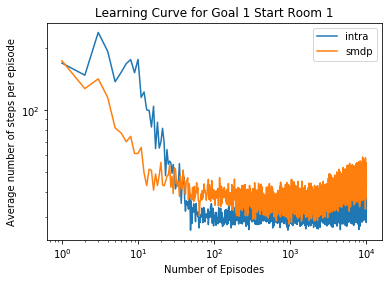

In [71]:
# %matplotlib inline  
# %matplotlib notebook
# %pylab
T = []
# num_episode=500
for i in range(num_episode):
    T.append(i+1)
plt.loglog(T,l_qlearn[0:num_episode],label="intra")
plt.loglog(T,l_sqlearn[0:num_episode],label="smdp")

plt.xlabel("Number of Episodes")
plt.ylabel("Average number of steps per episode")
plt.title("Learning Curve for Goal 1 Start Room 1")
plt.legend(loc="upper right")
plt.show()
e = FourRooms(ss,goal_state) 

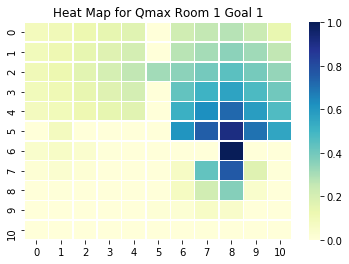

In [72]:
e = FourRooms(ss,goal_state) 
q = np.zeros([11,11])
d = Q_qlearn.keys()
for k in d:
    if k<104:
        r,c = e.decode(k)    
        i=0
        j=0
        if r==0:
            i = c[0]
            j = c[1]
        if r==1:
            i = c[0]
            j = c[1]+6
        if r==2:
            i = c[0]+7
            j = c[1]+6
        if r==3:
            i = c[0]+6
            j = c[1]
        q[i][j] = float("{:.3f}".format(np.max(Q_qlearn[k])) )
        
# %matplotlib inline  
# %matplotlib notebook
# %pylab
ax = sbn.heatmap(q, linewidth=0.5, cmap="YlGnBu")
plt.title("Heat Map for Qmax Room 1 Goal 1")
plt.show()

# from mpl_toolkits.mplot3d import Axes3D
# fig = plt.figure()
# ax = fig.gca(projection = '3d')
# X, Y = np.meshgrid(np.arange(11), np.arange(11))
# # for angle in range(0, 360):
# #     plt.pause(.001)
# plt.title("3D Rep for V values Goal 2 Start Room 1")

# ax.plot_surface(X, Y,transpose(q))

In [ ]:
# from collections import defaultdict
# def intra_q_learning(env,num_episodes,gamma = 0.9 , alpha = 0.25, epsilon = 0.1):
#     Q = defaultdict(lambda:np.zeros(6))
# #     env.reset()
# #     env.render()
#     Episodelen = []
#     AvgReward = []
#     for episode in range(num_episodes):
# #         env.render()
# #         print("Episode ",episode)
#         resetedpos = env._reset()
# #         print("Start state ",resetedpos)
#         state = resetedpos
#         rew = 0
#         length = 0
#         while(1):
# #             print("State is ",env.decode(state))
#             length+=1
#             Action_sel = get_action(Q[state],epsilon)
# #             print("Best action is",bestaction)
# #             print("Action selected ",Action_sel)
# #             print("State is",state)
# #             if(env.in_hallway_coord(env.decode(state)[1])):
# #                 print("hallway ", Q[state]," Selected action ", Action_sel)
            
#             if(Action_sel<=3):
#                 ######Primitive Actions########
#                 next_state, reward,isT, _ = env._step(Action_sel,False)
# #                 print("State is",next_state)
#                 rew+=reward
#                 length+=1
# #                 print("#primitive ",Action_sel)
#                 best_n_action = get_best_action(Q[next_state])
#                 #UPDATING
#                 d = reward + (gamma * Q[next_state][best_n_action]) - Q[state][Action_sel]
#                 Q[state][Action_sel] = Q[state][Action_sel]+alpha * (d)
#                 if isT:
#                     break
#                 state = next_state
#             else:
#                 ###options#####
#                 ###USE OPTION TRAJECTORY######
#                 Trajec = option_trajec(state,Action_sel-4,env)
#                 Return_opt = 0
#                 gamma_pow = 1
#                 #update options in intraoption
#                 #DOubt should u update primitive actions or not 
#                 S = state
#                 for i in range(len(Trajec)-1):
#                     nst = Trajec[i+1][0]
#                     best_n_action = get_best_action(Q[nst])
                
#                     rew+=Trajec[i][2]
#                     if(env.decode(nst)[0]==env.decode(state)[0]):
#                         As = Action_sel
#                     else:
#                         nroom = env.decode(nst)[0]
#                         thw = hwpos[env.decode(state)[0]][Action_sel-4] 
#                         for i in range(2):
#                             if thw == hwpos[nroom][i]:
#                                 As = i+4
#                                 break
                                
                    
#                     if i==len(Trajec)-2:
                    
#                         delt  = rew + (gamma * Q[nst][best_n_action])-Q[S][Action_sel]
#                         Q[S][Action_sel] = Q[S][Action_sel] + (alpha * delt)
#                     else:
# #                         if As!= Action_sel and i!= (len(Trajec)-1):
# #                             print("told ya ", env.decode(nst),As,env.decode(state),Action_sel)
#                         delt  = rew + (gamma * Q[nst][Action_sel])-Q[S][Action_sel]
#                         Q[S][Action_sel] = Q[S][Action_sel] + (alpha * delt)
#                     S = nst
                    
#                 n_st = Trajec[len(Trajec)-1][0]
#                 length+=len(Trajec)
#                 if(env.isT(n_st)):
#                     break
#                 state = n_st
                
# #         print("Length is ",length)
# #         print("rew is ",rew)
#         AvgReward.append(rew)
#         Episodelen.append(length)
#     return AvgReward,Episodelen,Q

In [ ]:
# ########SInce termination is 1 for all states outside or in hallways is 0
# hwpos = {
#         #division of options based on the hallway pos in the specified room say 4 itself[i][0] 5 other[i][1]
#         0 : [0,3],
#         1 : [1,0],
#         2 : [2,1],
#         3 : [3,2],
#     }
# xy_actions = {    #increase x     decrease x    increase y    decrease y
#      0 : [2,0,1,3],
#      1 : [2,0,1,3],
#         2 :[2,0,1,3],
#         3 :[2,0,1,3],
# }
# # hw_ind


# def option_trajec2(state,opt,env):
#     [room,coord]=env.decode(state)
#     tg_hw = hwpos[room][opt]
#     pre_hw = env.pre_hallways[room].keys()
#     tprehw_coord = [0,0]
#     for p in pre_hw:
#         if(tg_hw==env.pre_hallways[room][p][1]):
#             tprehw_coord =list(p)
    
#     thw_coord = env.hallway_coords[tg_hw]
# #     print("Option towards ",room,tprehw_coord);
# #     edit below to set 
#     nthw_coord = env.hallway_coords[hwpos[room][1-opt]]
#     curr_coord = coord
#     Trajec = []
#     our_room = room
# #     print(room)
# #     print(state)
#     n_st = state
#     while(curr_coord != thw_coord):
#         action_sel = -1
#         block = False
#         if room==our_room:
#             rc = np.array(tprehw_coord)-np.array(curr_coord)
#             ###########Action Selecting#########
#             if(abs(rc[0])>abs(rc[1])):
#                 if(rc[0]>0):
#                     action_sel =  2
#                 else:
#                     action_sel = 0
#             elif(abs(rc[0])<abs(rc[1])):
#                 if(rc[1]>0):
#                     action_sel = 1
#                 else:
#                     action_sel = 3
#             else:
#                 i = random.randint(0,1)
#                 if(i==0):
#                     if(rc[0]>0):
#                         action_sel =  2
#                     else:
#                         action_sel = 0
#                 else:
#                     if(rc[1]>0):
#                         action_sel = 1
#                     else:
#                         action_sel = 3 
#             if(rc[0]==0 and rc[1]==0):
#                 action_sel = env.pre_hallways[room][tuple(tprehw_coord)][0]
#         else:
#             if(curr_coord==nthw_coord):
#                 for i in range(4):
#                     #this is now 
#                     if(env.hallways[room][i][0]==our_room and env.hallways[room][i][1]!=nthw_coord):
#                         action_sel = i
#                         break
#             else:
# #                 print("*****************************************State",room,curr_coord)
                
#                 pre_hwr = env.pre_hallways[room].keys()
#                 ntprehw_coordr = [0,0]
# #                 print(env.pre_hallways[room])
#                 for p in pre_hwr:
# #                     print("Non target ",nthw_coord," hwpos ",hwpos[ env.pre_hallways[room][p][1] ] )
#                     if(nthw_coord == env.hallway_coords[ env.pre_hallways[room][p][1] ] ):
#                         ntprehw_coordr =list(p)
#                         break
# #                 print(ntprehw_coordr)
#                 rc = np.array(ntprehw_coordr)-np.array(curr_coord)
#                 ###########Action Selecting#########
#                 if(abs(rc[0])>abs(rc[1])):
#                     if(rc[0]>0):
#                         action_sel =  2
#                     else:
#                         action_sel = 0
#                 elif(abs(rc[0])<abs(rc[1])):
#                     if(rc[1]>0):
#                         action_sel = 1
#                     else:
#                         action_sel = 3
#                 else:
#                     i = random.randint(0,1)
#                     if(i==0):
#                         if(rc[0]>0):
#                             action_sel =  2
#                         else:
#                             action_sel = 0
#                     else:
#                         if(rc[1]>0):
#                             action_sel = 1
#                         else:
#                             action_sel = 3 
#                 for p in pre_hwr:
#                     if(curr_coord==list(p) and (not (curr_coord==ntprehw_coordr))):
#                         block = True
# #                         count+=1
#                         break
#                 if(rc[0]==0 and rc[1]==0):
# #                     print(room,"  ",ntprehw_coordr)
#                     action_sel = env.pre_hallways[room][tuple(ntprehw_coordr)][0]      
            
# #         print(curr_coord)
# #         print(action_sel)
#         tup = []
#         tup.append(env.encode([room,curr_coord]))
#         tup.append(action_sel)
# #         print(block)
#         n_st,r,term,_=env._step(action_sel,block)
#         tup.append(r)
#         Trajec.append(tup)
# #         print(env.decode(n_st))
#         [room,curr_coord] = env.decode(n_st)
#         if term:
#             break
#     tup=[]
#     tup.append(n_st)
#     tup.append(0)
#     tup.append(0)
#     Trajec.append(tup)
#     return Trajec
